In [1]:
import os

#add the root directory
os.chdir('../')

<h2> Visualize the f-PV manifold coloured by PVsource for the autoignition data

In [2]:
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.ticker import MaxNLocator
from utils import *
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

logging.disable(logging.CRITICAL)

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"

#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s2" #Without NOx
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


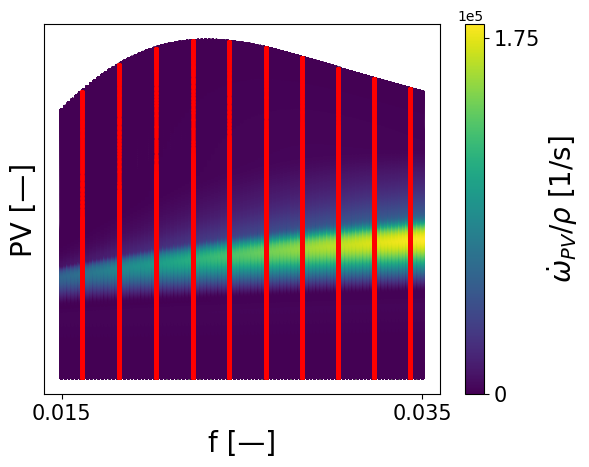

In [5]:
save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource with testTraj_betterAnnotated.png"

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x/100000}"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
cbar.ax.text(1.02, 1.01, "1e5", transform=cbar.ax.transAxes, fontsize=10, ha='right')
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        
    plt.scatter(np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]), PV_optimized_test, color = "red", s = 5)


if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

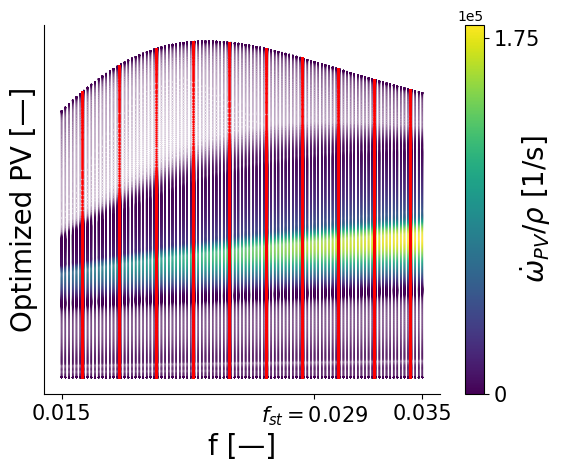

In [26]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource - PAPER.png"
namePDF = f"f-PV manifold-optimized-{id_model}-coloured-PVsource - PAPER.pdf"

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x/100000}"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=0.01, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20, labelpad = -15)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
cbar.ax.text(1.02, 1.01, "1e5", transform=cbar.ax.transAxes, fontsize=10, ha='right')
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("Optimized PV [\u2014]", fontsize = 20)
plt.xticks(
    [0.015, 0.029, 0.035],
    ["0.015", r"$f_{st} = 0.029$", "0.035"],
    fontsize=15
)
plt.yticks([])

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        
    plt.scatter(np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]), PV_optimized_test, color = "red", s = 0.5)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if(save):
    plt.savefig(path + name, dpi = 1000, bbox_inches='tight')
    plt.savefig(path + namePDF, bbox_inches='tight')
plt.show()

Zoom beginning of the manifold

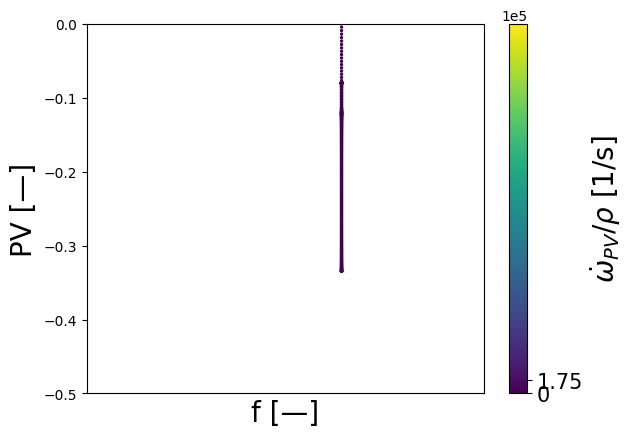

In [20]:
save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource with testTraj_betterAnnotated.png"

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x/100000}"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=2, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
cbar.ax.text(1.02, 1.01, "1e5", transform=cbar.ax.transAxes, fontsize=10, ha='right')
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
#plt.yticks([])
plt.xlim([0.02, 0.0202])
plt.ylim([-0.5, 0])

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

Show beginning and end of the trajectory

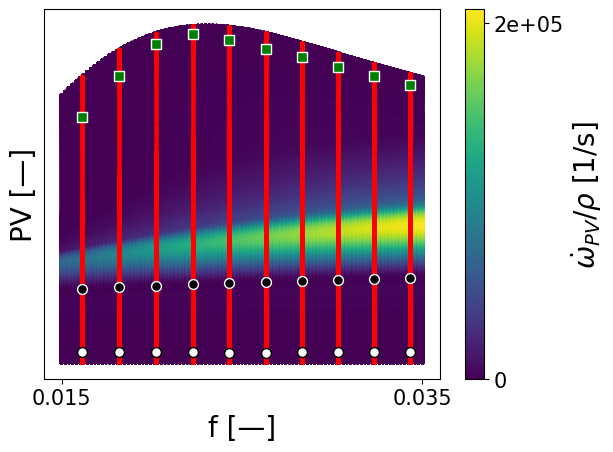

In [12]:
save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource with testTraj start-endTraj.png"

idx_start1 = 200
idx_start2 = 500
idx_end = 2300

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x:.0e}"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        
    plt.scatter(np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]), PV_optimized_test, color = "red", s = 5)
    plt.scatter(mixture_fractions_test[i], PV_optimized_test[idx_start1], color = "white", s = 15, zorder = 3)
    plt.scatter(mixture_fractions_test[i], PV_optimized_test[idx_start1], color = "white", edgecolors="black", s = 50, zorder = 3)
    plt.scatter(mixture_fractions_test[i], PV_optimized_test[idx_start2], color = "black", edgecolors="white", s = 50, zorder = 3)
    plt.scatter(mixture_fractions_test[i], PV_optimized_test[idx_end], color = "green", marker="s", edgecolors="white", s = 50, zorder = 3)


if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

Coloured by H2O2

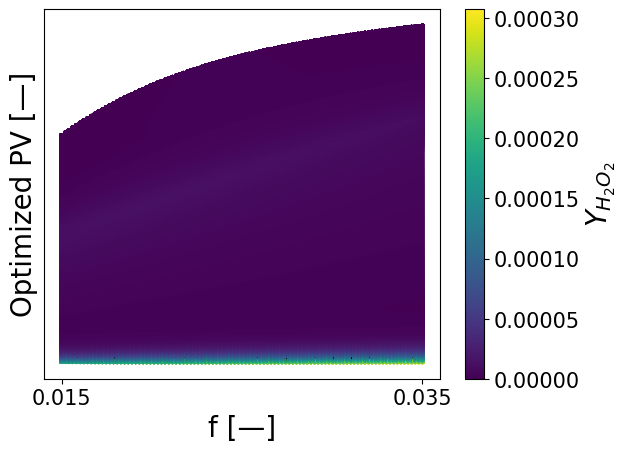

In [42]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-H2O2 with testTraj.png"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=state_space_train[state_space_names_DNS]["H2O2"])
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$Y_{H_2O_2}$', fontsize=20)
cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([0, 4000000])
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("Optimized PV [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

For the PV of Xu

In [5]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

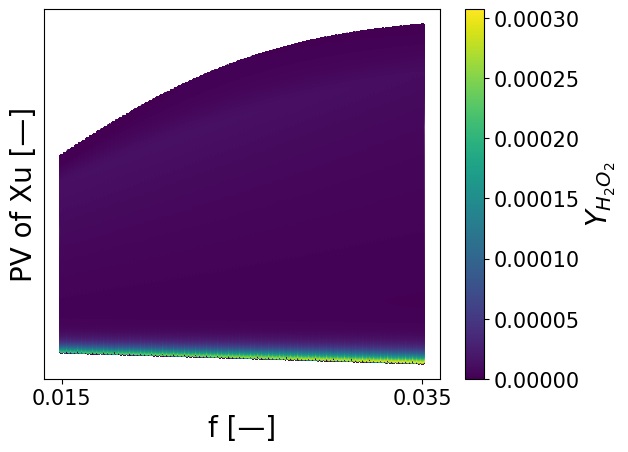

In [43]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-Xu-coloured-H2O2 with testTraj.png"

sc = plt.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=state_space_train[state_space_names_DNS]["H2O2"])
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$Y_{H_2O_2}$', fontsize=20)
cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([0, 4000000])
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV of Xu [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

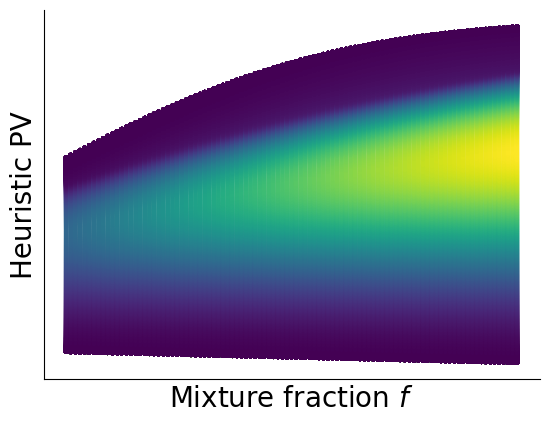

In [6]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-Xu-coloured-PVsource-PRESENTATION-v4.png"

fig, ax = plt.subplots()
sc = plt.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)
# cbar = plt.colorbar(sc)  # Add colorbar
# cbar.set_label(r'$Y_{H_2O_2}$', fontsize=20)
# cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([0, 4000000])
               
plt.xlabel("Mixture fraction $f$", fontsize = 20)
plt.ylabel("Heuristic PV", fontsize = 20)
plt.xticks([], fontsize = 15)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

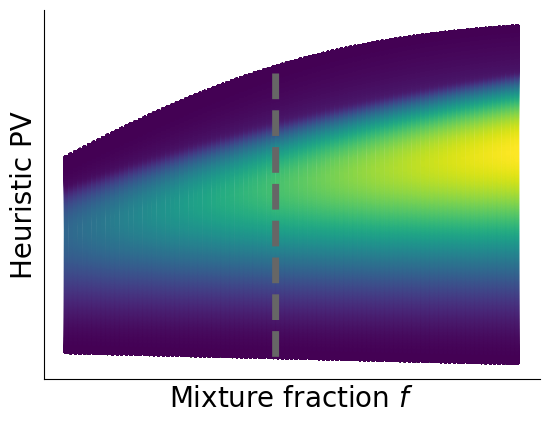

In [57]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-Xu-coloured-PVsource-PRESENTATION-v3.png"

fig, ax = plt.subplots()
sc = plt.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

idxTraj = 4

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    
plt.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]), PV_heuristic_test, color = str(0.4), linestyle = "--", linewidth = 5)
               
plt.xlabel("Mixture fraction $f$", fontsize = 20)
plt.ylabel("Heuristic PV", fontsize = 20)
plt.xticks([], fontsize = 15)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

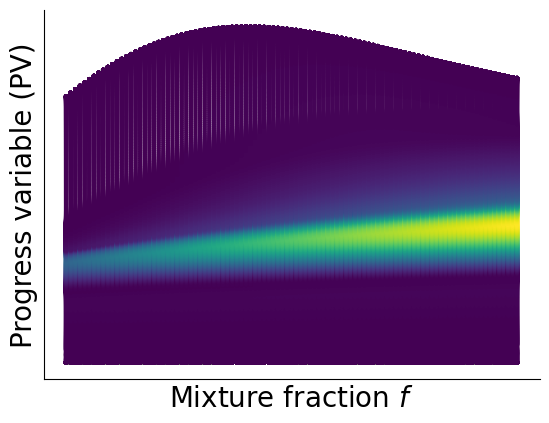

In [7]:
save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-Xu-coloured-PVsource-PRESENTATION-v4.png"

fig, ax = plt.subplots()
sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=PV_optimized_source_train)
# cbar = plt.colorbar(sc)  # Add colorbar
# cbar.set_label(r'$Y_{H_2O_2}$', fontsize=20)
# cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([0, 4000000])
               
plt.xlabel("Mixture fraction $f$", fontsize = 20)
plt.ylabel("Progress variable (PV)", fontsize = 20)
plt.xticks([], fontsize = 15)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

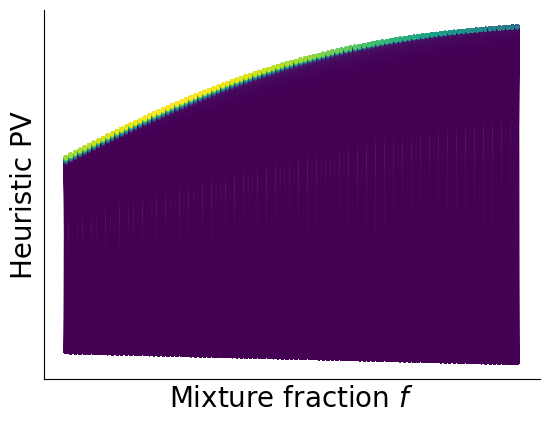

In [9]:
selected_species = "NO"

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-Xu-coloured-{selected_species}-PRESENTATION-v1.png"

fig, ax = plt.subplots()
sc = plt.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=state_space_train[state_space_names_DNS][selected_species])
# cbar = plt.colorbar(sc)  # Add colorbar
# cbar.set_label(r'$Y_{H_2O_2}$', fontsize=20)
# cbar.ax.tick_params(labelsize=15)
#cbar.set_ticks([0, 4000000])
               
plt.xlabel("Mixture fraction $f$", fontsize = 20)
plt.ylabel("Heuristic PV", fontsize = 20)
plt.xticks([], fontsize = 15)
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

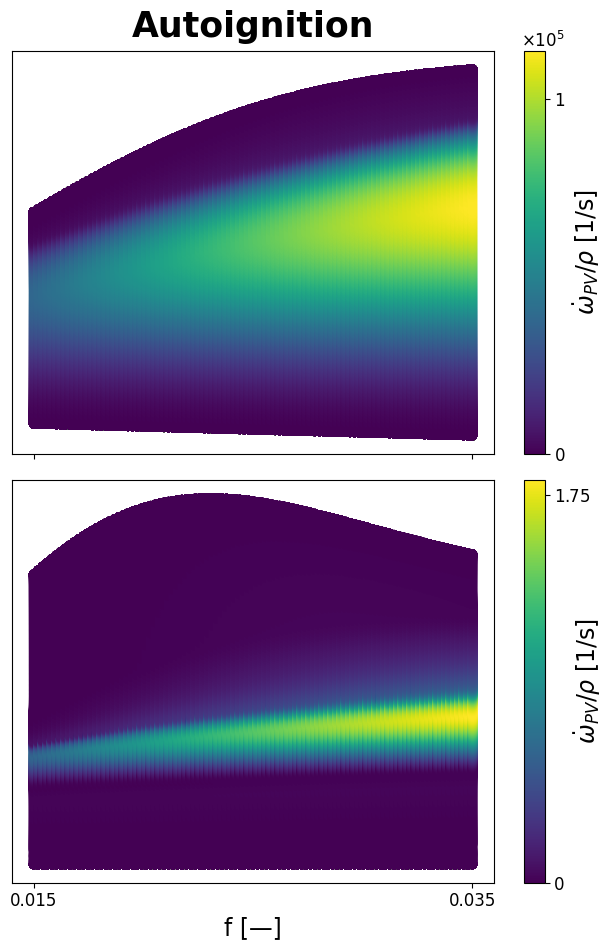

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = f"f-PV - Heuristic vs optimized - Autoignition.png"

fig, axes = plt.subplots(nrows=2, figsize=(6.4, 9.6), sharex=True)

# --- First subplot: Heuristic PV (Xu) ---
sc1 = axes[0].scatter(mixture_fractions_train, PV_Xu_train, c=PV_Xu_train_source, cmap='viridis', marker='o')
axes[0].set_title('Autoignition', fontsize=25, fontweight='bold', pad=10)
#axes[0].set_ylabel('Heuristic PV [—]', fontsize=20)
axes[0].set_yticks([])

# Colorbar for first subplot
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_ticks([0, 100000])
cbar1.ax.tick_params(labelsize=12)
formatter1 = ScalarFormatter(useMathText=True)
formatter1.set_powerlimits((0, 0))  # Always use scientific notation
cbar1.ax.yaxis.set_major_formatter(formatter1)
cbar1.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 17)
cbar1.ax.tick_params(labelsize=12)

# --- Second subplot: Optimized PV ---
sc2 = axes[1].scatter(mixture_fractions_train, PV_optimized_train, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1].set_xlabel('f [—]', fontsize=17)
#axes[1].set_ylabel('Optimized PV [—]', fontsize=20)
axes[1].set_yticks([])

def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Force 0 to display as an integer
    else:
        return '{:.0e}'.format(x)

class CustomScalarFormatter(ScalarFormatter):
    def __init__(self, useOffset=True, useMathText=False):
        super().__init__(useOffset=useOffset, useMathText=useMathText)

    def __call__(self, x, pos=None):
        # If the value is zero, format it as "0" instead of "0.00"
        if x == 0:
            return "0"
        else:
            return super().__call__(x, pos)

# Colorbar for second subplot
cbar2 = fig.colorbar(sc2, ax=axes[1])
# formatter2 = ScalarFormatter(useMathText=True)
# formatter2.set_powerlimits((0, 0))
# #cbar2.ax.yaxis.set_major_formatter(formatter2)
# cbar2.ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

formatter2 = CustomScalarFormatter(useMathText=True)
formatter2.set_powerlimits((0, 0))
cbar2.ax.yaxis.set_major_formatter(formatter2)

cbar2.set_ticks([0, 175000])
cbar2.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 17, labelpad=-13)
cbar2.ax.tick_params(labelsize=12)

cbar1.ax.yaxis.offsetText.set_fontsize(12)
cbar2.ax.yaxis.offsetText.set_fontsize(12)

offset_text = cbar1.ax.yaxis.get_offset_text()
offset_text.set_x(offset_text.get_position()[0] + 1)

offset_text = cbar2.ax.yaxis.get_offset_text()
offset_text.set_x(offset_text.get_position()[0] + 1)

cbar2.ax.yaxis.offsetText.set_visible(False)

# Set shared x-ticks
axes[1].set_xticks([0.015, 0.035])
axes[1].tick_params(axis='x', labelsize=12)

# Optional: Remove grid if needed
axes[0].grid(False)
axes[1].grid(False)

# Adjust layout
plt.tight_layout()

# Save figure if needed
if save:
    plt.savefig(pathSave + name, dpi=300, bbox_inches='tight')

plt.show()

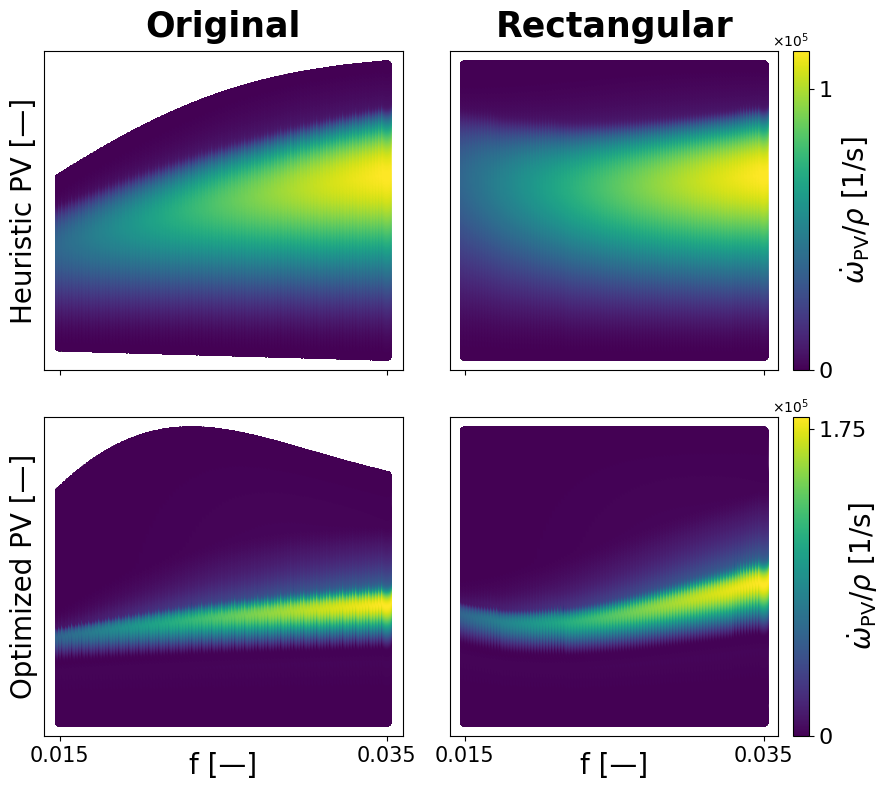

In [22]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = f"f-PV - Heuristic vs optimized - Autoignition - original vs rectangular manifold.png"

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 8), sharex=True)

# --- First subplot: Heuristic PV (Xu) ---
sc1 = axes[0, 0].scatter(mixture_fractions_train, PV_Xu_train, c=PV_Xu_train_source, cmap='viridis', marker='o')
axes[0, 0].set_title('Original', fontsize=25, fontweight='bold', pad=10)
axes[0, 0].set_ylabel('Heuristic PV [—]', fontsize=20)
axes[0, 0].set_yticks([])

# --- Second subplot: Optimized PV ---
sc2 = axes[1, 0].scatter(mixture_fractions_train, PV_optimized_train, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1, 0].set_xlabel('f [—]', fontsize=20, labelpad = -10)
axes[1, 0].set_ylabel('Optimized PV [—]', fontsize=20)
axes[1, 0].set_yticks([])

df = pd.DataFrame({
    'PV Xu': PV_Xu_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_Xu_scaled'] = df.groupby('mixture_fraction')['PV Xu'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_Xu_scaled = df['PV_Xu_scaled'].to_numpy()

sc1 = axes[0, 1].scatter(mixture_fractions_train, PV_Xu_scaled, c=PV_Xu_train_source, cmap='viridis', marker='o')
axes[0, 1].set_title('Rectangular', fontsize=25, fontweight='bold', pad=10)
axes[0, 1].set_yticks([])

df = pd.DataFrame({
    'PV optimized': PV_optimized_train.squeeze(),
    'mixture_fraction': mixture_fractions_train
})

# Normalize PV within each mixture_fraction group
df['PV_optimized_scaled'] = df.groupby('mixture_fraction')['PV optimized'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
)

# Get the PV back to numpy
PV_optimized_scaled = df['PV_optimized_scaled'].to_numpy()

sc2 = axes[1, 1].scatter(mixture_fractions_train, PV_optimized_scaled, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1, 1].set_xlabel('f [—]', fontsize=20, labelpad = -10)
axes[1, 1].set_yticks([])

def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Force 0 to display as an integer
    else:
        return '{:.0e}'.format(x)

class CustomScalarFormatter(ScalarFormatter):
    def __init__(self, useOffset=True, useMathText=False):
        super().__init__(useOffset=useOffset, useMathText=useMathText)

    def __call__(self, x, pos=None):
        # If the value is zero, format it as "0" instead of "0.00"
        if x == 0:
            return "0"
        else:
            return super().__call__(x, pos)

formatter2 = CustomScalarFormatter(useMathText=True)
formatter2.set_powerlimits((0, 0))

cbar1 = fig.colorbar(sc1, ax=axes[0, 1], location='right', fraction=0.046, pad=0.04)
cbar1.set_ticks([0, 100000])
cbar1.ax.tick_params(labelsize=16)
cbar1.ax.yaxis.set_major_formatter(formatter1)
cbar1.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=20)

# Second row colorbar
cbar2 = fig.colorbar(sc2, ax=axes[1, 1], location='right', fraction=0.046, pad=0.04)
cbar2.set_ticks([0, 175000])
cbar2.ax.tick_params(labelsize=16)
cbar2.ax.yaxis.set_major_formatter(formatter2)
cbar2.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=20, labelpad = -15)

# Set shared x-ticks
axes[1, 0].set_xticks([0.015, 0.035])
axes[1, 0].tick_params(axis='x', labelsize=15)

axes[1, 1].set_xticks([0.015, 0.035])
axes[1, 1].tick_params(axis='x', labelsize=15)

# Optional: Remove grid if needed
axes[0, 0].grid(False)
axes[1, 0].grid(False)

# Adjust layout
plt.tight_layout()

# Save figure if needed
if save:
    plt.savefig(pathSave + name, dpi=300, bbox_inches='tight')

plt.show()

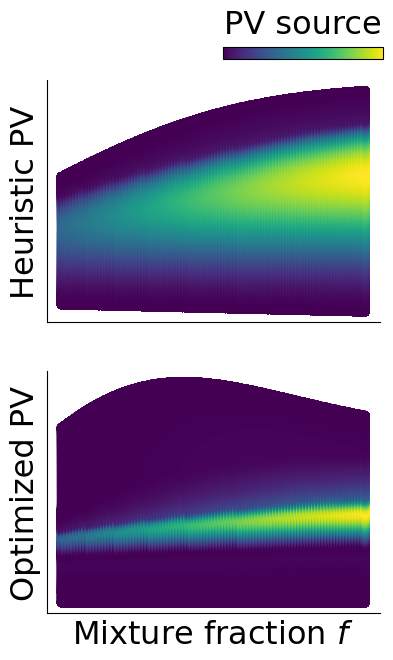

In [22]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = f"f-PV - Heuristic vs optimized - Autoignition - graphical abstract v3.png"

fig, axes = plt.subplots(nrows=2, figsize=(4, 6), sharex=True)

# --- First subplot: Heuristic PV (Xu) ---
sc1 = axes[0].scatter(mixture_fractions_train, PV_Xu_train, c=PV_Xu_train_source, cmap='viridis', marker='o')
#axes[0].set_ylabel('Heuristic PV [—]', fontsize=20)
axes[0].set_yticks([])
axes[0].set_ylabel('Heuristic PV', fontsize=23)

# --- Second subplot: Optimized PV ---
sc2 = axes[1].scatter(mixture_fractions_train, PV_optimized_train, c=PV_optimized_source_train, cmap='viridis', marker='o')
axes[1].set_xlabel('Mixture fraction $f$', fontsize=23)
axes[1].set_ylabel('Optimized PV', fontsize=23)
#axes[1].set_ylabel('Optimized PV [—]', fontsize=20)
axes[1].set_yticks([])

# Set shared x-ticks
axes[1].set_xticks([])
axes[1].tick_params(axis='x', labelsize=22)

# Optional: Remove grid if needed
axes[0].grid(False)
axes[1].grid(False)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)

# For horizontal bar:
cbar_ax = fig.add_axes([0.57, 1.01, 0.4, 0.02])
cbar = fig.colorbar(sc1, cax=cbar_ax, orientation='horizontal')

cbar.set_ticks([])

cbar.set_label('PV source', fontsize=23, labelpad=10)
cbar.ax.xaxis.set_label_position('top')  # put label below
cbar.ax.xaxis.set_ticks_position('none') 

# Adjust layout


# Save figure if needed
if save:
    plt.savefig(pathSave + name, dpi=1000, bbox_inches='tight')

plt.show()

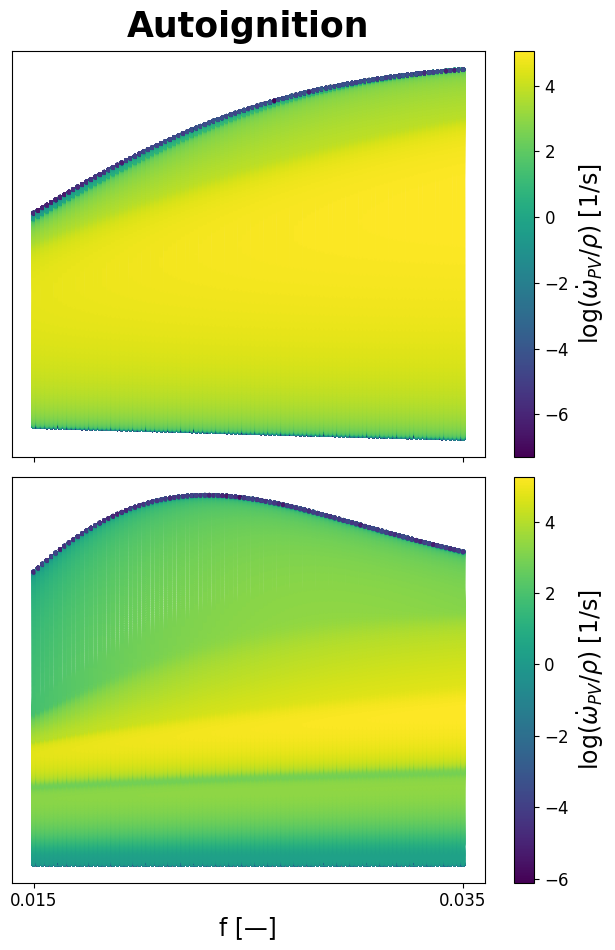

In [20]:
#with log of PVsource

save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = f"f-PV - Heuristic vs optimized - Autoignition - log(PVsource).png"

fig, axes = plt.subplots(nrows=2, figsize=(6.4, 9.6), sharex=True)

# --- First subplot: Heuristic PV (Xu) ---

mask = PV_Xu_train_source>0
logPVsource_Xu = np.log10(PV_Xu_train_source[mask])
sc1 = axes[0].scatter(mixture_fractions_train[mask.squeeze()], PV_Xu_train[mask], c=logPVsource_Xu, cmap='viridis', marker='o', s = 5)
axes[0].set_title('Autoignition', fontsize=25, fontweight='bold', pad=10)
#axes[0].set_ylabel('Heuristic PV [—]', fontsize=20)
axes[0].set_yticks([])

# Colorbar for first subplot
cbar1 = fig.colorbar(sc1, ax=axes[0])
#cbar1.set_ticks([0, 100000])
cbar1.ax.tick_params(labelsize=12)
formatter1 = ScalarFormatter(useMathText=True)
formatter1.set_powerlimits((0, 0))  # Always use scientific notation
cbar1.ax.yaxis.set_major_formatter(formatter1)
cbar1.set_label(r'log($\dot{\omega}_{PV} / \rho$) [1/s]', fontsize = 17)
cbar1.ax.tick_params(labelsize=12)

# --- Second subplot: Optimized PV ---
mask = PV_optimized_source_train>0
logPVsource_optimized = np.log10(PV_optimized_source_train[mask])
sc2 = axes[1].scatter(mixture_fractions_train[mask.squeeze()], PV_optimized_train[mask], c=logPVsource_optimized, cmap='viridis', marker='o', s = 5)
axes[1].set_xlabel('f [—]', fontsize=17)
#axes[1].set_ylabel('Optimized PV [—]', fontsize=20)
axes[1].set_yticks([])

def custom_formatter(x, pos):
    if x == 0:
        return "0"  # Force 0 to display as an integer
    else:
        return '{:.0e}'.format(x)

class CustomScalarFormatter(ScalarFormatter):
    def __init__(self, useOffset=True, useMathText=False):
        super().__init__(useOffset=useOffset, useMathText=useMathText)

    def __call__(self, x, pos=None):
        # If the value is zero, format it as "0" instead of "0.00"
        if x == 0:
            return "0"
        else:
            return super().__call__(x, pos)

# Colorbar for second subplot
cbar2 = fig.colorbar(sc2, ax=axes[1])

formatter2 = CustomScalarFormatter(useMathText=True)
formatter2.set_powerlimits((0, 0))
cbar2.ax.yaxis.set_major_formatter(formatter2)

#cbar2.set_ticks([0, 175000])
cbar2.set_label(r'log($\dot{\omega}_{PV} / \rho$) [1/s]', fontsize = 17)
cbar2.ax.tick_params(labelsize=12)

cbar1.ax.yaxis.offsetText.set_fontsize(12)
cbar2.ax.yaxis.offsetText.set_fontsize(12)

offset_text = cbar1.ax.yaxis.get_offset_text()
offset_text.set_x(offset_text.get_position()[0] + 1)

offset_text = cbar2.ax.yaxis.get_offset_text()
offset_text.set_x(offset_text.get_position()[0] + 1)

cbar2.ax.yaxis.offsetText.set_visible(False)

# Set shared x-ticks
axes[1].set_xticks([0.015, 0.035])
axes[1].tick_params(axis='x', labelsize=12)

# Optional: Remove grid if needed
axes[0].grid(False)
axes[1].grid(False)

# Adjust layout
plt.tight_layout()

# Save figure if needed
if save:
    plt.savefig(pathSave + name, dpi=300, bbox_inches='tight')

plt.show()

<h2> Overview manifolds for all the species

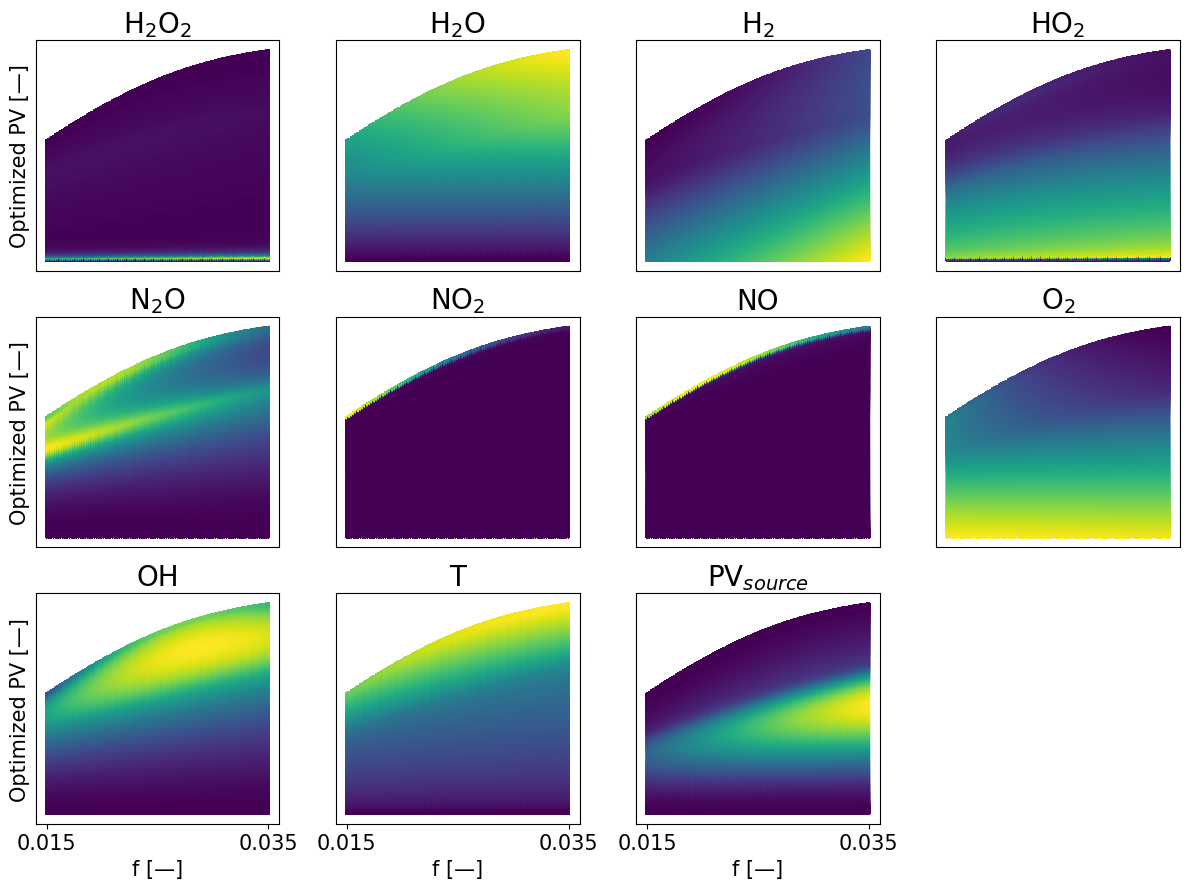

In [15]:
rows, cols = 3,4

keysSpecies = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

Xu_optimized = "Optimized"

save = True
pathSave = f"C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/f-PV manifold/"
name = f"f-PV manifolds - Autoignition - coloured by QoIs - {Xu_optimized} - without NOx - {id_model}.png"

fig, axes = plt.subplots(rows, cols, figsize=(12,9))  # Define the grid
axes = axes.flatten()
for i, key in enumerate(keys):
    ax = axes[i]

    if(Xu_optimized.lower() == "xu"):
         dataPV_fl = PV_Xu_train
    elif(Xu_optimized.lower() == "optimized"):
         dataPV_fl = PV_optimized_train
    else:
         raise ValueError("Variable 'Xu_optimized' has an invalid value; Choose either 'xu' or 'optimized'.")

    if(key in keysSpecies or key  == "T"):
         dataColor = state_space_train[key]
    elif(key == "PV1"):
         if(Xu_optimized.lower() == "xu"):
            dataColor = PV_Xu_train_source
         elif(Xu_optimized.lower() == "optimized"):
            dataColor = PV_optimized_source_train
         

    ax.scatter(mixture_fractions_train, dataPV_fl, c = dataColor, cmap = "viridis", s=1)

    if(i>len(keys)-cols):
        ax.set_xticks([0.015, 0.035])
        ax.tick_params(axis="x", labelsize=15)
        ax.set_xlabel("f [\u2014]", fontsize = 15)
    else:
        ax.set_xticks([])
    if(i%cols == 0):
        ax.set_ylabel(f'{"Optimized" if Xu_optimized.lower() == "optimized" else "Heuristic"} PV [\u2014]', fontsize = 15)
    ax.set_yticks([])
    
    key = key.replace("2", "$_{2}$").replace("1", "$_{source}$")

    ax.set_title(rf"{key}", fontsize=20)


for j in range(len(keys), len(axes)): #disables axes of plots not used
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

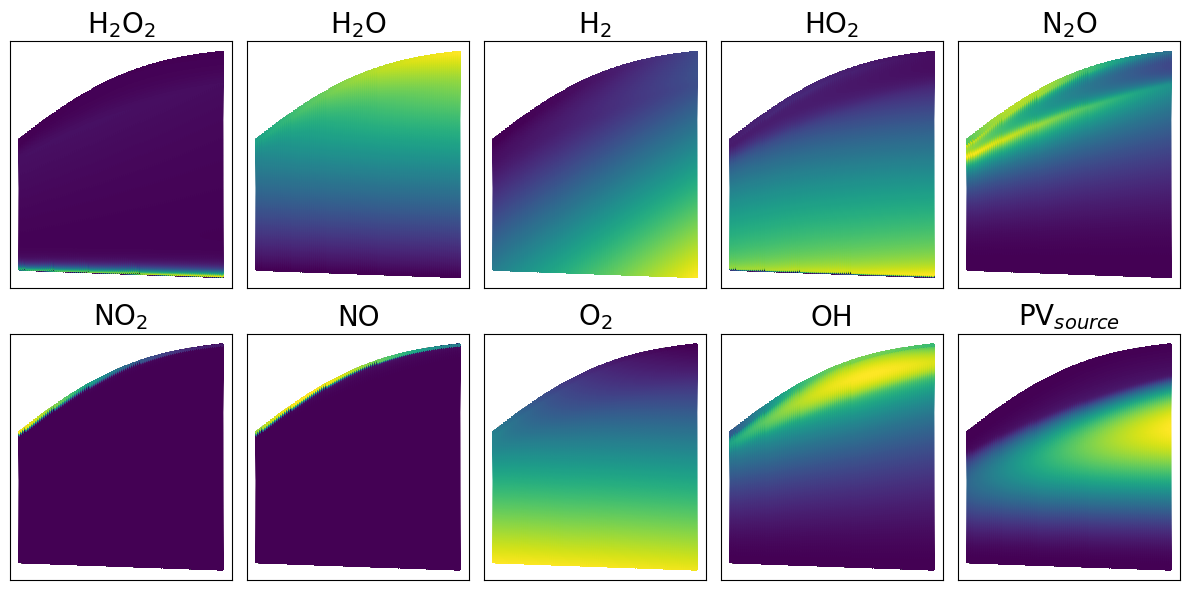

In [17]:
rows, cols = 2, 5

keysSpecies = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'PV1']

Xu_optimized = "Xu"

save = False
pathSave = f"C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/f-PV manifold/"
name = f"f-PV manifolds - Autoignition - coloured by QoIs - {Xu_optimized} - without NOx - {id_model} - PRESENTATION-v2.png"

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))  # Define the grid
axes = axes.flatten()
for i, key in enumerate(keys):
    ax = axes[i]

    if(Xu_optimized.lower() == "xu"):
         dataPV_fl = PV_Xu_train
    elif(Xu_optimized.lower() == "optimized"):
         dataPV_fl = PV_optimized_train
    else:
         raise ValueError("Variable 'Xu_optimized' has an invalid value; Choose either 'xu' or 'optimized'.")

    if(key in keysSpecies or key  == "T"):
         dataColor = state_space_train[key]
    elif(key == "PV1"):
         if(Xu_optimized.lower() == "xu"):
            dataColor = PV_Xu_train_source
         elif(Xu_optimized.lower() == "optimized"):
            dataColor = PV_optimized_source_train
         

    ax.scatter(mixture_fractions_train, dataPV_fl, c = dataColor, cmap = "viridis", s=1)

    if(i>=len(keys)-cols):
        ax.set_xticks([])
        ax.tick_params(axis="x", labelsize=15)
        #ax.set_xlabel("Mixture fraction $f$", fontsize = 15)
    else:
        ax.set_xticks([])
    #if(i%cols == 0):
    #    ax.set_ylabel("Progress variable (PV)", fontsize = 15)
    ax.set_yticks([])
    
    key = key.replace("2", "$_{2}$").replace("1", "$_{source}$")

    ax.set_title(rf"{key}", fontsize=20)
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)


for j in range(len(keys), len(axes)): #disables axes of plots not used
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

## Different seeds and for different species

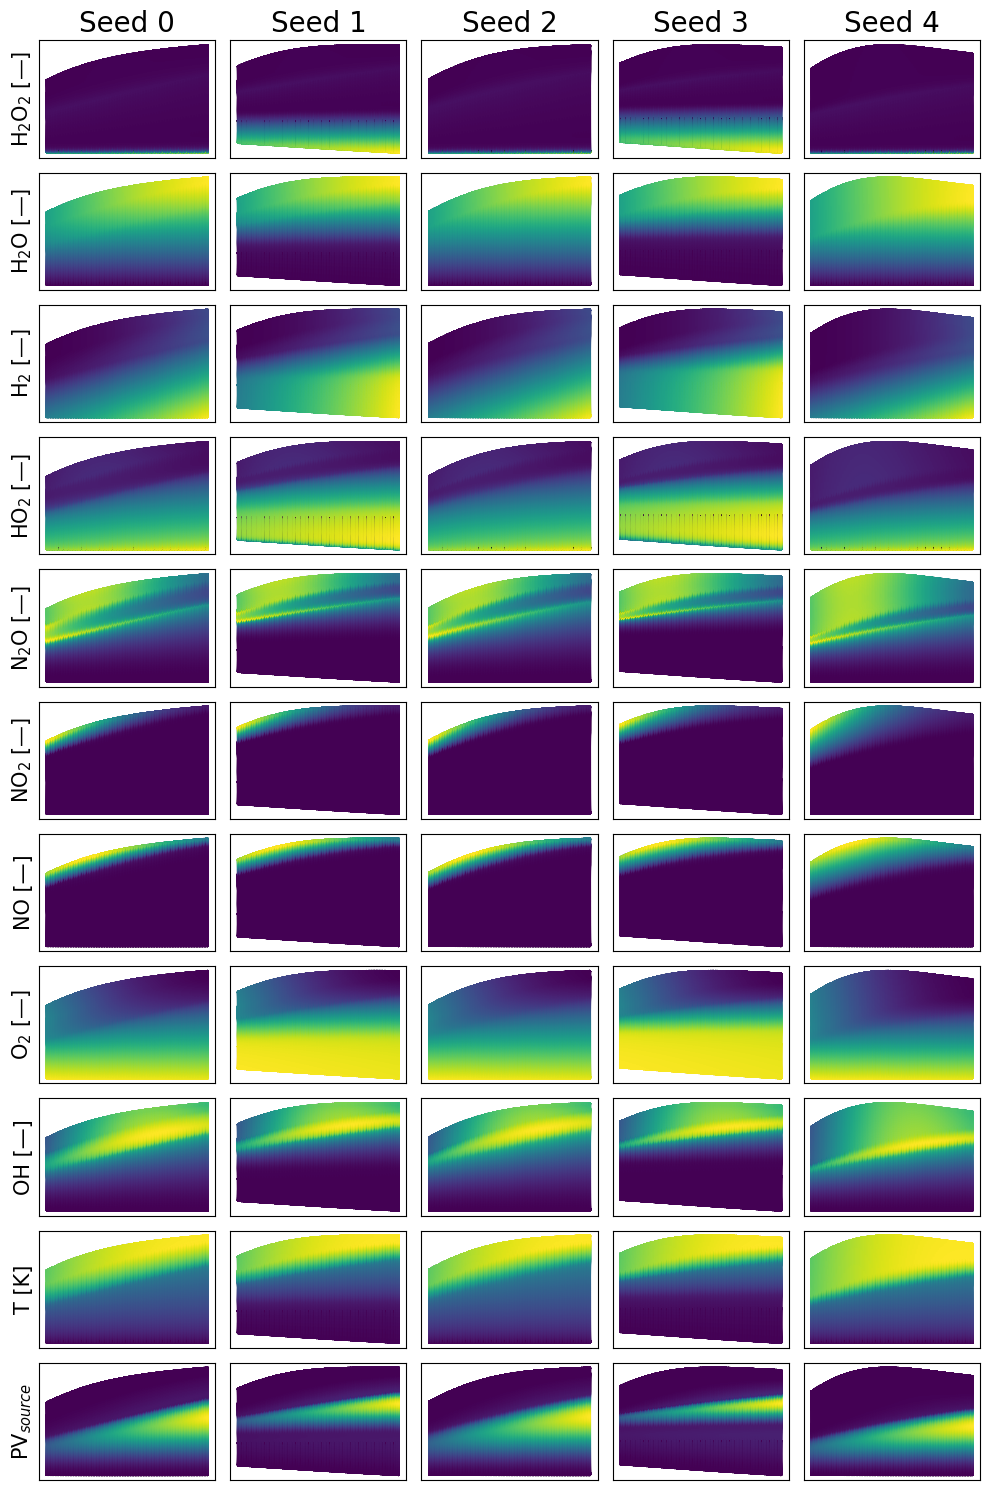

In [25]:
keysSpecies = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

nbrSeeds = 5

rows, cols = len(keys), nbrSeeds



Xu_optimized = "Optimized"

save = True
pathSave = f"C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Autoignition/f-PV manifold/"
name = f"f-PV manifolds - Autoignition - coloured by QoIs - 2h_s with NOx - allSeeds.png"

fig, axes = plt.subplots(rows, cols, figsize=(10, 15))  # Define the grid
axes = axes.flatten()
for j in range(nbrSeeds):
    
    filename_model = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s{j}"
    
    #f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s{j}"
    
    #f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s{j}"
    
    #f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s{j}"

    #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s2" #Without NOx
    #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
    #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx
    filename_metadata = filename_model + "_metadata.pkl"
    path_metadata = "metadata/"
    filename_species_names = "Xu-state-space-names.csv"
    path_data = "data-files/"

    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
    id_model = loader.metadata["Training_id"]
    model = loader.loadModel()

    weight_inversion = True
    if(weight_inversion and j != 2): #for 2v: 2 and 3 -  and j != 3):
        with torch.no_grad():  # Ensures we do not track gradients for this operation
            model.encoder_species.weight.mul_(-1)

    state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

    #create a np array in the format for the DNS dataset/optimized PV
    state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
    state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

    PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_min_train = PV_optimized_train.min()
    PV_optimized_max_train = PV_optimized_train.max()
    PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
    f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
    f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
    PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()


    for i, key in enumerate(keys):

        ax = axes[i*nbrSeeds + j]

        if(key in keysSpecies or key  == "T"):
            dataColor = state_space_train[key]
            unit = 'K' if key == 'T' else '—'
            nameColor = f"{key.replace('2', '$_2$')} [{unit}]"
        elif(key == "PV1"):
            dataColor = PV_optimized_source_train
            nameColor = "PV$_{source}$"
        
        random_idx = np.random.choice(len(PV_optimized_train), size=10000, replace=False)
        #ax.scatter(mixture_fractions_train[random_idx], PV_optimized_train[random_idx], c = dataColor[random_idx], cmap = "viridis", s=1)

        ax.scatter(mixture_fractions_train, PV_optimized_train, c = dataColor, cmap = "viridis", s=1)

        ax.set_xticks([])

        if(j == 0):
            ax.set_ylabel(f'{nameColor}', fontsize = 15)
        ax.set_yticks([])
    
        if(i == 0):
            ax.set_title(f"Seed {j}", fontsize=20)


handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

### Visualize all seeds of Tr0D-2q

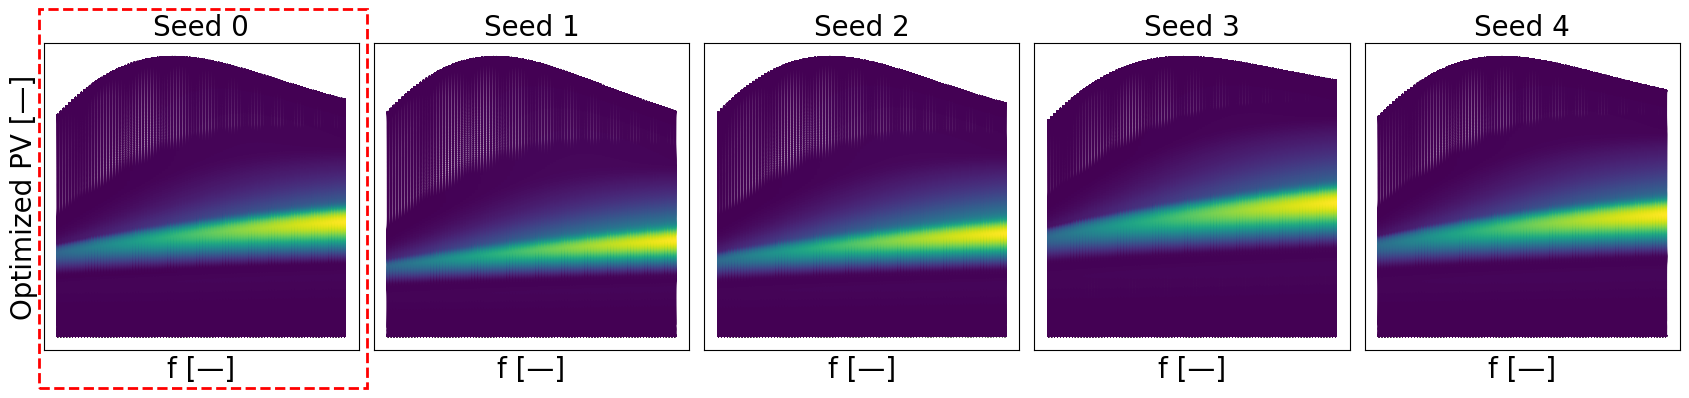

In [24]:
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

rows, cols = 1, 5

Xu_optimized = "optimized"

save = True
pathSave = f"C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/A priori/{'Heuristic' if Xu_optimized.lower() == 'xu' else 'Optimized'}/"
name = f"f-PV manifolds - coloured by QoIs - DNS - optimized Tr0D-2q - different seeds.png"

fig, axes = plt.subplots(rows, cols, figsize=(17, 4))  # Define the grid
axes = axes.flatten()
for i in range(5):
    ax = axes[i]

    filename = f"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s{i}"
    filename_metadata = filename + "_metadata.pkl"
    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
    model = loader.loadModel()
    id_model = loader.metadata["Training_id"]

    weight_inversion = True
    if(weight_inversion and i != 2): #for 2v: 2 and 3 -  and j != 3):
        with torch.no_grad():  # Ensures we do not track gradients for this operation
            model.encoder_species.weight.mul_(-1)

    state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

    #create a np array in the format for the DNS dataset/optimized PV
    state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
    state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

    PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_min_train = PV_optimized_train.min()
    PV_optimized_max_train = PV_optimized_train.max()
    PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
    f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
    f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
    PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    #random_idx = np.random.choice(len(optimized_PV), size=10000, replace=False)

    #ax.scatter(data_mf[random_idx], optimized_PV[random_idx], c = optimized_PV_source[random_idx], cmap = "viridis", s=1)

    ax.scatter(mixture_fractions_train, PV_optimized_train, c = PV_optimized_source_train, cmap = "viridis", s=1)

    ax.set_xlabel("f [\u2014]", fontsize = 20)
    ax.set_xticks([])
    if(i%cols == 0):
        ax.set_ylabel(f'Optimized PV [\u2014]', fontsize = 20)
    ax.set_yticks([])
    

    ax.set_title(f"Seed {i}", fontsize=20)

    if i == 0:
        bbox = ax.get_position()
        plt.gcf().add_artist(plt.Rectangle(
            (bbox.x0 - 0.74*bbox.width, bbox.y0 - 0.11*bbox.height),     
            1.44*bbox.width,
            bbox.height + 0.23*bbox.height,
            fill=False,
            edgecolor='red',
            linestyle='--',
            linewidth=2,
            transform=plt.gcf().transFigure,
            zorder=10
        ))


plt.tight_layout()
if(save):
        plt.savefig(f"{pathSave}{name}", dpi = 300, bbox_inches="tight")
plt.show()

In [8]:
loader.metadata["dataset_type"]

'autoignition_augm'

## Negative source values

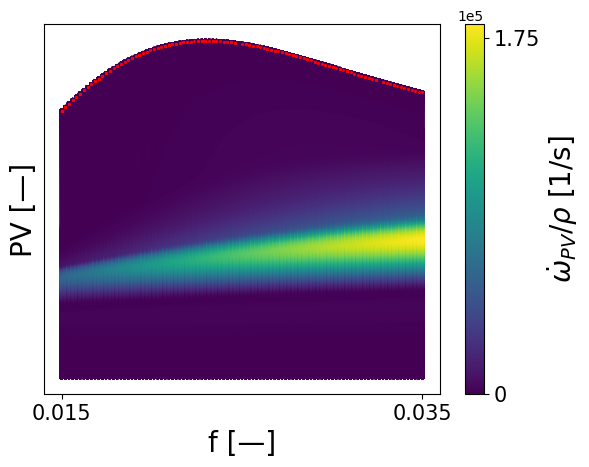

In [51]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/Negative PV source values/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}- indication PVsource values below 1e-07.png"

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x/100000}"

sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
cbar.ax.text(1.02, 1.01, "1e5", transform=cbar.ax.transAxes, fontsize=10, ha='right')

mask_negative_PVsource = PV_optimized_source_train<1e-07
sc = plt.scatter(mixture_fractions_train[mask_negative_PVsource.squeeze()], PV_optimized_train[mask_negative_PVsource.squeeze()], s=1, c="red")
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

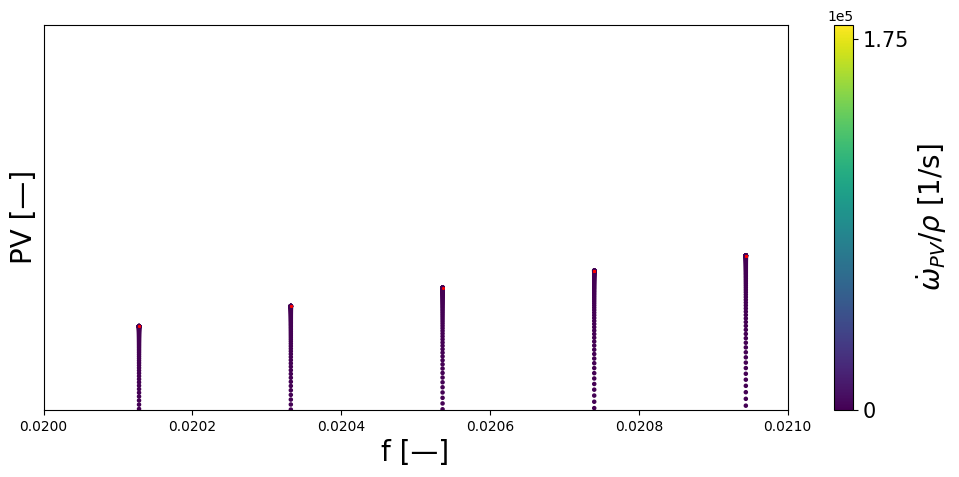

In [78]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/Negative PV source values/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}- indication PVsource values below 1e-07 - zoom.png"

def sci_notation_formatter(x, pos):
    if x == 0:
        return "0"  # Display zero as "0"
    else:
        return f"{x/100000}"

plt.figure(figsize=(12, 5))
sc = plt.scatter(mixture_fractions_train, PV_optimized_train, s=5, c=PV_optimized_source_train)
cbar = plt.colorbar(sc)  # Add colorbar
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=20)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0, 175000])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(sci_notation_formatter))
cbar.ax.text(1.02, 1.01, "1e5", transform=cbar.ax.transAxes, fontsize=10, ha='right')

mask_negative_PVsource = PV_optimized_source_train<1e-07
sc = plt.scatter(mixture_fractions_train[mask_negative_PVsource.squeeze()], PV_optimized_train[mask_negative_PVsource.squeeze()], s=1, c="red")
               
plt.xlabel("f [\u2014]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
#plt.xticks([0.015, 0.035], fontsize = 15)
plt.yticks([])
plt.xlim([0.02, 0.021])
plt.ylim([2.9, 3.1])

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

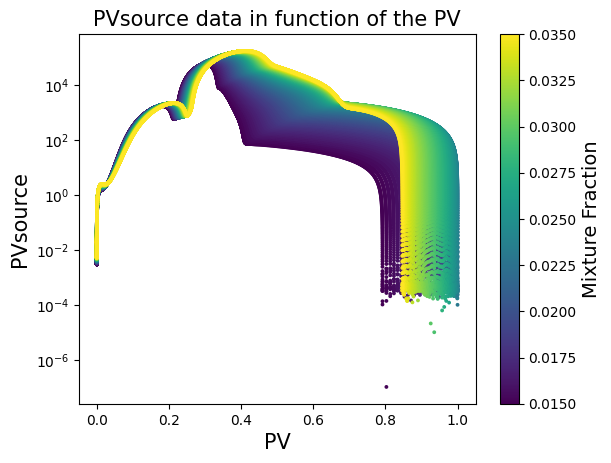

In [40]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/Exploration/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"PVsource vs PV - color mixture fraction-{id_model}.png"

PV_optimized_source_train_scaled = np.log10(PV_optimized_source_train - PV_optimized_source_train.min() + 1e-07)

fig, ax = plt.subplots()
sc = plt.scatter(PV_optimized_train_scaled, PV_optimized_source_train - PV_optimized_source_train.min() + 1e-07, s=3, c = mixture_fractions_train)
plt.xlabel("PV", fontsize = 15)
plt.ylabel("PVsource", fontsize = 15)
plt.yscale("log")
plt.title("PVsource data in function of the PV", fontsize = 15)
cbar = fig.colorbar(sc)
cbar.set_label('Mixture Fraction', fontsize=14)
if(save):
    plt.savefig(path+name, dpi = 300)
plt.show()

In [46]:
print(f"Number of negative PVsource values: {np.sum(PV_optimized_source_train<0)}")
print(f"Number of PVsource values below 1e-07: {np.sum(PV_optimized_source_train<1e-07)}")
print(f"Number of PVsource values below 1e-05: {np.sum(PV_optimized_source_train<1e-05)}")
print(f"Number of PVsource values below 1e-04: {np.sum(PV_optimized_source_train<1e-04)}")
print(f"Number of PVsource values below 1e-03: {np.sum(PV_optimized_source_train<1e-03)}")

Number of negative PVsource values: 316
Number of PVsource values below 1e-07: 316
Number of PVsource values below 1e-05: 340
Number of PVsource values below 1e-04: 594
Number of PVsource values below 1e-03: 1021


Number of PVsource values below 1e-07: 4


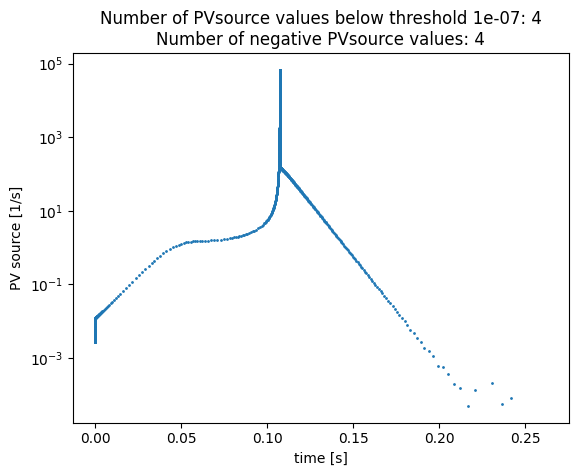

Number of PVsource values below 1e-07: 5


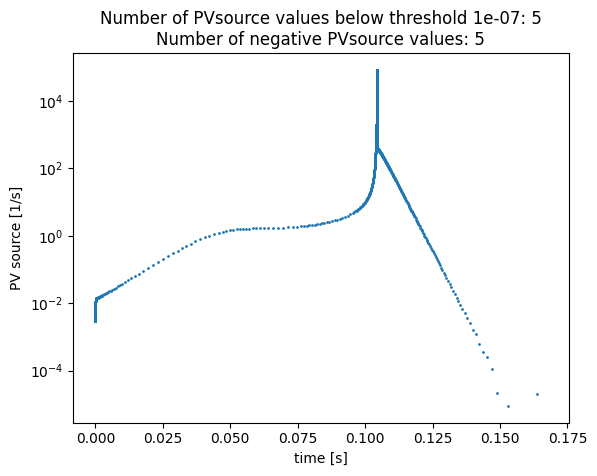

Number of PVsource values below 1e-07: 3


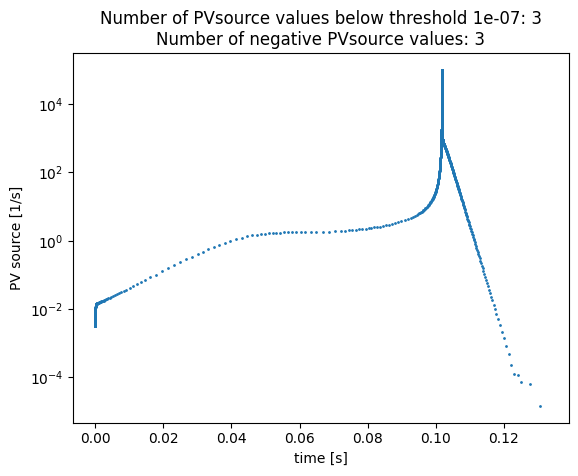

Number of PVsource values below 1e-07: 2


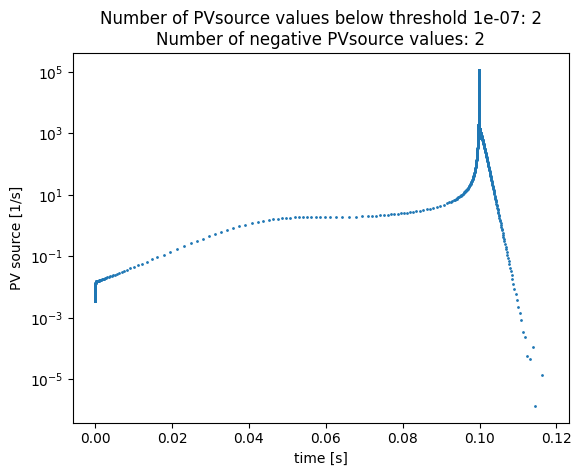

Number of PVsource values below 1e-07: 3


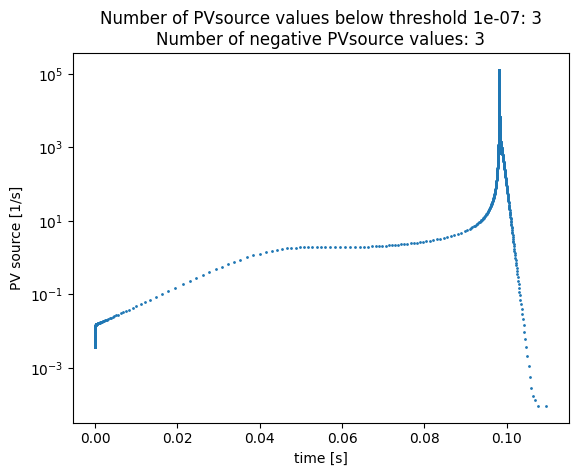

Number of PVsource values below 1e-07: 4


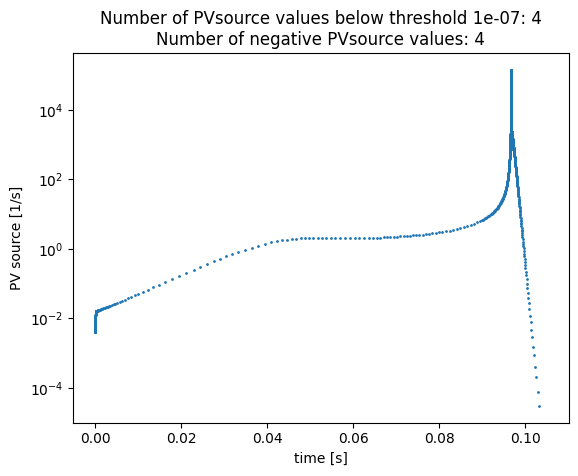

Number of PVsource values below 1e-07: 4


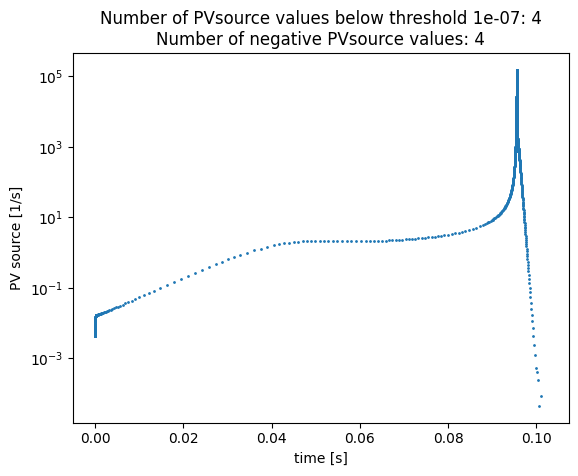

Number of PVsource values below 1e-07: 2


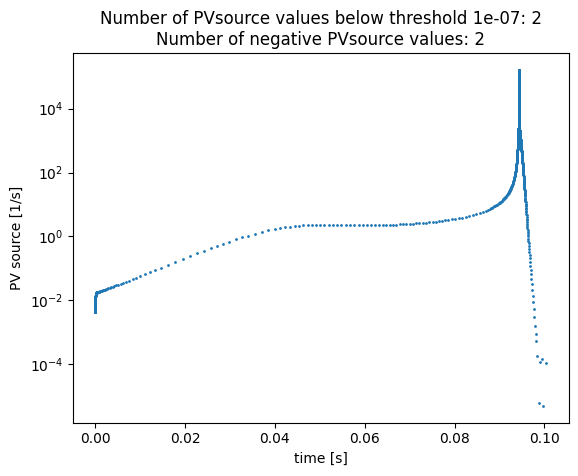

Number of PVsource values below 1e-07: 4


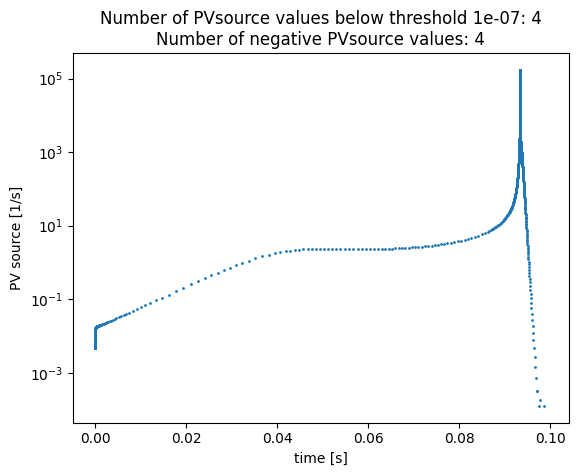

Number of PVsource values below 1e-07: 1


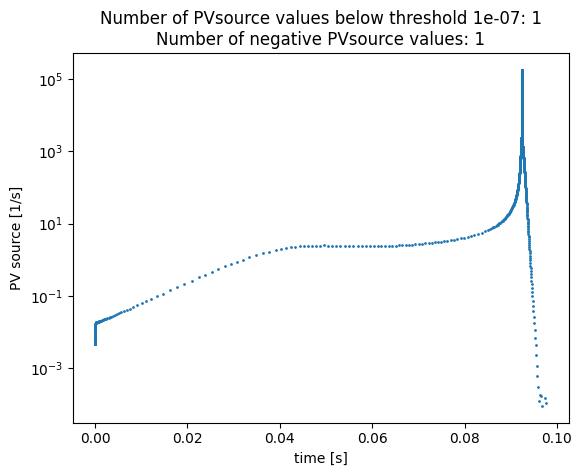

In [85]:
for i in range(10):
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        print(f"Number of PVsource values below 1e-07: {np.sum(PV_optimized_source_test<1e-07)}")
    
    plt.scatter(test_trajectory_time, PV_optimized_source_test, s = 1)
    plt.yscale("log")
    plt.title(f"Number of PVsource values below threshold 1e-07: {np.sum(PV_optimized_source_test<1e-07)}\nNumber of negative PVsource values: {np.sum(PV_optimized_source_test<0)}")
    plt.xlabel("time [s]")
    plt.ylabel("PV source [1/s]")
    plt.show()

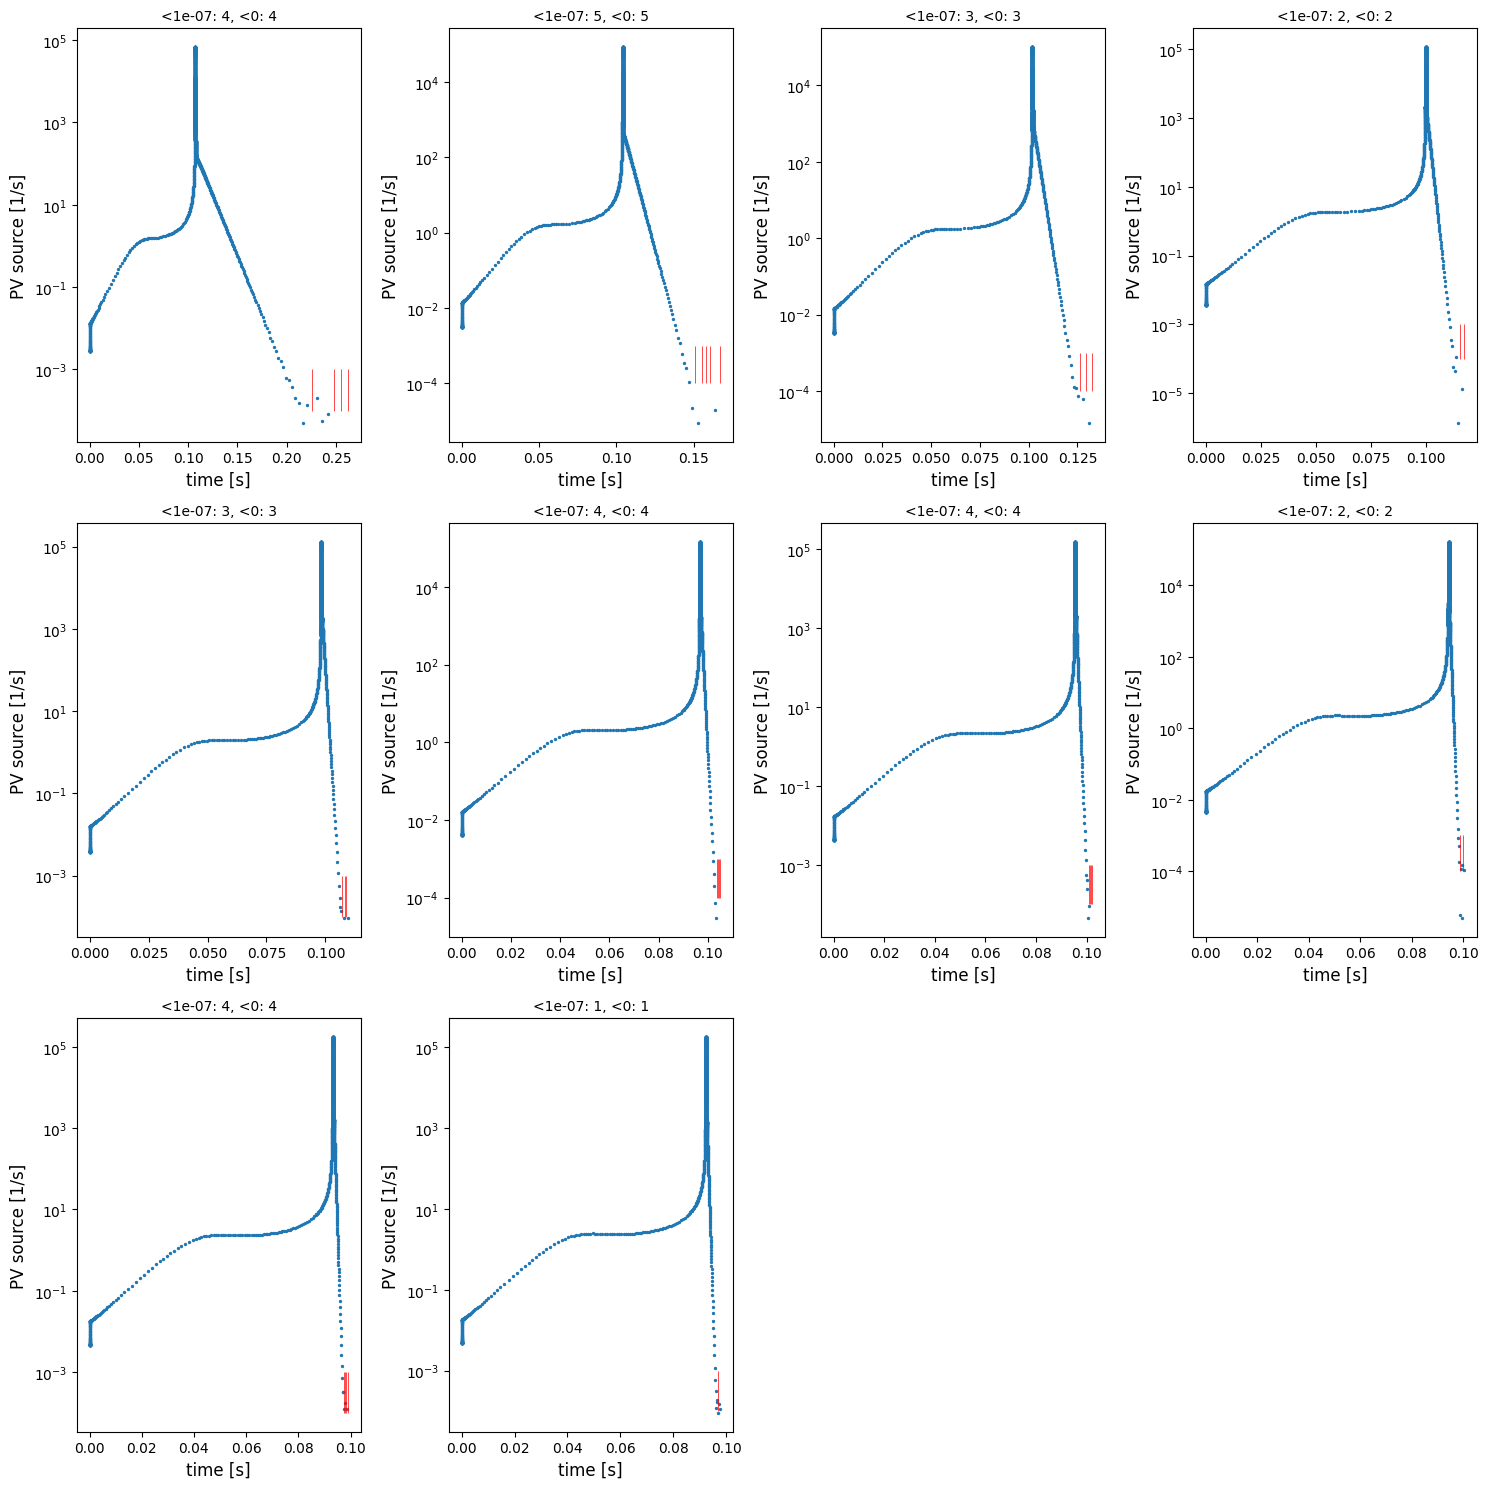

In [5]:
save = True
pathSave = "C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/Exploration/"
name = f"PVsource over time -see low PVsource values-{id_model} - indicator negative values.png"
pdfname = f"PVsource over time -see low PVsource values-{id_model} - indicator negative values.pdf"

# Number of test trajectories and subplot layout
num_test_trajectories = 10
rows, cols = 3, 4

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_test_trajectories):
    # Load time data
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    # Load state-space source data and compute PV source
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = model.get_PV(torch.from_numpy(
            np.delete(state_space_source_test_DNS, idx_species_removed, axis=1)
        )).detach().numpy()

    # Count stats
    below_threshold = np.sum(PV_optimized_source_test < 1e-07)
    below_zero = np.sum(PV_optimized_source_test < 0)

    # Plot in subplot
    ax = axes[i]
    ax.scatter(test_trajectory_time, PV_optimized_source_test, s=2)
    ax.set_yscale("log")
    ax.set_title(f"<1e-07: {below_threshold}, <0: {below_zero}", fontsize=10)
    ax.set_xlabel("time [s]", fontsize=12)
    ax.set_ylabel("PV source [1/s]", fontsize=12)
    ax.tick_params(labelsize=10)

    neg_time_stamps = test_trajectory_time[PV_optimized_source_test < 0]
    ax.vlines(neg_time_stamps, ymin=1e-04, ymax=1e-03, colors='red', linewidth=0.5)

# Hide unused subplots
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

# Adjust layout and save
plt.tight_layout()
if save:
    plt.savefig(pathSave + name, dpi=300)
    plt.savefig(pathSave + pdfname, format = "pdf")
plt.show()

## Effect of scaling - visualize different f-PV manifolds with the PV sparsification

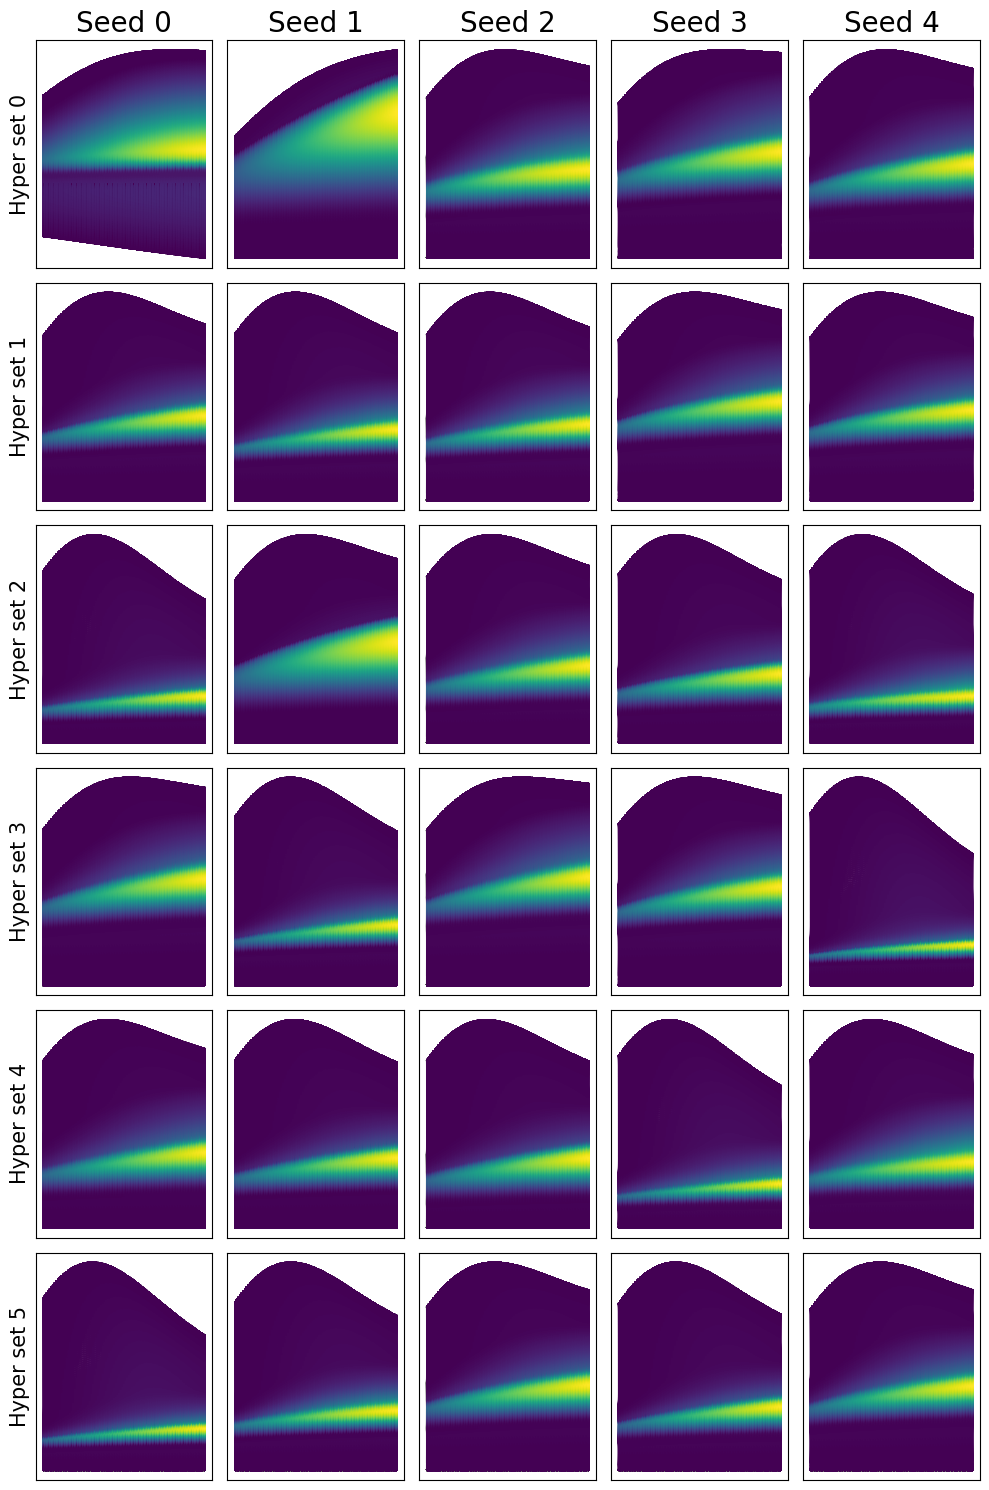

In [41]:
keysSpecies = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']
keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

nbrSeeds = 5



modelWithout = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_23Mar2025-hour_11h00_Tr0D-2pW_s",
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_22Mar2025-hour_23h09_Tr0D-2qW_s",
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h55_Tr0D-2rW_s",
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h57_Tr0D-2sW_s",
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h52_Tr0D-2tW_s",
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_25Mar2025-hour_09h54_Tr0D-2uW_s"]

modelWith = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h22_Tr0D-2p_s",
             "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s",
             "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h41_Tr0D-2r_s",
             "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s",
             "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_11h18_Tr0D-2t_s",
             "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_11h16_Tr0D-2u_s"]

rows, cols = len(modelWithout), nbrSeeds

Xu_optimized = "Optimized"

save = True
pathSave = f"C:/Users/admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect of scaling/f-PV manifold - Autoignition/"
nameFigure = f"f-PV manifolds - Autoignition - with scaling layer - seeds.png"

fig, axes = plt.subplots(rows, cols, figsize=(10, 15))  # Define the grid
axes = axes.flatten()

for idxName, nameModel in enumerate(modelWith):
    for idxSeeds in range(nbrSeeds):
        
        filename_model = f"{nameModel}{idxSeeds}"

        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = True
        if(weight_inversion and idxSeeds != 2):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

        #create a np array in the format for the DNS dataset/optimized PV
        state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
        state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

        PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_min_train = PV_optimized_train.min()
        PV_optimized_max_train = PV_optimized_train.max()
        PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
        f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
        f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
        PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()


        

        ax = axes[idxName*nbrSeeds + idxSeeds]
        
        random_idx = np.random.choice(len(PV_optimized_train), size=10000, replace=False)
        #ax.scatter(mixture_fractions_train[random_idx], PV_optimized_train[random_idx], c = PV_optimized_source_train[random_idx], cmap = "viridis", s=1)

        ax.scatter(mixture_fractions_train, PV_optimized_train, c = PV_optimized_source_train, cmap = "viridis", s=1)

        ax.set_xticks([]) 

        if(idxSeeds == 0):
            ax.set_ylabel(f'Hyper set {idxName}', fontsize = 15)
        ax.set_yticks([])

        if(idxName == 0):
            ax.set_title(f"Seed {idxSeeds}", fontsize=20)


handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
if(save):
        plt.savefig(f"{pathSave}{nameFigure}", dpi = 300, bbox_inches="tight")
plt.show()

### Visualize the overlapping of the PV

C:\Windows\Temp\ipykernel_5336\3612241287.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


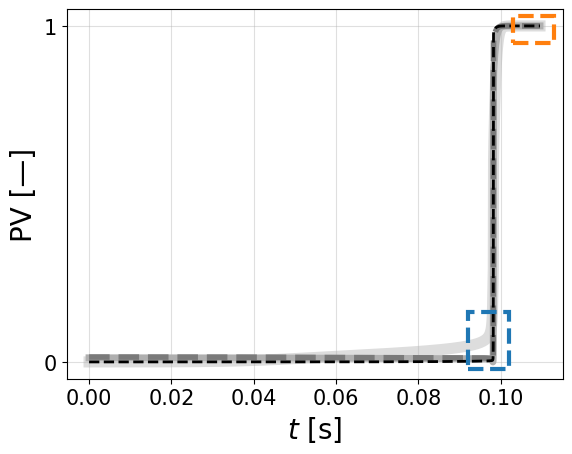

In [7]:
filename_modelsArray = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]
#["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]

#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0" #Without NOx
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx

PV_scaled_list = []

save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource with testTraj_betterAnnotated.png"

idxTraj = 4

greys = cm.get_cmap('Greys')
colorArray = [greys(1.0), greys(0.6), greys(0.42), greys(0.23)]
zorderArray = [4, 3, 2, 1]
linewidthArray = [2, 4, 5, 8]
linestyleArray = ["--", "--", "-", "-"]

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_Xu_test = test_trajectory["H2O"]- test_trajectory["O2"] - test_trajectory["H2"]
    PV_Xu_test_scaled = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    PV_scaled_list.append(PV_Xu_test_scaled)

    for filename_model in filename_modelsArray:
        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = True
        if(weight_inversion):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test_scaled = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
        PV_scaled_list.append(PV_optimized_test_scaled)

# Load time data
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:]).to_numpy()

timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    #log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    plt.plot(test_trajectory_time[timeMask], PV_optimized_test,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
plt.xlabel("$t$ [s]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks([0, 1], fontsize = 15)
#plt.xlim([timeTresh, 0.11])
#plt.ylim([0.99, 1])

plt.grid(True, linestyle='-', alpha=0.4)

ax = plt.gca()

frameCloseToIgnition = patches.Rectangle(
    (0.092, -0.02),                # (x, y) bottom-left corner
    0.102 - 0.092,             # width
    0.15 - (-0.02),                  # height
    linewidth=3,
    edgecolor='#1f77b4',
    linestyle = "--",
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax.add_patch(frameCloseToIgnition)

frameEndofTraj = patches.Rectangle(
    (0.103, 0.95),
    0.113 - 0.103,
    1.03 - 0.95,
    linewidth=3,
    linestyle = "--",
    edgecolor='#ff7f0e',
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax.add_patch(frameEndofTraj)


if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_6880\429638528.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


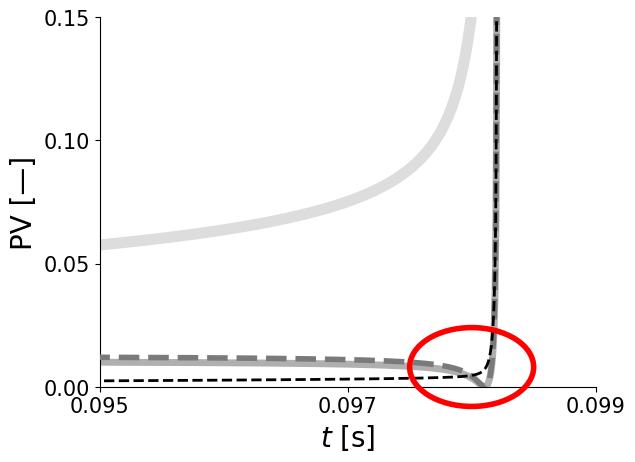

In [94]:
filename_modelsArray = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]
#["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]

#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0" #Without NOx
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx

PV_scaled_list = []

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect log QoI/PV vs time/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"PV vs time - different PVs - autoignition - before ignition.png"

idxTraj = 4

greys = cm.get_cmap('Greys')
colorArray = [greys(1.0), greys(0.6), greys(0.42), greys(0.23)]
zorderArray = [4, 3, 2, 1]
linewidthArray = [2, 4, 5, 8]
linestyleArray = ["--", "--", "-", "-"]

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_Xu_test = test_trajectory["H2O"]- test_trajectory["O2"] - test_trajectory["H2"]
    PV_Xu_test_scaled = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    PV_scaled_list.append(PV_Xu_test_scaled)

    for filename_model in filename_modelsArray:
        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = True
        if(weight_inversion):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test_scaled = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
        PV_scaled_list.append(PV_optimized_test_scaled)

# Load time data
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:]).to_numpy()

timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    #log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    plt.plot(test_trajectory_time[timeMask], PV_optimized_test,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
plt.xlabel("$t$ [s]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks([0.095, 0.097, 0.099], fontsize = 15)
plt.yticks([0, 0.05, 0.1, 0.15], fontsize = 15)
plt.xlim([0.095, 0.099])
plt.ylim([0, 0.15])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ellipse = patches.Ellipse((0.098, 0.008), width=0.001, height=0.032,
                          edgecolor='red', facecolor='none',
                          linewidth=4, zorder=100,
                          clip_on=False)
ax.add_patch(ellipse)

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_6880\505290713.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


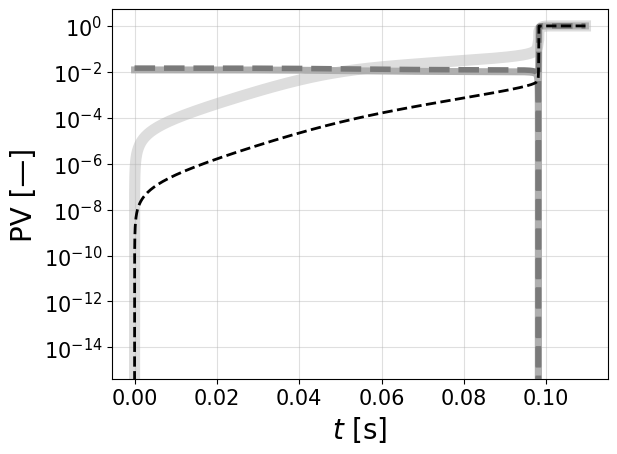

In [95]:
filename_modelsArray = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]
#["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]

#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0" #Without NOx
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx

PV_scaled_list = []

save = False
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"f-PV manifold-optimized-{id_model}-coloured-PVsource with testTraj_betterAnnotated.png"

idxTraj = 4

greys = cm.get_cmap('Greys')
colorArray = [greys(1.0), greys(0.6), greys(0.42), greys(0.23)]
zorderArray = [4, 3, 2, 1]
linewidthArray = [2, 4, 5, 8]
linestyleArray = ["--", "--", "-", "-"]


#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_Xu_test = test_trajectory["H2O"]- test_trajectory["O2"] - test_trajectory["H2"]
    PV_Xu_test_scaled = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    PV_scaled_list.append(PV_Xu_test_scaled)

    for filename_model in filename_modelsArray:
        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = True
        if(weight_inversion):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test_scaled = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
        PV_scaled_list.append(PV_optimized_test_scaled)

# Load time data
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:]).to_numpy()

timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    #log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    plt.plot(test_trajectory_time[timeMask], PV_optimized_test,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
plt.xlabel("$t$ [s]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks([0, 1], fontsize = 15)
#plt.xlim([timeTresh, 0.11])
#plt.ylim([0.99, 1])
plt.yscale("log")

plt.grid(True, linestyle='-', alpha=0.4)


if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_6880\2383260460.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


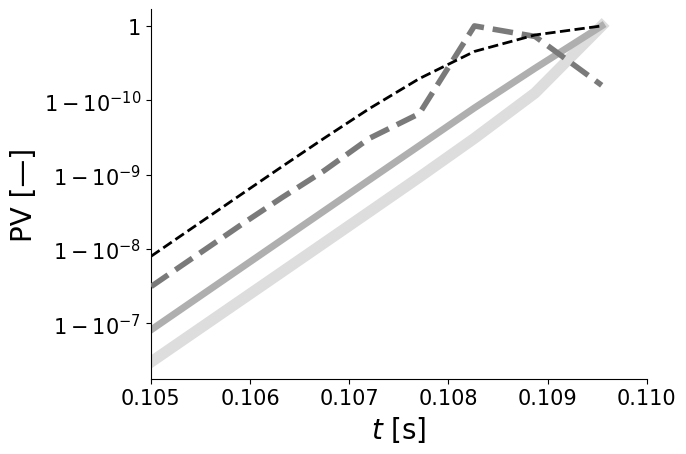

In [96]:
filename_modelsArray = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]
#["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", 
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0",
                        #"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"]

#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0" #Without NOx
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0" #With log(H2O2)
#"Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0" #With NOx

PV_scaled_list = []

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect log QoI/PV vs time/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"PV vs time - different PVs - autoignition - end of traj.png"

idxTraj = 4

greys = cm.get_cmap('Greys')
colorArray = [greys(1.0), greys(0.6), greys(0.42), greys(0.23)]
zorderArray = [4, 3, 2, 1]
linewidthArray = [2, 4, 5, 8]
linestyleArray = ["--", "--", "-", "-"]

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_Xu_test = test_trajectory["H2O"]- test_trajectory["O2"] - test_trajectory["H2"]
    PV_Xu_test_scaled = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    PV_scaled_list.append(PV_Xu_test_scaled)

    for filename_model in filename_modelsArray:
        filename_metadata = filename_model + "_metadata.pkl"
        path_metadata = "metadata/"
        filename_species_names = "Xu-state-space-names.csv"
        path_data = "data-files/"

        loader = loadData(filename_species_names, path_metadata, filename_metadata)
        idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
        id_model = loader.metadata["Training_id"]
        model = loader.loadModel()

        weight_inversion = True
        if(weight_inversion):
            with torch.no_grad():  # Ensures we do not track gradients for this operation
                model.encoder_species.weight.mul_(-1)

        PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        PV_optimized_test_scaled = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
        PV_scaled_list.append(PV_optimized_test_scaled)

# Load time data
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:]).to_numpy()

timeTresh = 0.105
timeMask = test_trajectory_time>timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    plt.plot(test_trajectory_time[timeMask], log_PV,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
plt.xlabel("$t$ [s]", fontsize = 20)
plt.ylabel("PV [\u2014]", fontsize = 20)
plt.xticks(fontsize = 15)
#plt.yticks([0, 1], fontsize = 15)
plt.xlim([timeTresh, 0.11])
#plt.ylim([0.99, 1])
from matplotlib.ticker import FuncFormatter

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

def pv_formatter(y, _):
    if y == 11:
        return "1"
    else:
        return f"$1 - 10^{{-{int(y)}}}$"

plt.gca().yaxis.set_major_formatter(FuncFormatter(pv_formatter))
plt.yticks(fontsize=15)

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

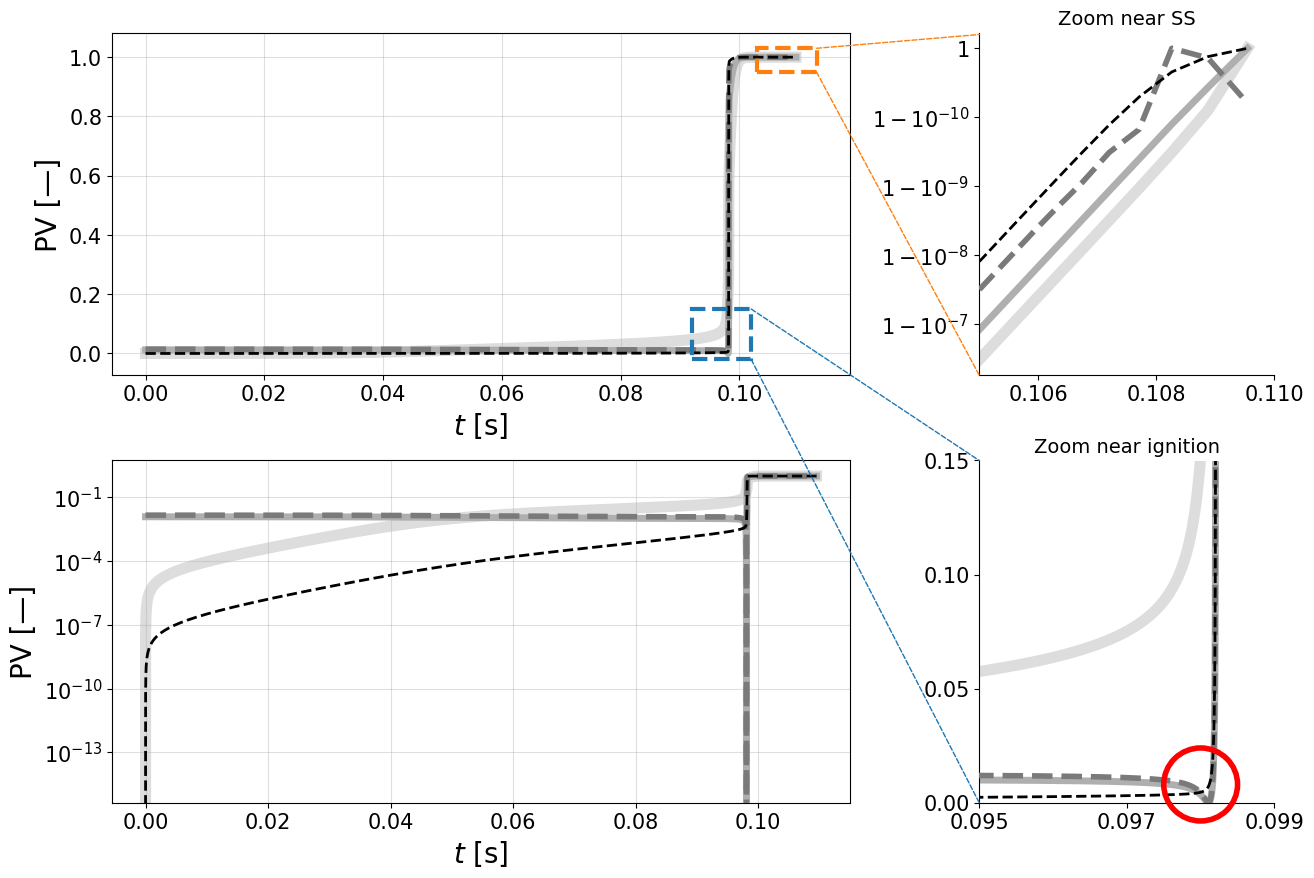

In [97]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.25, hspace=0.25)

# === Main plot ===
ax_main = fig.add_subplot(gs[0, 0])
timeTresh = 0
timeMask = test_trajectory_time>timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    ax_main.plot(test_trajectory_time[timeMask], PV[timeMask.squeeze()],
                 color=colorArray[idxModel],
                 linewidth=linewidthArray[idxModel],
                 zorder=zorderArray[idxModel],
                 linestyle=linestyleArray[idxModel])
ax_main.set_xlabel("$t$ [s]", fontsize=20)
ax_main.set_ylabel("PV [\u2014]", fontsize=20)
ax_main.tick_params(axis='both', labelsize=15)
ax_main.grid(True, linestyle='-', alpha=0.4)

# Add highlight rectangles
frameCloseToIgnition = patches.Rectangle(
    (0.092, -0.02),                # (x, y) bottom-left corner
    0.102 - 0.092,             # width
    0.15 - (-0.02),                  # height
    linewidth=3,
    edgecolor='#1f77b4',
    linestyle = "--",
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax_main.add_patch(frameCloseToIgnition)

frameEndofTraj = patches.Rectangle(
    (0.103, 0.95),
    0.113 - 0.103,
    1.03 - 0.95,
    linewidth=3,
    linestyle = "--",
    edgecolor='#ff7f0e',
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax_main.add_patch(frameEndofTraj)

# === Second main plot - log(y-axis) ===
ax_main2 = fig.add_subplot(gs[1, 0])
timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    #log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    ax_main2.plot(test_trajectory_time[timeMask], PV_optimized_test,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
ax_main2.set_xlabel("$t$ [s]", fontsize = 20)
ax_main2.set_ylabel("PV [\u2014]", fontsize = 20)
ax_main2.tick_params(axis='both', labelsize=15)
ax_main2.set_yticks([0, 1])
#plt.xlim([timeTresh, 0.11])
#plt.ylim([0.99, 1])
ax_main2.set_yscale("log")

ax_main2.grid(True, linestyle='-', alpha=0.4)

# === Zoom near ignition ===
ax_zoom1 = fig.add_subplot(gs[1, 1])
ax_zoom1.set_xlim(0.095, 0.099)
ax_zoom1.set_ylim(0, 0.15)
timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    ax_zoom1.plot(test_trajectory_time[timeMask], PV[timeMask.squeeze()],
                  color=colorArray[idxModel],
                  linewidth=linewidthArray[idxModel],
                  zorder=zorderArray[idxModel],
                  linestyle=linestyleArray[idxModel])
ax_zoom1.set_xticks([0.095, 0.097, 0.099])
ax_zoom1.set_yticks([0, 0.05, 0.1, 0.15])
ax_zoom1.tick_params(axis='both', labelsize=15)
ax_zoom1.set_title("Zoom near ignition", fontsize=14)
ax_zoom1.spines['top'].set_visible(False)
ax_zoom1.spines['right'].set_visible(False)

# Optional ellipse marker
ellipse = patches.Ellipse((0.098, 0.008), width=0.001, height=0.032,
                          edgecolor='red', facecolor='none',
                          linewidth=4, zorder=100, clip_on=False)
ax_zoom1.add_patch(ellipse)

# === Zoom near SS ===
ax_zoom2 = fig.add_subplot(gs[0, 1])
ax_zoom2.set_xlim(0.105, 0.11)
#ax_zoom2.set_ylim(0.95, 1.0)

timeTresh = 0.105
timeMask = test_trajectory_time>timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    log_PV = -np.log10(1 - PV[timeMask.squeeze()] + 1e-11)
    ax_zoom2.plot(test_trajectory_time[timeMask], log_PV,
                  color=colorArray[idxModel],
                  linewidth=linewidthArray[idxModel],
                  zorder=zorderArray[idxModel],
                  linestyle=linestyleArray[idxModel])
ax_zoom2.tick_params(axis='both', labelsize=15)
ax_zoom2.set_title("Zoom near SS", fontsize=14)
ax_zoom2.spines['top'].set_visible(False)
ax_zoom2.spines['right'].set_visible(False)
ax_zoom2.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: "1" if y == 11 else f"$1 - 10^{{-{int(y)}}}$"))

# === Connection lines ===
fig.add_artist(ConnectionPatch((0.102, -0.02), (0.095, 0), 'data', 'data',
                               axesA=ax_main, axesB=ax_zoom1,
                               color='#1f77b4', linestyle='--', linewidth=1))
fig.add_artist(ConnectionPatch((0.102, 0.15), (0.095, 0.15), 'data', 'data',
                               axesA=ax_main, axesB=ax_zoom1,
                               color='#1f77b4', linestyle='--', linewidth=1))
fig.add_artist(ConnectionPatch((0.113, 0.95), (0.105, 6.25), 'data', 'data',
                               axesA=ax_main, axesB=ax_zoom2,
                               color='#ff7f0e', linestyle='--', linewidth=1))
fig.add_artist(ConnectionPatch((0.113, 1.03), (0.105, 11.2), 'data', 'data',
                               axesA=ax_main, axesB=ax_zoom2,
                               color='#ff7f0e', linestyle='--', linewidth=1))

# fig.add_artist(ConnectionPatch((0.092, -0.02), (0.095, 0), 'data', 'data',
#                                axesA=ax_main, axesB=ax_zoom1,
#                                color='#1f77b4', linestyle='--', linewidth=1))
# fig.add_artist(ConnectionPatch((0.102, 0.15), (0.095, 0.15), 'data', 'data',
#                                axesA=ax_main, axesB=ax_zoom1,
#                                color='#1f77b4', linestyle='--', linewidth=1))
# fig.add_artist(ConnectionPatch((0.103, 0.95), (0.105, 6.25), 'data', 'data',
#                                axesA=ax_main, axesB=ax_zoom2,
#                                color='#ff7f0e', linestyle='--', linewidth=1))
# fig.add_artist(ConnectionPatch((0.113, 1.03), (0.105, 11.2), 'data', 'data',
#                                axesA=ax_main, axesB=ax_zoom2,
#                                color='#ff7f0e', linestyle='--', linewidth=1))

C:\Windows\Temp\ipykernel_6880\3993176795.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


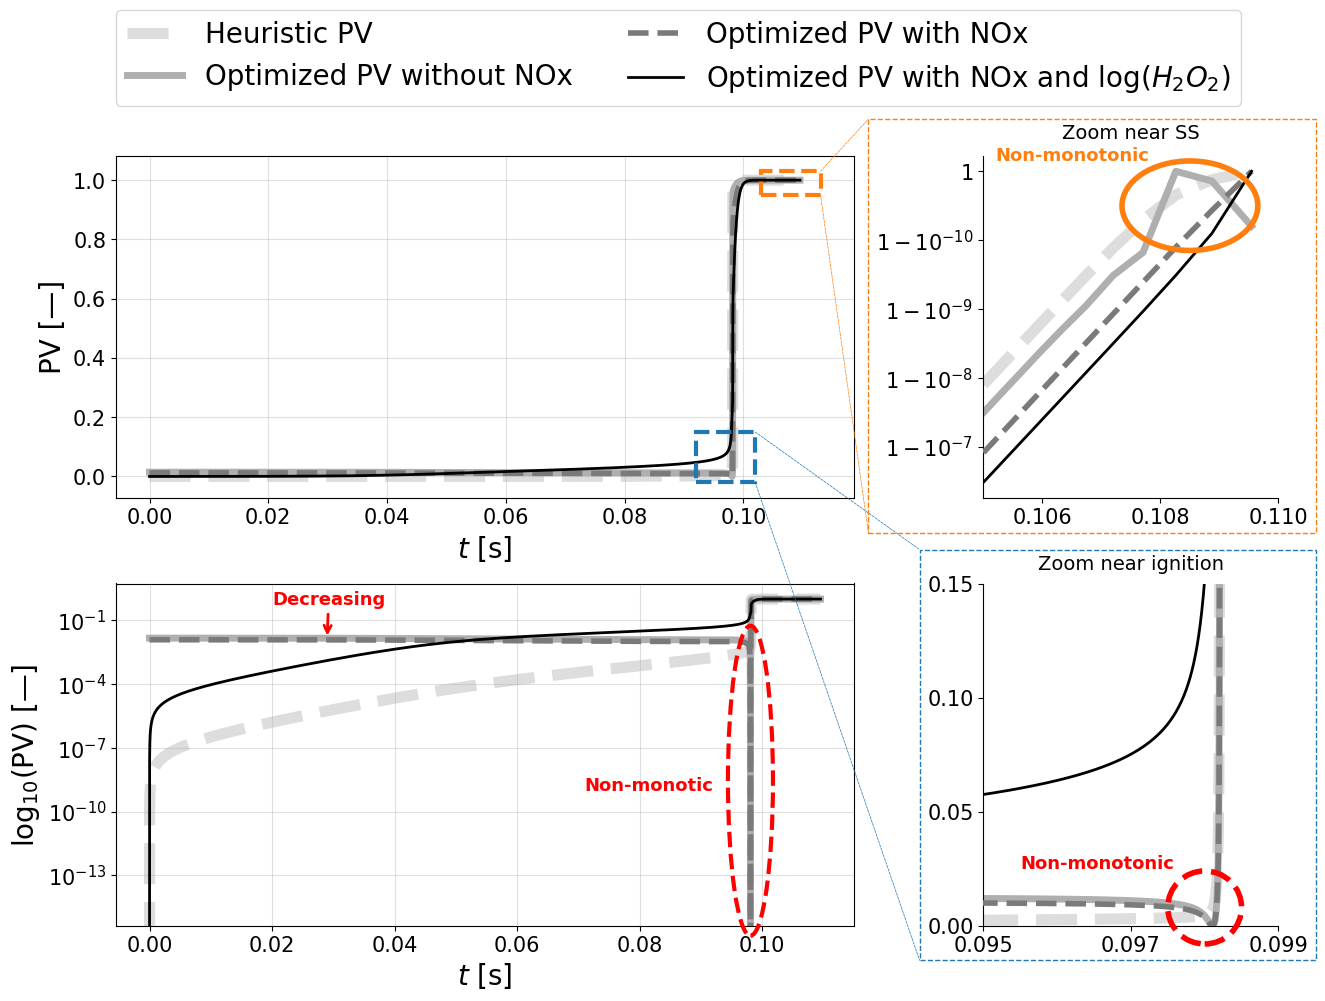

In [100]:
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1], wspace=0.25, hspace=0.25)

marginFrame = 0.005

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect log QoI/PV vs time/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"PV vs time - different PVs - autoignition - complete overview - v3.png"
namePDF = f"PV vs time - different PVs - autoignition - complete overview - v3.pdf"

labelsPVs = ["Heuristic PV","Optimized PV without NOx", "Optimized PV with NOx", "Optimized PV with NOx and log($H_2O_2$)"]

greys = cm.get_cmap('Greys')
colorArray = [greys(0.23),  greys(0.42), greys(0.6), greys(1.0)]
zorderArray = [1, 2, 3, 4]
linewidthArray = [8, 5, 4, 2]
linestyleArray = ["--", "-", "--", "-"]

###################
# === Main plot ===
###################

ax_main = fig.add_subplot(gs[0, 0])
timeTresh = 0
timeMask = test_trajectory_time>timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    ax_main.plot(test_trajectory_time[timeMask], PV[timeMask.squeeze()],
                 color=colorArray[idxModel],
                 linewidth=linewidthArray[idxModel],
                 zorder=zorderArray[idxModel],
                 linestyle=linestyleArray[idxModel])
ax_main.set_xlabel("$t$ [s]", fontsize=20)
ax_main.set_ylabel("PV [\u2014]", fontsize=20)
ax_main.tick_params(axis='both', labelsize=15)
ax_main.grid(True, linestyle='-', alpha=0.4)

# Add highlight rectangles
frameCloseToIgnition = patches.Rectangle(
    (0.092, -0.02),                # (x, y) bottom-left corner
    0.102 - 0.092,             # width
    0.15 - (-0.02),                  # height
    linewidth=3,
    edgecolor='#1f77b4',
    linestyle = "--",
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax_main.add_patch(frameCloseToIgnition)

frameEndofTraj = patches.Rectangle(
    (0.103, 0.95),
    0.113 - 0.103,
    1.03 - 0.95,
    linewidth=3,
    linestyle = "--",
    edgecolor='#ff7f0e',
    facecolor='none',
    zorder=100,
    clip_on=False
)
ax_main.add_patch(frameEndofTraj)




########################################
# === Second main plot - log(y-axis) ===
########################################

ax_main2 = fig.add_subplot(gs[1, 0])
timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV_optimized_test in enumerate(PV_scaled_list):
    #log_PV = -np.log10(1-PV_optimized_test[timeMask.squeeze()] + 1e-11)
    ax_main2.plot(test_trajectory_time[timeMask], PV_optimized_test,
             color = colorArray[idxModel],
             linewidth = linewidthArray[idxModel],
             zorder = zorderArray[idxModel],
             linestyle = linestyleArray[idxModel])
ax_main2.set_xlabel("$t$ [s]", fontsize = 20)
ax_main2.set_ylabel("log$_{10}$(PV) [\u2014]", fontsize = 20)
ax_main2.tick_params(axis='both', labelsize=15)
ax_main2.set_yticks([0, 1])
#plt.xlim([timeTresh, 0.11])
#plt.ylim([0.99, 1])
ax_main2.set_yscale("log")

ax_main2.grid(True, linestyle='-', alpha=0.4)

ellipse = patches.Ellipse((0.548, 0.255), 0.03, 0.31,  # center x/y, width, height
                          transform=fig.transFigure,
                          edgecolor='red', facecolor='none', linestyle = "--",
                          linewidth=3)
fig.patches.append(ellipse)

ax_main2.annotate("Non-monotic",
                  xy=(0.029, 0.014),             # Point to annotate
                  xytext=(0.071, 10**-9),        # Text position
                  color='red', fontsize=13,
                  fontweight='bold',
                  #arrowprops=dict(arrowstyle='->', color='red', lw=2),
                  zorder=120)

ax_main2.annotate("Decreasing",
                  xy=(0.029, 0.014),             # Point to annotate
                  xytext=(0.02, 0.55),        # Text position
                  color='red', fontsize=13,
                  fontweight='bold',
                  arrowprops=dict(arrowstyle='->', color='red', lw=2),
                  zorder=120)


#############################
# === Zoom near ignition ===
#############################

ax_nearIgn = fig.add_subplot(gs[1, 1])
ax_nearIgn.set_xlim(0.095, 0.099)
ax_nearIgn.set_ylim(0, 0.15)
timeTresh = 0
timeMask = test_trajectory_time>=timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    ax_nearIgn.plot(test_trajectory_time[timeMask], PV[timeMask.squeeze()],
                  color=colorArray[idxModel],
                  linewidth=linewidthArray[idxModel],
                  zorder=zorderArray[idxModel],
                  linestyle=linestyleArray[idxModel])
ax_nearIgn.set_xticks([0.095, 0.097, 0.099])
ax_nearIgn.set_yticks([0, 0.05, 0.1, 0.15])
ax_nearIgn.tick_params(axis='both', labelsize=15)
ax_nearIgn.set_title("Zoom near ignition", fontsize=14, pad=10)
ax_nearIgn.spines['top'].set_visible(False)
ax_nearIgn.spines['right'].set_visible(False)

# Need to draw the canvas to get correct positions
fig.canvas.draw()

# Get tight bounding boxes in display (pixel) coordinates
bbox_nearIgn = ax_nearIgn.get_tightbbox(fig.canvas.get_renderer())

# Transform to figure coordinates
bbox_nearIgn_fig = bbox_nearIgn.transformed(fig.transFigure.inverted())

# === Frame around Zoom 1 (near ignition) ===
nearIgn_fig_frame = patches.Rectangle(
    (bbox_nearIgn_fig.x0 - marginFrame, bbox_nearIgn_fig.y0 - marginFrame),
    bbox_nearIgn_fig.width + 2*marginFrame,
    bbox_nearIgn_fig.height + 2*marginFrame,
    transform=fig.transFigure,
    linewidth=1,
    edgecolor='#1f77b4',
    linestyle='--',
    facecolor='none',
    zorder=110
)
fig.patches.append(nearIgn_fig_frame)

# Optional ellipse marker
ellipse = patches.Ellipse((0.098, 0.008), width=0.001, height=0.032,
                          edgecolor='red', facecolor='none', linestyle = "--",
                          linewidth=4, zorder=100, clip_on=False)
ax_nearIgn.add_patch(ellipse)

ax_nearIgn.annotate("Non-monotonic",
                  xy=(0.098, 0.008),             # Point to annotate
                  xytext=(0.0955, 0.025),        # Text position
                  color='red', fontsize=13,
                  fontweight='bold',
                  #arrowprops=dict(arrowstyle='->', color='red', lw=2),
                  zorder=120)



######################
# === Zoom near SS ===
######################

ax_nearSS = fig.add_subplot(gs[0, 1])
ax_nearSS.set_xlim(0.105, 0.11)
#ax_zoom2.set_ylim(0.95, 1.0)

timeTresh = 0.105
timeMask = test_trajectory_time>timeTresh
for idxModel, PV in enumerate(PV_scaled_list):
    log_PV = -np.log10(1 - PV[timeMask.squeeze()] + 1e-11)
    ax_nearSS.plot(test_trajectory_time[timeMask], log_PV,
                  color=colorArray[idxModel],
                  linewidth=linewidthArray[idxModel],
                  zorder=zorderArray[idxModel],
                  linestyle=linestyleArray[idxModel])
ax_nearSS.tick_params(axis='both', labelsize=15)
ax_nearSS.set_title("Zoom near SS", fontsize=14, pad=12)
ax_nearSS.spines['top'].set_visible(False)
ax_nearSS.spines['right'].set_visible(False)
ax_nearSS.yaxis.set_major_formatter(FuncFormatter(
    lambda y, _: "1" if y == 11 else f"$1 - 10^{{-{int(y)}}}$"))

bbox_nearSS = ax_nearSS.get_tightbbox(fig.canvas.get_renderer())
bbox_nearSS_fig = bbox_nearSS.transformed(fig.transFigure.inverted())

# === Frame around Zoom 2 (near SS) ===
nearSS_fig_frame = patches.Rectangle(
    (bbox_nearSS_fig.x0 - marginFrame, bbox_nearSS_fig.y0 - marginFrame),
    bbox_nearSS_fig.width + 2*marginFrame,
    bbox_nearSS_fig.height + 2*marginFrame,
    transform=fig.transFigure,
    linewidth=1,
    edgecolor='#ff7f0e',
    linestyle='--',
    facecolor='none',
    zorder=110
)
fig.patches.append(nearSS_fig_frame)

ax_nearSS.annotate("Non-monotonic",
                  xy=(0.1082, 10.9),             # Point to annotate
                  xytext=(0.1052, 11.15),        # Text position
                  color='#ff7f0e', fontsize=13,
                  fontweight='bold',
                  #arrowprops=dict(arrowstyle='->', color='#ff7f0e', lw=2),
                  zorder=120)

ellipse = patches.Ellipse((0.1085, 10.5), width=0.0023, height=1.3,
                          edgecolor='#ff7f0e', facecolor='none',
                          linewidth=4, zorder=100, clip_on=False)
ax_nearSS.add_patch(ellipse)


##########################
# === Connection lines ===
##########################

fig.add_artist(ConnectionPatch((0.102, -0.02), (bbox_nearIgn_fig.x0 - marginFrame, bbox_nearIgn_fig.y0 - marginFrame),
                               coordsA='data', coordsB='figure fraction',
                               axesA=ax_main, axesB=None,
                               color='#1f77b4', linestyle='--', linewidth=0.5))

fig.add_artist(ConnectionPatch((0.102, 0.15), (bbox_nearIgn_fig.x0 - marginFrame, bbox_nearIgn_fig.y1 + marginFrame),
                               coordsA='data', coordsB='figure fraction',
                               axesA=ax_main, axesB=None,
                               color='#1f77b4', linestyle='--', linewidth=0.5))

fig.add_artist(ConnectionPatch((0.113, 0.95), (bbox_nearSS_fig.x0 - marginFrame, bbox_nearSS_fig.y0 - marginFrame),
                               coordsA='data', coordsB='figure fraction',
                               axesA=ax_main, axesB=None,
                               color='#ff7f0e', linestyle='--', linewidth=0.5))

fig.add_artist(ConnectionPatch((0.113, 1.03), (bbox_nearSS_fig.x0 - marginFrame, bbox_nearSS_fig.y1 + marginFrame),
                               coordsA='data', coordsB='figure fraction',
                               axesA=ax_main, axesB=None,
                               color='#ff7f0e', linestyle='--', linewidth=0.5))

legend_handles = [
    Line2D([0], [0],
           color=colorArray[i],
           linewidth=linewidthArray[i],
           linestyle=linestyleArray[i],
           label=labelsPVs[i])
    for i in range(len(labelsPVs))
]

# Add the legend to the top center of the figure
fig.legend(handles=legend_handles,
           loc='upper center',
           ncol=2,
           fontsize=20,
           frameon=True,
           bbox_to_anchor=(0.5, 1.04))

if save:
    plt.savefig(path + name, dpi = 1000, bbox_inches = "tight")
    plt.savefig(path + namePDF, bbox_inches = "tight")
plt.show()

## Visualize manifold coloured by NO for heuristic and different optimized PVs

In [8]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

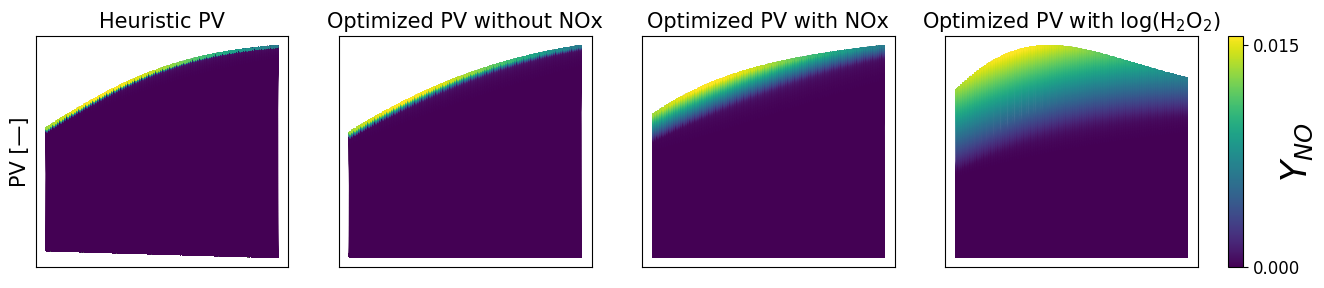

In [ ]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"Evolution NO distribution in f-PV manifolds - heuristic and optimized PVs - v3.png"

modelNames =   ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", #Without NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0", #With NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"] #With log(H2O2)]
PV_optimized_names = ["without NOx", "with NOx", "with log(H$_2$O$_2$)"]
weight_inversionArray = [True, True, True]

fig, axes = plt.subplots(1, 4, figsize=(15, 3))  # 1 row, 4 columns
axes = axes.flatten()

species_to_inspect = "NO"

ax_heu = axes[0]

ax_heu.scatter(mixture_fractions_train, PV_Xu_train, s=1, c=state_space_train[species_to_inspect])
ax_heu.set_title("Heuristic PV", fontsize = 15)
#ax_heu.set_xlabel("f [\u2014]", fontsize = 15, labelpad = -5)
ax_heu.set_ylabel("PV [\u2014]", fontsize = 15)
ax_heu.set_xticks([])
ax_heu.set_yticks([])
ax_heu.tick_params(axis='x', labelsize=12)


for idx, (ax, filename_model, PV_optimized_name) in enumerate(zip(axes[1:], modelNames, PV_optimized_names), start=0):

    filename_metadata = filename_model + "_metadata.pkl"
    path_metadata = "metadata/"
    filename_species_names = "Xu-state-space-names.csv"
    path_data = "data-files/"

    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
    id_model = loader.metadata["Training_id"]
    model = loader.loadModel()

    weight_inversion = weight_inversionArray[idx]
    if(weight_inversion):
        with torch.no_grad():  # Ensures we do not track gradients for this operation
            model.encoder_species.weight.mul_(-1)

    state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

    #create a np array in the format for the DNS dataset/optimized PV
    state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
    state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

    PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

    sc = ax.scatter(mixture_fractions_train, PV_optimized_train, s=1, c=state_space_train[species_to_inspect])
    ax.set_title(f"Optimized PV {PV_optimized_name}", fontsize = 15)   #PV$_{{\\mathrm{{opt}}}}$
    #ax.set_xlabel("f [\u2014]", fontsize = 15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=12)
    #ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad = -5)

    # if(idx == len(PV_optimized_names)-1):
    #     cbar = plt.colorbar(sc, ax=ax)  # Add colorbar
    #     cbar.set_label(f'$Y_{species_to_inspect}$', fontsize=15)
    #     cbar.ax.tick_params(labelsize=15)
        #cbar.set_ticks([0, 4000000])

cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(f'$Y_{{{species_to_inspect}}}$', fontsize=25, rotation = 90, labelpad = -15)
cbar.set_ticks([0, 0.015])

cbar.ax.tick_params(labelsize=12)

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

## Overview PV for NO

C:\Windows\Temp\ipykernel_9616\1154563823.py:94: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_9616\1154563823.py:210: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
2025-05-13 17:19:00 - DEBUG - vmin 4.885273571519382e-07 vmax 204.69682718075242
2025-05-13 17:19:00 - DEBUG - ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05])
2025-05-13 17:19:00 - DEBUG - vmin 4.885273571519382e-07 vmax 204.69682718075242
2025-05-13 17:19:00 - DEBUG - ticklocs array([], dtype=float64)
2025-05-13 17:19:00 - DEBUG - vmin 4.885273571519382e-07 vmax 204.69

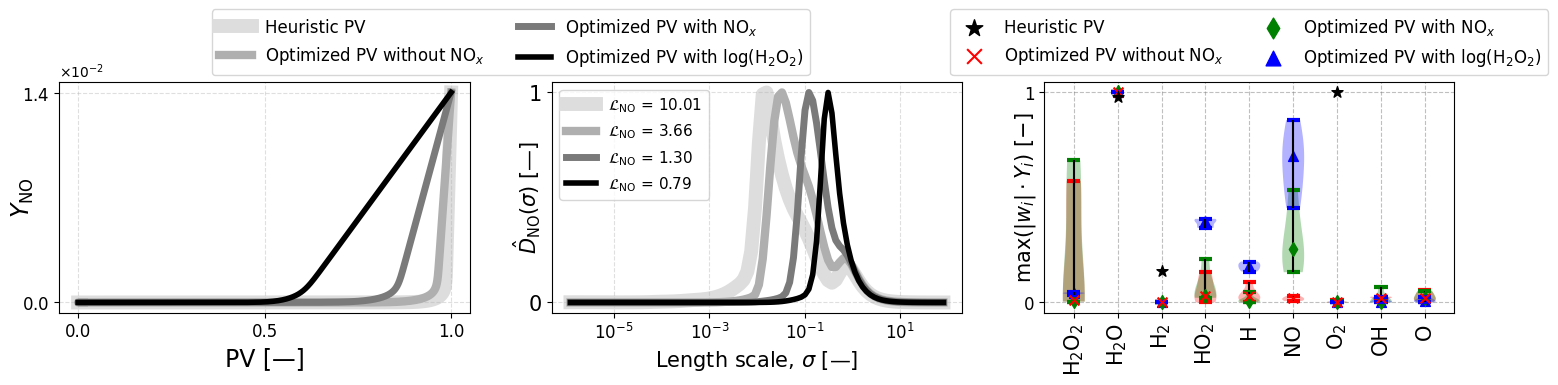

In [7]:
save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/Overview/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"NO vs PV - Dhat NO - weights - heuristic and optimized PVs.png"

rows, cols = 1, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 3))  # Define the grid
axes = axes.flatten()

species_to_inspect = "NO"

######################
# Model with log(H2O2)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

######################
# Model with NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withNOx.encoder_species.weight.mul_(-1)


######################
# Model without NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withoutNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withoutNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withoutNOx.encoder_species.weight.mul_(-1)


##################
# Import data

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

idxTraj = 4

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())
    PV_Xu_test = PV_Xu_test.to_numpy()

    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    PV_optimized_test_withNOx = model_withNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withNOx, axis=1))).detach().numpy()
    PV_optimized_test_withNOx = (PV_optimized_test_withNOx - PV_optimized_test_withNOx.min())/(PV_optimized_test_withNOx.max() - PV_optimized_test_withNOx.min())

    PV_optimized_test_withoutNOx = model_withoutNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withoutNOx, axis=1))).detach().numpy()
    PV_optimized_test_withoutNOx = (PV_optimized_test_withoutNOx - PV_optimized_test_withoutNOx.min())/(PV_optimized_test_withoutNOx.max() - PV_optimized_test_withoutNOx.min())


greys = cm.get_cmap('Greys')

list_greys = [greys(0.23), greys(0.42), greys(0.6), greys(1.0)]
list_linewidth = [10, 6, 5, 4]
list_zorder = [1, 2, 3, 4]

species_label = species_to_inspect.replace("2", "_{2}").replace("1", "_{source}")

ax_NOvsPV = axes[0]

trajSpecies = test_trajectory[species_to_inspect]
trajSpceciesOpt = test_trajectory[species_to_inspect]
trajSpceciesOpt_withNOx = test_trajectory[species_to_inspect]
trajSpceciesOpt_withoutNOx = test_trajectory[species_to_inspect]

ax_NOvsPV.plot(PV_Xu_test, trajSpecies, linewidth=list_linewidth[0], label = "Heuristic PV", color=list_greys[0], zorder=list_zorder[0])
ax_NOvsPV.plot(PV_optimized_test_withoutNOx, trajSpceciesOpt_withoutNOx, linewidth=list_linewidth[1], label = "Optimized PV without NO$_x$", color=list_greys[1], zorder=list_zorder[1])
ax_NOvsPV.plot(PV_optimized_test_withNOx, trajSpceciesOpt_withNOx, linewidth=list_linewidth[2], label = "Optimized PV with NO$_x$", color=list_greys[2], zorder=list_zorder[2])
ax_NOvsPV.plot(PV_optimized_test, trajSpceciesOpt, linewidth=list_linewidth[3], label = "Optimized PV with log(H$_2$O$_2$)", color=list_greys[3], zorder = list_zorder[3])

ax_NOvsPV.set_ylabel(f"$Y_{{\\mathrm{{{species_label}}}}}$", fontsize=17, labelpad = -10)
    
ax_NOvsPV.set_xticks([0, 0.5, 1])

ax_NOvsPV.tick_params(axis='y', labelsize=12)
ax_NOvsPV.tick_params(axis='x', labelsize=12)


#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
#ax_NOvsPV.yaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax_NOvsPV.set_yticks([0, 0.014])

ax_NOvsPV.set_xlabel(f"PV [\u2014]", fontsize = 17)

#if(idx_species%cols == 0):
    #ax.set_ylabel(f"$Y_{{{species_label}}}$ [\u2014]", fontsize = 17)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always use scientific notation
ax_NOvsPV.yaxis.set_major_formatter(formatter)

ax_NOvsPV.grid(True, linestyle='--', alpha=0.4)

handles, labels = ax_NOvsPV.get_legend_handles_labels()
ax_NOvsPV.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, frameon=True, bbox_to_anchor=(1.1, 1.35), markerscale=8)






##########################################################################################################################
########################################################## Dhat curves ###################################################
##########################################################################################################################

path_variance = "data-files/costs/"

name_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"


penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)

costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



variance_withNOx = np.load(f"{path_variance}{name_withNOx}", allow_pickle=True).item()

(derivative_withNOx, bandwidth_values_withNOx, max_derivative_withNOx) = normalized_variance_derivative(variance_withNOx)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithNOx = cost_function_normalized_variance_derivative(variance_withNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



seed_2v = 0
name_withoutNOx = f"variance_Tr0D-2v_s{seed_2v}-bw_-6_2_100-dataset_autoignition.npy"

variance_withoutNOx = np.load(f"{path_variance}{name_withoutNOx}", allow_pickle=True).item()

(derivative_withoutNOx, bandwidth_values_withoutNOx, max_derivative_withoutNOx) = normalized_variance_derivative(variance_withoutNOx)

costsWithoutNOx = cost_function_normalized_variance_derivative(variance_withoutNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

import matplotlib.cm as cm

# Get shades of grey from black (0) to white (1)
greys = cm.get_cmap('Greys')

ax_Dhat = axes[1]

idx = keys.index(species_to_inspect)

ax_Dhat.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
        linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsHeuristic_0D[idx]:.2f}", color=list_greys[0], zorder=list_zorder[0])
ax_Dhat.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
        linewidth=list_linewidth[1], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithoutNOx[idx]:.2f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
ax_Dhat.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
        linewidth=list_linewidth[2], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithNOx[idx]:.2f}", color=list_greys[2], zorder=list_zorder[2])
ax_Dhat.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
        linewidth=list_linewidth[3], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsOptimized_0D[idx]:.2f}", color=list_greys[3], zorder=list_zorder[3])
ax_Dhat.set_xscale("log")
ax_Dhat.grid(True, linestyle='--', alpha=0.4)

ax_Dhat.legend(loc = "upper left", fontsize = 11)


ax_Dhat.tick_params(axis="both", labelsize=12)
ax_Dhat.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)


ax_Dhat.set_yticks([0, 1])
ax_Dhat.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect}}}}}(\sigma)$" + " [\u2014]", fontsize = 15, labelpad = -10)

ax_Dhat.tick_params(axis="y", labelsize=15)









##########################################################################################################################
########################################################## WEIGHTS #######################################################
##########################################################################################################################

dataset = "autoignition"

abs = True #in absolute value otherwise jumps from -1 to 1/sign flips for the different species

path_state = path_data + f"Xu-state-space-{dataset}.csv"
nbrSeeds = 5

nameModels = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s",
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s",              
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s"]

########################
# Heuristic PV

my_species_Xu = Species(path_data)

list_species_Xu = my_species_Xu.get_list_species()
for index in sorted(idx_species_removed, reverse=True): #same species to remove
    list_species_Xu.pop(index)

final_weights_Xu = np.zeros(19)
final_weights_Xu[list_species_Xu.index("H2O")] = 1
final_weights_Xu[list_species_Xu.index("H2")] = -1
final_weights_Xu[list_species_Xu.index("O2")] = -1

#get mass fractions of species
state_space_Xu = pd.read_csv(path_state, header = "infer")
state_space_Xu = state_space_Xu.drop(state_space_Xu.columns[idx_species_removed], axis=1)
state_space_matrix_Xu = state_space_Xu.to_numpy()

wi_Yi_Xu = state_space_matrix_Xu*np.abs(final_weights_Xu) #|w_i|*Y_i
if(abs):
    max_wi_Yi_Xu = np.max(wi_Yi_Xu, axis = 0) #take max of every species
else:
    max_wi_Yi_Xu = np.sign(final_weights_Xu)*np.max(wi_Yi_Xu, axis = 0) #take max of every species

max_wi_Yi_scaled_Xu = max_wi_Yi_Xu/np.max(np.abs(max_wi_Yi_Xu))



weightsSpecies = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithoutNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))

#########################
# Start Figure
                 
for idxSeed in range(nbrSeeds):

    for idxModel, modelName in enumerate(nameModels):

        filename_model = f"{modelName}{idxSeed}"
        filename_metadata_0D = filename_model + "_metadata.pkl"

        loader_0D = loadData(filename_species_names, path_metadata, filename_metadata_0D)
        output_idx = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        idx_species_removed = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        input_scaling = loader_0D.metadata["input scaling"]
        input_species_scaling = loader_0D.metadata["input species scaling"]
        input_species_bias = loader_0D.metadata["input species bias"]
        range_mf  = loader_0D.metadata["range_mf"]
        depvar_names_species = loader_0D.metadata["list species output"]
        depvar_names_idx = loader_0D.metadata["output elements"]
        PV_dim = loader_0D.metadata["PV dim"]
        depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
        model_0D = loader_0D.loadModel()
        id = loader_0D.metadata["Training_id"]
        nbr_input_species = loader_0D.metadata["nbr input species"]

        final_weights = model_0D.get_total_encoder_weights(npy = True)[0]

        #get index spcies removed
        my_species = Species(path_data)

        list_species = my_species.get_list_species()
        for index in sorted(idx_species_removed, reverse=True):
            list_species.pop(index)

        #get mass fractions of species
        state_space = pd.read_csv(path_state, header = "infer")
        state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
        state_space_matrix = state_space.to_numpy()

        wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
        if(abs):
            max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species
        else:
            max_wi_Yi = np.sign(final_weights)*np.max(wi_Yi, axis = 0) #take max of every species

        max_wi_Yi_scaled = max_wi_Yi/np.max(np.abs(max_wi_Yi))

        if(idxModel == 0):
            weightsSpecies[idxSeed, :] = max_wi_Yi_scaled
        elif(idxModel == 1):
            weightsSpeciesWithNOx[idxSeed, :] = max_wi_Yi_scaled
        else:
            weightsSpeciesWithoutNOx[idxSeed, :] = max_wi_Yi_scaled


#################
#Plot the weights
#################

ax_weights = axes[2]

mediansWithoutNOx = np.median(weightsSpeciesWithoutNOx, axis=0)
mediansWithNOx = np.median(weightsSpeciesWithNOx, axis=0)
mediansWithLogH2O2 = np.median(weightsSpecies, axis=0)

valid_indices = [i for i in range(len(max_wi_Yi_scaled)) if np.abs(mediansWithoutNOx[i]) > 0.01 or np.abs(mediansWithNOx[i])>0.01 or np.abs(mediansWithLogH2O2[i])>0.01 or np.abs(max_wi_Yi_scaled_Xu[i]) > 0.01]


latex_species_list = np.array([s.replace('2', r'$_2$').replace('3', r'$_3$') for s in list_species])
latex_species_list_filtered = latex_species_list[valid_indices]

max_wi_Yi_scaled_Xu_filtered = max_wi_Yi_scaled_Xu[valid_indices]

non_zero_mask = max_wi_Yi_scaled_Xu_filtered != 0
positions = np.arange(len(max_wi_Yi_scaled_Xu_filtered))


# Heuristic PV
ax_weights.scatter(
    np.arange(len(max_wi_Yi_scaled_Xu_filtered))[non_zero_mask],
    max_wi_Yi_scaled_Xu_filtered[non_zero_mask],
    color="k", label="Heuristic PV", marker="*", s=70, zorder = 4
)




# Without NOx
violinWithout = ax_weights.violinplot(weightsSpeciesWithoutNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWithout["bodies"]:
    element.set_facecolor("red")
    element.set_linewidth(10)
violinWithout['cmins'].set_color('red')
violinWithout['cmaxes'].set_color('red')
violinWithout['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithoutNOx[:, valid_indices], axis=0)

violinWithout['cmaxes'].set_linewidth(3)
violinWithout['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWithout['cmins'].get_segments(), violinWithout['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWithout['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmins'].get_segments(), positions)
    ])
    violinWithout['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmaxes'].get_segments(), positions)
    ])


ax_weights.scatter(positions, medians, color = "red", marker='x', s=50, zorder=3, label='Optimized PV without NO$_x$') #red  greys(0.6)





# With NOx
violinWith = ax_weights.violinplot(weightsSpeciesWithNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWith["bodies"]:
    element.set_facecolor("green")
    element.set_linewidth(10)
violinWith['cmins'].set_color('green')
violinWith['cmaxes'].set_color('green')
violinWith['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithNOx[:, valid_indices], axis=0)

violinWith['cmaxes'].set_linewidth(3)
violinWith['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWith['cmins'].get_segments(), violinWith['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWith['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmins'].get_segments(), positions)
    ])
    violinWith['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmaxes'].get_segments(), positions)
    ])

plt.scatter(positions, medians, color="green", marker='d', s=50, zorder=2, label='Optimized PV with NO$_x$') #green   greys(0.42)






# With NOx and log(H2O2)
violin = ax_weights.violinplot(weightsSpecies[:, valid_indices], positions, widths = 0.5)
for element in violin["bodies"]:
    element.set_facecolor("blue")
    element.set_linewidth(10)
violin['cmins'].set_color('blue')
violin['cmaxes'].set_color('blue')
violin['cbars'].set_color('black')
medians = np.median(weightsSpecies[:, valid_indices], axis=0)

violin['cmaxes'].set_linewidth(3)
violin['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violin['cmins'].get_segments(), violin['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violin['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmins'].get_segments(), positions)
    ])
    violin['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmaxes'].get_segments(), positions)
    ])
ax_weights.scatter(positions, medians, color= "blue", marker='^', s=50, zorder=1, label='Optimized PV with log(H$_2$O$_2$)') #blue   greys(0.23)







if abs:
    ax_weights.set_ylabel(r"max($|w_i| \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
else:
    ax_weights.set_ylabel(r"max($w_i \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
ax_weights.set_yticks([0, 1])
ax_weights.tick_params(axis='y', labelsize=12)

ax_weights.set_xticks(np.arange(len(max_wi_Yi_scaled_Xu_filtered)), latex_species_list_filtered, fontsize=15, rotation=90)
ax_weights.grid(True, linestyle='--', color='gray', alpha=0.5)

ax_weights.legend(fontsize=12,  ncol=2, loc = "upper center", bbox_to_anchor=(0.5, 1.35), scatterpoints=1, markerscale=1.5)





if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_13468\443282555.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_13468\443282555.py:222: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


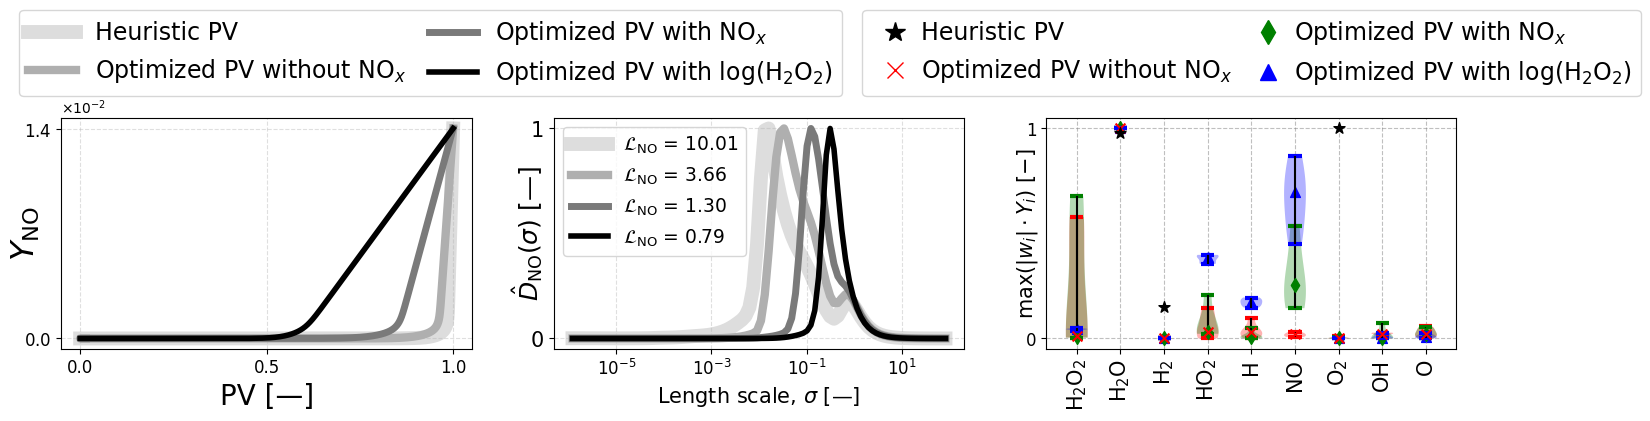

In [56]:
save = True

nbr_PVs = 4

path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/Overview/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"NO vs PV - Dhat NO - weights - heuristic and optimized PVs - PRESENTATION{nbr_PVs}.png"

rows, cols = 1, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 3))  # Define the grid
axes = axes.flatten()

species_to_inspect = "NO"

######################
# Model with log(H2O2)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

######################
# Model with NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withNOx.encoder_species.weight.mul_(-1)


######################
# Model without NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withoutNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withoutNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withoutNOx.encoder_species.weight.mul_(-1)


##################
# Import data

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

idxTraj = 4

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())
    PV_Xu_test = PV_Xu_test.to_numpy()

    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    PV_optimized_test_withNOx = model_withNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withNOx, axis=1))).detach().numpy()
    PV_optimized_test_withNOx = (PV_optimized_test_withNOx - PV_optimized_test_withNOx.min())/(PV_optimized_test_withNOx.max() - PV_optimized_test_withNOx.min())

    PV_optimized_test_withoutNOx = model_withoutNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withoutNOx, axis=1))).detach().numpy()
    PV_optimized_test_withoutNOx = (PV_optimized_test_withoutNOx - PV_optimized_test_withoutNOx.min())/(PV_optimized_test_withoutNOx.max() - PV_optimized_test_withoutNOx.min())


greys = cm.get_cmap('Greys')

list_greys = [greys(0.23), greys(0.42), greys(0.6), greys(1.0)]
list_linewidth = [10, 6, 5, 4]
list_zorder = [1, 2, 3, 4]

species_label = species_to_inspect.replace("2", "_{2}").replace("1", "_{source}")

ax_NOvsPV = axes[0]

trajSpecies = test_trajectory[species_to_inspect]
trajSpceciesOpt = test_trajectory[species_to_inspect]
trajSpceciesOpt_withNOx = test_trajectory[species_to_inspect]
trajSpceciesOpt_withoutNOx = test_trajectory[species_to_inspect]

if(nbr_PVs>=1):
    ax_NOvsPV.plot(PV_Xu_test, trajSpecies, linewidth=list_linewidth[0], label = "Heuristic PV", color=list_greys[0], zorder=list_zorder[0])
if(nbr_PVs>=2):
    ax_NOvsPV.plot(PV_optimized_test_withoutNOx, trajSpceciesOpt_withoutNOx, linewidth=list_linewidth[1], label = "Optimized PV without NO$_x$", color=list_greys[1], zorder=list_zorder[1])
if(nbr_PVs>=3):
    ax_NOvsPV.plot(PV_optimized_test_withNOx, trajSpceciesOpt_withNOx, linewidth=list_linewidth[2], label = "Optimized PV with NO$_x$", color=list_greys[2], zorder=list_zorder[2])
if(nbr_PVs>=4):
    ax_NOvsPV.plot(PV_optimized_test, trajSpceciesOpt, linewidth=list_linewidth[3], label = "Optimized PV with log(H$_2$O$_2$)", color=list_greys[3], zorder = list_zorder[3])

ax_NOvsPV.set_ylabel(f"$Y_{{\\mathrm{{{species_label}}}}}$", fontsize=23, labelpad = -13)
    
ax_NOvsPV.set_xticks([0, 0.5, 1])

ax_NOvsPV.tick_params(axis='y', labelsize=12)
ax_NOvsPV.tick_params(axis='x', labelsize=12)


#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
#ax_NOvsPV.yaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax_NOvsPV.set_yticks([0, 0.014])

ax_NOvsPV.set_xlabel(f"PV [\u2014]", fontsize = 20)

#if(idx_species%cols == 0):
    #ax.set_ylabel(f"$Y_{{{species_label}}}$ [\u2014]", fontsize = 17)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always use scientific notation
ax_NOvsPV.yaxis.set_major_formatter(formatter)

ax_NOvsPV.grid(True, linestyle='--', alpha=0.4)

legend_lines = [
    Line2D([0], [0], color=list_greys[0], linewidth=list_linewidth[0], label="Heuristic PV", zorder=list_zorder[0]),
    Line2D([0], [0], color=list_greys[1], linewidth=list_linewidth[1], label="Optimized PV without NO$_x$", zorder=list_zorder[1]),
    Line2D([0], [0], color=list_greys[2], linewidth=list_linewidth[2], label="Optimized PV with NO$_x$", zorder=list_zorder[2]),
    Line2D([0], [0], color=list_greys[3], linewidth=list_linewidth[3], label="Optimized PV with log(H$_2$O$_2$)", zorder=list_zorder[3]),
]
ax_NOvsPV.legend(legend_lines, [line.get_label() for line in legend_lines], loc='upper center', ncol=2, fontsize=17, frameon=True, bbox_to_anchor=(0.9, 1.52), markerscale=8, columnspacing=1)






##########################################################################################################################
########################################################## Dhat curves ###################################################
##########################################################################################################################

path_variance = "data-files/costs/"

name_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"


penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)

costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



variance_withNOx = np.load(f"{path_variance}{name_withNOx}", allow_pickle=True).item()

(derivative_withNOx, bandwidth_values_withNOx, max_derivative_withNOx) = normalized_variance_derivative(variance_withNOx)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithNOx = cost_function_normalized_variance_derivative(variance_withNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



seed_2v = 0
name_withoutNOx = f"variance_Tr0D-2v_s{seed_2v}-bw_-6_2_100-dataset_autoignition.npy"

variance_withoutNOx = np.load(f"{path_variance}{name_withoutNOx}", allow_pickle=True).item()

(derivative_withoutNOx, bandwidth_values_withoutNOx, max_derivative_withoutNOx) = normalized_variance_derivative(variance_withoutNOx)

costsWithoutNOx = cost_function_normalized_variance_derivative(variance_withoutNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

import matplotlib.cm as cm

# Get shades of grey from black (0) to white (1)
greys = cm.get_cmap('Greys')

ax_Dhat = axes[1]

idx = keys.index(species_to_inspect)

if(nbr_PVs>=1):
    ax_Dhat.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
        linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsHeuristic_0D[idx]:.2f}", color=list_greys[0], zorder=list_zorder[0])
if(nbr_PVs>=2):
    ax_Dhat.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
        linewidth=list_linewidth[1], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithoutNOx[idx]:.2f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
if(nbr_PVs>=3):
    ax_Dhat.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
        linewidth=list_linewidth[2], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithNOx[idx]:.2f}", color=list_greys[2], zorder=list_zorder[2])
if(nbr_PVs>=4):
    ax_Dhat.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
        linewidth=list_linewidth[3], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsOptimized_0D[idx]:.2f}", color=list_greys[3], zorder=list_zorder[3])
ax_Dhat.set_xscale("log")
ax_Dhat.grid(True, linestyle='--', alpha=0.4)

ax_Dhat.legend(loc = "upper left", fontsize = 13.5)


ax_Dhat.tick_params(axis="both", labelsize=12)
ax_Dhat.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)


ax_Dhat.set_yticks([0, 1])
ax_Dhat.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect}}}}}(\sigma)$" + " [\u2014]", fontsize = 18, labelpad = -10)

ax_Dhat.tick_params(axis="y", labelsize=15)









##########################################################################################################################
########################################################## WEIGHTS #######################################################
##########################################################################################################################

dataset = "autoignition"

abs = True #in absolute value otherwise jumps from -1 to 1/sign flips for the different species

path_state = path_data + f"Xu-state-space-{dataset}.csv"
nbrSeeds = 5

nameModels = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s",
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s",              
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s"]

########################
# Heuristic PV

my_species_Xu = Species(path_data)

list_species_Xu = my_species_Xu.get_list_species()
for index in sorted(idx_species_removed, reverse=True): #same species to remove
    list_species_Xu.pop(index)

final_weights_Xu = np.zeros(19)
final_weights_Xu[list_species_Xu.index("H2O")] = 1
final_weights_Xu[list_species_Xu.index("H2")] = -1
final_weights_Xu[list_species_Xu.index("O2")] = -1

#get mass fractions of species
state_space_Xu = pd.read_csv(path_state, header = "infer")
state_space_Xu = state_space_Xu.drop(state_space_Xu.columns[idx_species_removed], axis=1)
state_space_matrix_Xu = state_space_Xu.to_numpy()

wi_Yi_Xu = state_space_matrix_Xu*np.abs(final_weights_Xu) #|w_i|*Y_i
if(abs):
    max_wi_Yi_Xu = np.max(wi_Yi_Xu, axis = 0) #take max of every species
else:
    max_wi_Yi_Xu = np.sign(final_weights_Xu)*np.max(wi_Yi_Xu, axis = 0) #take max of every species

max_wi_Yi_scaled_Xu = max_wi_Yi_Xu/np.max(np.abs(max_wi_Yi_Xu))



weightsSpecies = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithoutNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))

#########################
# Start Figure
                 
for idxSeed in range(nbrSeeds):

    for idxModel, modelName in enumerate(nameModels):

        filename_model = f"{modelName}{idxSeed}"
        filename_metadata_0D = filename_model + "_metadata.pkl"

        loader_0D = loadData(filename_species_names, path_metadata, filename_metadata_0D)
        output_idx = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        idx_species_removed = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        input_scaling = loader_0D.metadata["input scaling"]
        input_species_scaling = loader_0D.metadata["input species scaling"]
        input_species_bias = loader_0D.metadata["input species bias"]
        range_mf  = loader_0D.metadata["range_mf"]
        depvar_names_species = loader_0D.metadata["list species output"]
        depvar_names_idx = loader_0D.metadata["output elements"]
        PV_dim = loader_0D.metadata["PV dim"]
        depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
        model_0D = loader_0D.loadModel()
        id = loader_0D.metadata["Training_id"]
        nbr_input_species = loader_0D.metadata["nbr input species"]

        final_weights = model_0D.get_total_encoder_weights(npy = True)[0]

        #get index spcies removed
        my_species = Species(path_data)

        list_species = my_species.get_list_species()
        for index in sorted(idx_species_removed, reverse=True):
            list_species.pop(index)

        #get mass fractions of species
        state_space = pd.read_csv(path_state, header = "infer")
        state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
        state_space_matrix = state_space.to_numpy()

        wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
        if(abs):
            max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species
        else:
            max_wi_Yi = np.sign(final_weights)*np.max(wi_Yi, axis = 0) #take max of every species

        max_wi_Yi_scaled = max_wi_Yi/np.max(np.abs(max_wi_Yi))

        if(idxModel == 0):
            weightsSpecies[idxSeed, :] = max_wi_Yi_scaled
        elif(idxModel == 1):
            weightsSpeciesWithNOx[idxSeed, :] = max_wi_Yi_scaled
        else:
            weightsSpeciesWithoutNOx[idxSeed, :] = max_wi_Yi_scaled


#################
#Plot the weights
#################

ax_weights = axes[2]

mediansWithoutNOx = np.median(weightsSpeciesWithoutNOx, axis=0)
mediansWithNOx = np.median(weightsSpeciesWithNOx, axis=0)
mediansWithLogH2O2 = np.median(weightsSpecies, axis=0)

valid_indices = [i for i in range(len(max_wi_Yi_scaled)) if np.abs(mediansWithoutNOx[i]) > 0.01 or np.abs(mediansWithNOx[i])>0.01 or np.abs(mediansWithLogH2O2[i])>0.01 or np.abs(max_wi_Yi_scaled_Xu[i]) > 0.01]


latex_species_list = np.array([s.replace('2', r'$_2$').replace('3', r'$_3$') for s in list_species])
latex_species_list_filtered = latex_species_list[valid_indices]

max_wi_Yi_scaled_Xu_filtered = max_wi_Yi_scaled_Xu[valid_indices]

non_zero_mask = max_wi_Yi_scaled_Xu_filtered != 0
positions = np.arange(len(max_wi_Yi_scaled_Xu_filtered))


# Heuristic PV
ax_weights.scatter(
    np.arange(len(max_wi_Yi_scaled_Xu_filtered))[non_zero_mask],
    max_wi_Yi_scaled_Xu_filtered[non_zero_mask],
    color="k", label="Heuristic PV", marker="*", s=70, zorder = 4
)



if(nbr_PVs>=2):
    # Without NOx
    violinWithout = ax_weights.violinplot(weightsSpeciesWithoutNOx[:, valid_indices], positions, widths = 0.5)
    for element in violinWithout["bodies"]:
        element.set_facecolor("red")
        element.set_linewidth(10)
    violinWithout['cmins'].set_color('red')
    violinWithout['cmaxes'].set_color('red')
    violinWithout['cbars'].set_color('black')
    medians = np.median(weightsSpeciesWithoutNOx[:, valid_indices], axis=0)

    violinWithout['cmaxes'].set_linewidth(3)
    violinWithout['cmins'].set_linewidth(3)

    for i, (cmin, cmax) in enumerate(zip(violinWithout['cmins'].get_segments(), violinWithout['cmaxes'].get_segments())):
        # Extract y-values (vertical limits)
        y_min = cmin[0][1]
        y_max = cmax[0][1]

        # Use actual position
        x_center = positions[i]
        width = 0.15  # desired width of the extrema bars

        # Set new segments for min and max bars
        violinWithout['cmins'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violinWithout['cmins'].get_segments(), positions)
        ])
        violinWithout['cmaxes'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violinWithout['cmaxes'].get_segments(), positions)
        ])


    ax_weights.scatter(positions, medians, color = "red", marker='x', s=50, zorder=3, label='Optimized PV without NO$_x$') #red  greys(0.6)




if(nbr_PVs>=3):
    # With NOx
    violinWith = ax_weights.violinplot(weightsSpeciesWithNOx[:, valid_indices], positions, widths = 0.5)
    for element in violinWith["bodies"]:
        element.set_facecolor("green")
        element.set_linewidth(10)
    violinWith['cmins'].set_color('green')
    violinWith['cmaxes'].set_color('green')
    violinWith['cbars'].set_color('black')
    medians = np.median(weightsSpeciesWithNOx[:, valid_indices], axis=0)

    violinWith['cmaxes'].set_linewidth(3)
    violinWith['cmins'].set_linewidth(3)

    for i, (cmin, cmax) in enumerate(zip(violinWith['cmins'].get_segments(), violinWith['cmaxes'].get_segments())):
        # Extract y-values (vertical limits)
        y_min = cmin[0][1]
        y_max = cmax[0][1]

        # Use actual position
        x_center = positions[i]
        width = 0.15  # desired width of the extrema bars

        # Set new segments for min and max bars
        violinWith['cmins'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violinWith['cmins'].get_segments(), positions)
        ])
        violinWith['cmaxes'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violinWith['cmaxes'].get_segments(), positions)
        ])

    plt.scatter(positions, medians, color="green", marker='d', s=50, zorder=2, label='Optimized PV with NO$_x$') #green   greys(0.42)





if(nbr_PVs>=4):
    # With NOx and log(H2O2)
    violin = ax_weights.violinplot(weightsSpecies[:, valid_indices], positions, widths = 0.5)
    for element in violin["bodies"]:
        element.set_facecolor("blue")
        element.set_linewidth(10)
    violin['cmins'].set_color('blue')
    violin['cmaxes'].set_color('blue')
    violin['cbars'].set_color('black')
    medians = np.median(weightsSpecies[:, valid_indices], axis=0)

    violin['cmaxes'].set_linewidth(3)
    violin['cmins'].set_linewidth(3)

    for i, (cmin, cmax) in enumerate(zip(violin['cmins'].get_segments(), violin['cmaxes'].get_segments())):
        # Extract y-values (vertical limits)
        y_min = cmin[0][1]
        y_max = cmax[0][1]

        # Use actual position
        x_center = positions[i]
        width = 0.15  # desired width of the extrema bars

        # Set new segments for min and max bars
        violin['cmins'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violin['cmins'].get_segments(), positions)
        ])
        violin['cmaxes'].set_segments([
            [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
            for seg, x_center in zip(violin['cmaxes'].get_segments(), positions)
        ])
    ax_weights.scatter(positions, medians, color= "blue", marker='^', s=50, zorder=1, label='Optimized PV with log(H$_2$O$_2$)') #blue   greys(0.23)







if abs:
    ax_weights.set_ylabel(r"max($|w_i| \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
else:
    ax_weights.set_ylabel(r"max($w_i \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
ax_weights.set_yticks([0, 1])
ax_weights.tick_params(axis='y', labelsize=12)

ax_weights.set_xticks(np.arange(len(max_wi_Yi_scaled_Xu_filtered)), latex_species_list_filtered, fontsize=15, rotation=90)
ax_weights.set_xlim(-0.7, 8.7)
ax_weights.grid(True, linestyle='--', color='gray', alpha=0.5)
legend_handles = [
    Line2D([0], [0], color='k', marker='*', linestyle='None', markersize=10, label='Heuristic PV'),
    Line2D([0], [0], color='red', marker='x', linestyle='None', markersize=8, label='Optimized PV without NO$_x$'),
    Line2D([0], [0], color='green', marker='d', linestyle='None', markersize=8, label='Optimized PV with NO$_x$'),
    Line2D([0], [0], color='blue', marker='^', linestyle='None', markersize=8, label='Optimized PV with log(H$_2$O$_2$)'),
]
ax_weights.legend(handles = legend_handles, fontsize=17,  ncol=2, loc = "upper center", bbox_to_anchor=(0.5, 1.52), scatterpoints=1, markerscale=1.5, columnspacing=0.5, handletextpad=0.1)





if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

### For H2O2

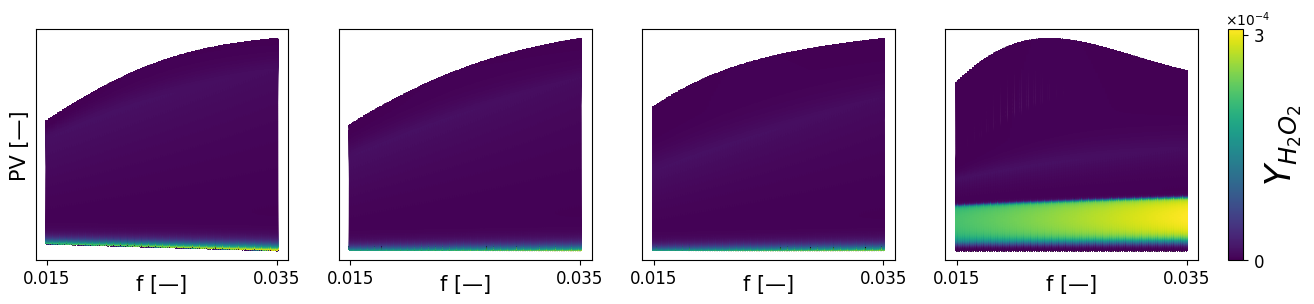

In [39]:
species_to_inspect = "H2O2"

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/f-PV manifolds/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"Evolution {species_to_inspect} distribution in f-PV manifolds - heuristic and optimized PVs - v5.png"

modelNames =   ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0", #Without NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0", #With NOx
                "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"] #With log(H2O2)]
PV_optimized_names = ["without NOx", "with NOx", "with log(H$_2$O$_2$)"]
weight_inversionArray = [True, True, True]

fig, axes = plt.subplots(1, 4, figsize=(15, 3))  # 1 row, 4 columns
axes = axes.flatten()



ax_heu = axes[0]

ax_heu.scatter(mixture_fractions_train, PV_Xu_train, s=1, c=state_space_train[species_to_inspect])
#ax_heu.set_title("Heuristic PV", fontsize = 15)
ax_heu.set_xlabel("f [\u2014]", fontsize = 15, labelpad = -10)
ax_heu.set_ylabel("PV [\u2014]", fontsize = 15)
ax_heu.set_xticks([0.015, 0.035])
ax_heu.set_yticks([])
ax_heu.tick_params(axis='x', labelsize=12)


for idx, (ax, filename_model, PV_optimized_name) in enumerate(zip(axes[1:], modelNames, PV_optimized_names), start=0):

    filename_metadata = filename_model + "_metadata.pkl"
    path_metadata = "metadata/"
    filename_species_names = "Xu-state-space-names.csv"
    path_data = "data-files/"

    loader = loadData(filename_species_names, path_metadata, filename_metadata)
    idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"]=="autoignition_augm" else loader.metadata["idx species removed"]
    id_model = loader.metadata["Training_id"]
    model = loader.loadModel()

    weight_inversion = weight_inversionArray[idx]
    if(weight_inversion):
        with torch.no_grad():  # Ensures we do not track gradients for this operation
            model.encoder_species.weight.mul_(-1)

    state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

    #create a np array in the format for the DNS dataset/optimized PV
    state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
    state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()

    PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

    sc = ax.scatter(mixture_fractions_train, PV_optimized_train, s=1, c=state_space_train[species_to_inspect])
    #ax.set_title(f"Optimized PV {PV_optimized_name}", fontsize = 15)   #PV$_{{\\mathrm{{opt}}}}$
    ax.set_xlabel("f [\u2014]", fontsize = 15)
    ax.set_xticks([0.015, 0.035])
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=12)
    ax.set_xlabel("f [\u2014]", fontsize = 15, labelpad = -10)

    # if(idx == len(PV_optimized_names)-1):
    #     cbar = plt.colorbar(sc, ax=ax)  # Add colorbar
    #     cbar.set_label(f'$Y_{species_to_inspect}$', fontsize=15)
    #     cbar.ax.tick_params(labelsize=15)
        #cbar.set_ticks([0, 4000000])

from matplotlib.ticker import ScalarFormatter

cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(f"$Y_{{{species_to_inspect.replace('2', '_2')}}}$", fontsize=25, rotation = 90, labelpad = 0)
cbar.set_ticks([0, 0.0003])
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-4, -4))  # Force e-04 notation
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.ax.yaxis.get_offset_text().set_x(2.8)
cbar.ax.tick_params(labelsize=12)

if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_29068\873606605.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')
C:\Windows\Temp\ipykernel_29068\873606605.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


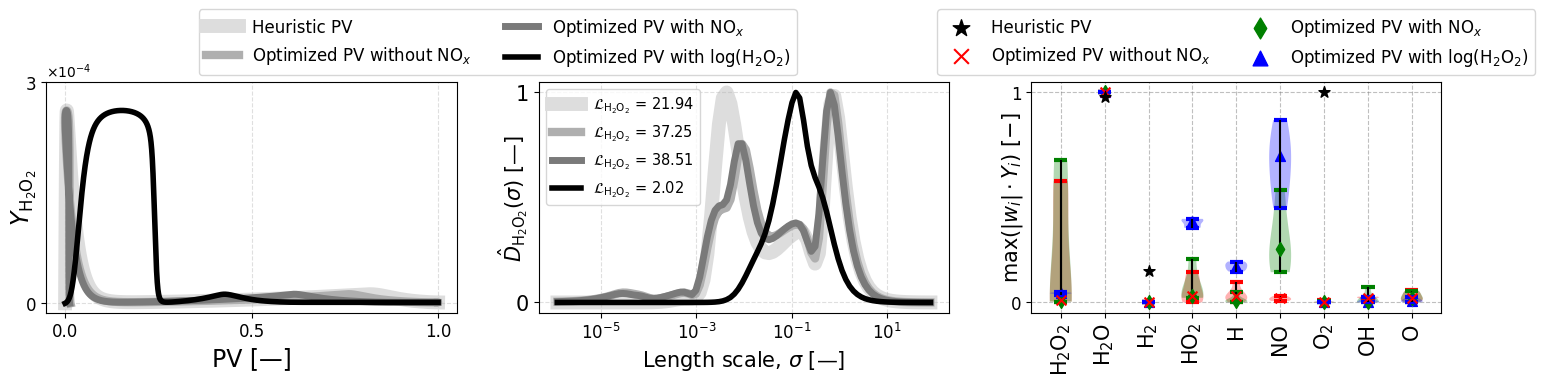

In [31]:
species_to_inspect = "H2O2"

save = True
path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/Overview/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"{species_to_inspect} vs PV - Dhat {species_to_inspect} - weights - heuristic and optimized PVs.png"

rows, cols = 1, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 3))  # Define the grid
axes = axes.flatten()



######################
# Model with log(H2O2)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

######################
# Model with NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withNOx.encoder_species.weight.mul_(-1)


######################
# Model without NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withoutNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withoutNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withoutNOx.encoder_species.weight.mul_(-1)


##################
# Import data

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

idxTraj = 4

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())
    PV_Xu_test = PV_Xu_test.to_numpy()

    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()

    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    PV_optimized_test_withNOx = model_withNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withNOx, axis=1))).detach().numpy()
    PV_optimized_test_withNOx = (PV_optimized_test_withNOx - PV_optimized_test_withNOx.min())/(PV_optimized_test_withNOx.max() - PV_optimized_test_withNOx.min())

    PV_optimized_test_withoutNOx = model_withoutNOx.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed_withoutNOx, axis=1))).detach().numpy()
    PV_optimized_test_withoutNOx = (PV_optimized_test_withoutNOx - PV_optimized_test_withoutNOx.min())/(PV_optimized_test_withoutNOx.max() - PV_optimized_test_withoutNOx.min())


greys = cm.get_cmap('Greys')

list_greys = [greys(0.23), greys(0.42), greys(0.6), greys(1.0)]
list_linewidth = [10, 6, 5, 4]
list_zorder = [1, 2, 3, 4]

species_label = species_to_inspect.replace("2", "_{2}").replace("1", "_{source}")

ax_NOvsPV = axes[0]

trajSpecies = test_trajectory[species_to_inspect]
trajSpceciesOpt = test_trajectory[species_to_inspect]
trajSpceciesOpt_withNOx = test_trajectory[species_to_inspect]
trajSpceciesOpt_withoutNOx = test_trajectory[species_to_inspect]

ax_NOvsPV.plot(PV_Xu_test, trajSpecies, linewidth=list_linewidth[0], label = "Heuristic PV", color=list_greys[0], zorder=list_zorder[0])
ax_NOvsPV.plot(PV_optimized_test_withoutNOx, trajSpceciesOpt_withoutNOx, linewidth=list_linewidth[1], label = "Optimized PV without NO$_x$", color=list_greys[1], zorder=list_zorder[1])
ax_NOvsPV.plot(PV_optimized_test_withNOx, trajSpceciesOpt_withNOx, linewidth=list_linewidth[2], label = "Optimized PV with NO$_x$", color=list_greys[2], zorder=list_zorder[2])
ax_NOvsPV.plot(PV_optimized_test, trajSpceciesOpt, linewidth=list_linewidth[3], label = "Optimized PV with log(H$_2$O$_2$)", color=list_greys[3], zorder = list_zorder[3])

ax_NOvsPV.set_ylabel(f"$Y_{{\\mathrm{{{species_label}}}}}$", fontsize=17, labelpad = -10)
    
ax_NOvsPV.set_xticks([0, 0.5, 1])

ax_NOvsPV.tick_params(axis='y', labelsize=12)
ax_NOvsPV.tick_params(axis='x', labelsize=12)


#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
#ax_NOvsPV.yaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
ax_NOvsPV.set_yticks([0, 0.0003])

ax_NOvsPV.set_xlabel(f"PV [\u2014]", fontsize = 17)

#if(idx_species%cols == 0):
    #ax.set_ylabel(f"$Y_{{{species_label}}}$ [\u2014]", fontsize = 17)

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Always use scientific notation
ax_NOvsPV.yaxis.set_major_formatter(formatter)

ax_NOvsPV.grid(True, linestyle='--', alpha=0.4)

handles, labels = ax_NOvsPV.get_legend_handles_labels()
ax_NOvsPV.legend(handles, labels, loc='upper center', ncol=2, fontsize=12, frameon=True, bbox_to_anchor=(1.1, 1.35), markerscale=8)






##########################################################################################################################
########################################################## Dhat curves ###################################################
##########################################################################################################################

path_variance = "data-files/costs/"

name_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"


penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)

costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



variance_withNOx = np.load(f"{path_variance}{name_withNOx}", allow_pickle=True).item()

(derivative_withNOx, bandwidth_values_withNOx, max_derivative_withNOx) = normalized_variance_derivative(variance_withNOx)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithNOx = cost_function_normalized_variance_derivative(variance_withNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



seed_2v = 0
name_withoutNOx = f"variance_Tr0D-2v_s{seed_2v}-bw_-6_2_100-dataset_autoignition.npy"

variance_withoutNOx = np.load(f"{path_variance}{name_withoutNOx}", allow_pickle=True).item()

(derivative_withoutNOx, bandwidth_values_withoutNOx, max_derivative_withoutNOx) = normalized_variance_derivative(variance_withoutNOx)

costsWithoutNOx = cost_function_normalized_variance_derivative(variance_withoutNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

import matplotlib.cm as cm

# Get shades of grey from black (0) to white (1)
greys = cm.get_cmap('Greys')

ax_Dhat = axes[1]

idx = keys.index(species_to_inspect)

ax_Dhat.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
        linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect.replace('2', '_2')}}}}}$ = {costsHeuristic_0D[idx]:.2f}", color=list_greys[0], zorder=list_zorder[0])
ax_Dhat.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
        linewidth=list_linewidth[1], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect.replace('2', '_2')}}}}}$ = {costsWithoutNOx[idx]:.2f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
ax_Dhat.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
        linewidth=list_linewidth[2], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect.replace('2', '_2')}}}}}$ = {costsWithNOx[idx]:.2f}", color=list_greys[2], zorder=list_zorder[2])
ax_Dhat.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
        linewidth=list_linewidth[3], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect.replace('2', '_2')}}}}}$ = {costsOptimized_0D[idx]:.2f}", color=list_greys[3], zorder=list_zorder[3])
ax_Dhat.set_xscale("log")
ax_Dhat.grid(True, linestyle='--', alpha=0.4)

ax_Dhat.legend(loc = "upper left", fontsize = 10.5)


ax_Dhat.tick_params(axis="both", labelsize=12)
ax_Dhat.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)


ax_Dhat.set_yticks([0, 1])
ax_Dhat.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect.replace('2', '_2')}}}}}(\sigma)$" + " [\u2014]", fontsize = 15, labelpad = -10)

ax_Dhat.tick_params(axis="y", labelsize=15)









##########################################################################################################################
########################################################## WEIGHTS #######################################################
##########################################################################################################################

dataset = "autoignition"

abs = True #in absolute value otherwise jumps from -1 to 1/sign flips for the different species

path_state = path_data + f"Xu-state-space-{dataset}.csv"
nbrSeeds = 5

nameModels = ["Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s",
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s",              
              "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s"]

########################
# Heuristic PV

my_species_Xu = Species(path_data)

list_species_Xu = my_species_Xu.get_list_species()
for index in sorted(idx_species_removed, reverse=True): #same species to remove
    list_species_Xu.pop(index)

final_weights_Xu = np.zeros(19)
final_weights_Xu[list_species_Xu.index("H2O")] = 1
final_weights_Xu[list_species_Xu.index("H2")] = -1
final_weights_Xu[list_species_Xu.index("O2")] = -1

#get mass fractions of species
state_space_Xu = pd.read_csv(path_state, header = "infer")
state_space_Xu = state_space_Xu.drop(state_space_Xu.columns[idx_species_removed], axis=1)
state_space_matrix_Xu = state_space_Xu.to_numpy()

wi_Yi_Xu = state_space_matrix_Xu*np.abs(final_weights_Xu) #|w_i|*Y_i
if(abs):
    max_wi_Yi_Xu = np.max(wi_Yi_Xu, axis = 0) #take max of every species
else:
    max_wi_Yi_Xu = np.sign(final_weights_Xu)*np.max(wi_Yi_Xu, axis = 0) #take max of every species

max_wi_Yi_scaled_Xu = max_wi_Yi_Xu/np.max(np.abs(max_wi_Yi_Xu))



weightsSpecies = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))
weightsSpeciesWithoutNOx = np.zeros((nbrSeeds, len(final_weights_Xu)))

#########################
# Start Figure
                 
for idxSeed in range(nbrSeeds):

    for idxModel, modelName in enumerate(nameModels):

        filename_model = f"{modelName}{idxSeed}"
        filename_metadata_0D = filename_model + "_metadata.pkl"

        loader_0D = loadData(filename_species_names, path_metadata, filename_metadata_0D)
        output_idx = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        idx_species_removed = loader_0D.metadata["list idx species removed source"] if loader_0D.metadata["dataset_type"].startswith("autoignition_augm") else loader_0D.metadata["idx species removed"]
        input_scaling = loader_0D.metadata["input scaling"]
        input_species_scaling = loader_0D.metadata["input species scaling"]
        input_species_bias = loader_0D.metadata["input species bias"]
        range_mf  = loader_0D.metadata["range_mf"]
        depvar_names_species = loader_0D.metadata["list species output"]
        depvar_names_idx = loader_0D.metadata["output elements"]
        PV_dim = loader_0D.metadata["PV dim"]
        depvar_names = depvar_names_species + depvar_names_idx[-(PV_dim+1):]
        model_0D = loader_0D.loadModel()
        id = loader_0D.metadata["Training_id"]
        nbr_input_species = loader_0D.metadata["nbr input species"]

        final_weights = model_0D.get_total_encoder_weights(npy = True)[0]

        #get index spcies removed
        my_species = Species(path_data)

        list_species = my_species.get_list_species()
        for index in sorted(idx_species_removed, reverse=True):
            list_species.pop(index)

        #get mass fractions of species
        state_space = pd.read_csv(path_state, header = "infer")
        state_space = state_space.drop(state_space.columns[idx_species_removed], axis=1)
        state_space_matrix = state_space.to_numpy()

        wi_Yi = state_space_matrix*np.abs(final_weights) #|w_i|*Y_i
        if(abs):
            max_wi_Yi = np.max(wi_Yi, axis = 0) #take max of every species
        else:
            max_wi_Yi = np.sign(final_weights)*np.max(wi_Yi, axis = 0) #take max of every species

        max_wi_Yi_scaled = max_wi_Yi/np.max(np.abs(max_wi_Yi))

        if(idxModel == 0):
            weightsSpecies[idxSeed, :] = max_wi_Yi_scaled
        elif(idxModel == 1):
            weightsSpeciesWithNOx[idxSeed, :] = max_wi_Yi_scaled
        else:
            weightsSpeciesWithoutNOx[idxSeed, :] = max_wi_Yi_scaled


#################
#Plot the weights
#################

ax_weights = axes[2]

mediansWithoutNOx = np.median(weightsSpeciesWithoutNOx, axis=0)
mediansWithNOx = np.median(weightsSpeciesWithNOx, axis=0)
mediansWithLogH2O2 = np.median(weightsSpecies, axis=0)

valid_indices = [i for i in range(len(max_wi_Yi_scaled)) if np.abs(mediansWithoutNOx[i]) > 0.01 or np.abs(mediansWithNOx[i])>0.01 or np.abs(mediansWithLogH2O2[i])>0.01 or np.abs(max_wi_Yi_scaled_Xu[i]) > 0.01]


latex_species_list = np.array([s.replace('2', r'$_2$').replace('3', r'$_3$') for s in list_species])
latex_species_list_filtered = latex_species_list[valid_indices]

max_wi_Yi_scaled_Xu_filtered = max_wi_Yi_scaled_Xu[valid_indices]

non_zero_mask = max_wi_Yi_scaled_Xu_filtered != 0
positions = np.arange(len(max_wi_Yi_scaled_Xu_filtered))


# Heuristic PV
ax_weights.scatter(
    np.arange(len(max_wi_Yi_scaled_Xu_filtered))[non_zero_mask],
    max_wi_Yi_scaled_Xu_filtered[non_zero_mask],
    color="k", label="Heuristic PV", marker="*", s=70, zorder = 4
)




# Without NOx
violinWithout = ax_weights.violinplot(weightsSpeciesWithoutNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWithout["bodies"]:
    element.set_facecolor("red")
    element.set_linewidth(10)
violinWithout['cmins'].set_color('red')
violinWithout['cmaxes'].set_color('red')
violinWithout['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithoutNOx[:, valid_indices], axis=0)

violinWithout['cmaxes'].set_linewidth(3)
violinWithout['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWithout['cmins'].get_segments(), violinWithout['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWithout['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmins'].get_segments(), positions)
    ])
    violinWithout['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWithout['cmaxes'].get_segments(), positions)
    ])


ax_weights.scatter(positions, medians, color = "red", marker='x', s=50, zorder=3, label='Optimized PV without NO$_x$') #red  greys(0.6)





# With NOx
violinWith = ax_weights.violinplot(weightsSpeciesWithNOx[:, valid_indices], positions, widths = 0.5)
for element in violinWith["bodies"]:
    element.set_facecolor("green")
    element.set_linewidth(10)
violinWith['cmins'].set_color('green')
violinWith['cmaxes'].set_color('green')
violinWith['cbars'].set_color('black')
medians = np.median(weightsSpeciesWithNOx[:, valid_indices], axis=0)

violinWith['cmaxes'].set_linewidth(3)
violinWith['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violinWith['cmins'].get_segments(), violinWith['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violinWith['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmins'].get_segments(), positions)
    ])
    violinWith['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violinWith['cmaxes'].get_segments(), positions)
    ])

plt.scatter(positions, medians, color="green", marker='d', s=50, zorder=2, label='Optimized PV with NO$_x$') #green   greys(0.42)






# With NOx and log(H2O2)
violin = ax_weights.violinplot(weightsSpecies[:, valid_indices], positions, widths = 0.5)
for element in violin["bodies"]:
    element.set_facecolor("blue")
    element.set_linewidth(10)
violin['cmins'].set_color('blue')
violin['cmaxes'].set_color('blue')
violin['cbars'].set_color('black')
medians = np.median(weightsSpecies[:, valid_indices], axis=0)

violin['cmaxes'].set_linewidth(3)
violin['cmins'].set_linewidth(3)

for i, (cmin, cmax) in enumerate(zip(violin['cmins'].get_segments(), violin['cmaxes'].get_segments())):
    # Extract y-values (vertical limits)
    y_min = cmin[0][1]
    y_max = cmax[0][1]

    # Use actual position
    x_center = positions[i]
    width = 0.15  # desired width of the extrema bars

    # Set new segments for min and max bars
    violin['cmins'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmins'].get_segments(), positions)
    ])
    violin['cmaxes'].set_segments([
        [[x_center - width, seg[0][1]], [x_center + width, seg[0][1]]]
        for seg, x_center in zip(violin['cmaxes'].get_segments(), positions)
    ])
ax_weights.scatter(positions, medians, color= "blue", marker='^', s=50, zorder=1, label='Optimized PV with log(H$_2$O$_2$)') #blue   greys(0.23)







if abs:
    ax_weights.set_ylabel(r"max($|w_i| \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
else:
    ax_weights.set_ylabel(r"max($w_i \cdot Y_i$) [$-$]", fontsize=15, labelpad = -10)
ax_weights.set_yticks([0, 1])
ax_weights.tick_params(axis='y', labelsize=12)

ax_weights.set_xticks(np.arange(len(max_wi_Yi_scaled_Xu_filtered)), latex_species_list_filtered, fontsize=15, rotation=90)
ax_weights.grid(True, linestyle='--', color='gray', alpha=0.5)

ax_weights.legend(fontsize=12,  ncol=2, loc = "upper center", bbox_to_anchor=(0.5, 1.35), scatterpoints=1, markerscale=1.5)





if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

C:\Windows\Temp\ipykernel_29068\2615951226.py:137: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


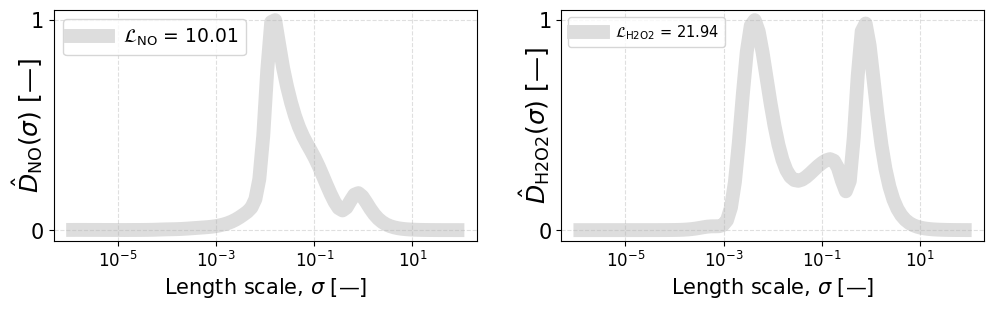

In [65]:
save = True

nbr_PVs = 1

path = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Effect QoI NOx/Overview/" #"Autoignition/Z_0.015-0.035-T_900K/f-PV manifolds/"
name = f"NO and H2O2 Dhat combined - heuristic and optimized PVs - PRESENTATION{nbr_PVs}.png"

rows, cols = 1, 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 3))  # Define the grid
axes = axes.flatten()

list_species_to_inspect = ["NO", "H2O2"]
list_legend_fontsize = [13.5, 10.5]

######################
# Model with log(H2O2)

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

######################
# Model with NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_18Feb2025-hour_22h58_Tr0D-2h_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withNOx.encoder_species.weight.mul_(-1)


######################
# Model without NOx

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_15Apr2025-hour_15h37_Tr0D-2v_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"
loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed_withoutNOx = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model_withoutNOx = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model_withoutNOx.encoder_species.weight.mul_(-1)


##########################################################################################################################
########################################################## Dhat curves ###################################################
##########################################################################################################################

path_variance = "data-files/costs/"

name_withNOx = "variance_Tr0D-2h_s0-bw_-6_2_100-dataset_autoignition.npy"


penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)

costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



variance_withNOx = np.load(f"{path_variance}{name_withNOx}", allow_pickle=True).item()

(derivative_withNOx, bandwidth_values_withNOx, max_derivative_withNOx) = normalized_variance_derivative(variance_withNOx)

keys = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH', 'T', 'PV1']

costsWithNOx = cost_function_normalized_variance_derivative(variance_withNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)



seed_2v = 0
name_withoutNOx = f"variance_Tr0D-2v_s{seed_2v}-bw_-6_2_100-dataset_autoignition.npy"

variance_withoutNOx = np.load(f"{path_variance}{name_withoutNOx}", allow_pickle=True).item()

(derivative_withoutNOx, bandwidth_values_withoutNOx, max_derivative_withoutNOx) = normalized_variance_derivative(variance_withoutNOx)

costsWithoutNOx = cost_function_normalized_variance_derivative(variance_withoutNOx,
                                                            penalty_function=penalty_function,
                                                            power=power,
                                                            vertical_shift=vertical_shift,
                                                            norm=None)

import matplotlib.cm as cm

# Get shades of grey from black (0) to white (1)
greys = cm.get_cmap('Greys')

ax_NO = axes[0]
ax_H2O2 = axes[1]



for idxAx, ax in enumerate(axes):
    idx = keys.index(list_species_to_inspect[idxAx])
    species_to_inspect = list_species_to_inspect[idxAx]
    if(nbr_PVs>=1):
        ax.plot(bandwidth_values_heuristic_0D, derivative_heuristic_0D[species_to_inspect],
            linewidth=list_linewidth[0], linestyle="-", label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsHeuristic_0D[idx]:.2f}", color=list_greys[0], zorder=list_zorder[0])
    if(nbr_PVs>=2):
        ax.plot(bandwidth_values_withoutNOx, derivative_withoutNOx[species_to_inspect],
            linewidth=list_linewidth[1], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithoutNOx[idx]:.2f}", color=list_greys[1], linestyle="-", zorder=list_zorder[1])
    if(nbr_PVs>=3):
        ax.plot(bandwidth_values_withNOx, derivative_withNOx[species_to_inspect],
            linewidth=list_linewidth[2], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsWithNOx[idx]:.2f}", color=list_greys[2], zorder=list_zorder[2])
    if(nbr_PVs>=4):
        ax.plot(bandwidth_values_optimized_0D, derivative_optimized_0D[species_to_inspect],
            linewidth=list_linewidth[3], label=f"$\mathcal{{L}}_{{\\mathrm{{{species_to_inspect}}}}}$ = {costsOptimized_0D[idx]:.2f}", color=list_greys[3], zorder=list_zorder[3])
        
    ax.set_xscale("log")
    ax.grid(True, linestyle='--', alpha=0.4)

    ax.legend(loc = "upper left", fontsize = list_legend_fontsize[idxAx])


    ax.tick_params(axis="both", labelsize=12)
    ax.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize = 15)


    ax.set_yticks([0, 1])
    ax.set_ylabel(f"$\hat{{D}}_{{\\mathrm{{{species_to_inspect}}}}}(\sigma)$" + " [\u2014]", fontsize = 18, labelpad = -10)

    ax.tick_params(axis="y", labelsize=15)



if(save):
    plt.savefig(path + name, dpi = 300, bbox_inches='tight')
plt.show()

## Visualize PV source term

C:\Windows\Temp\ipykernel_5336\339093116.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


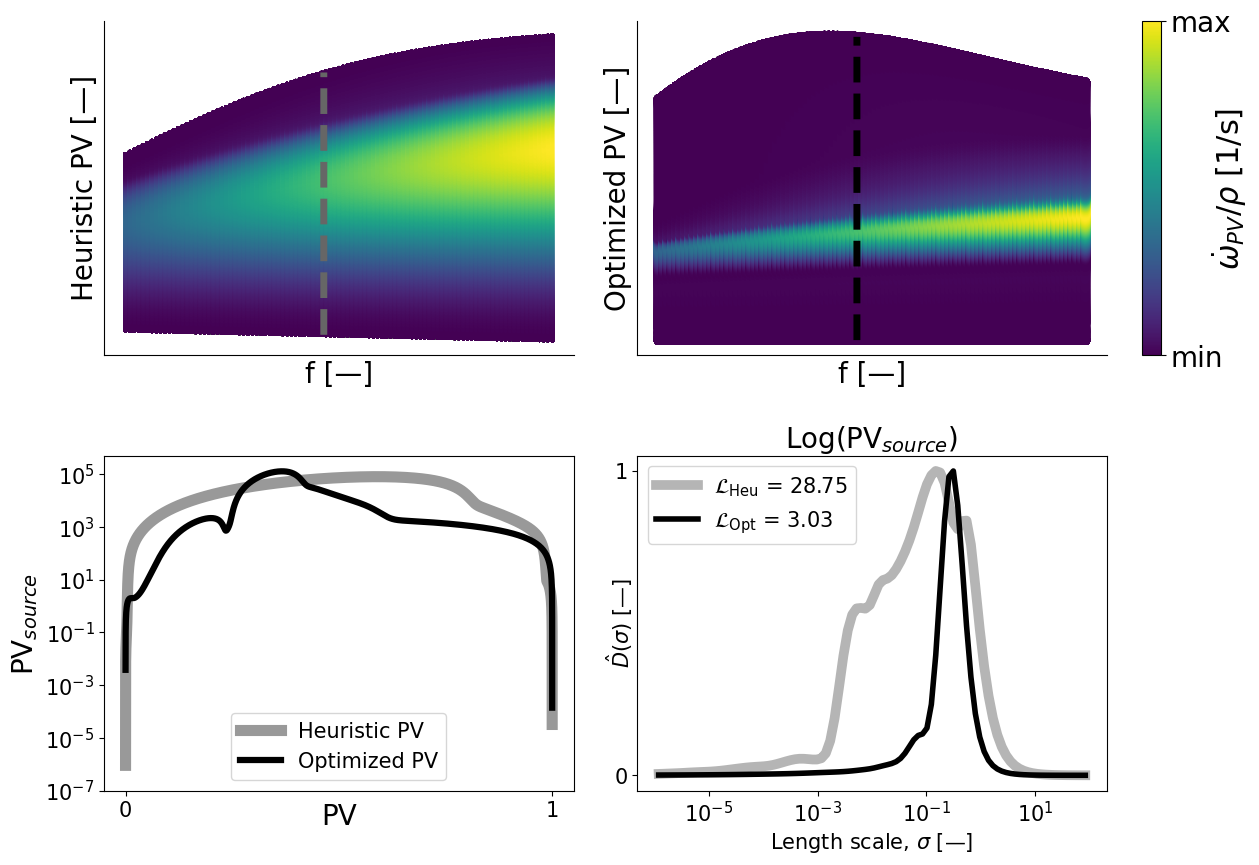

In [9]:
save = True
pathSave = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = "f-PV manifold autoignition - trajectory log(PVsource) - cost log(PVsource).png"


fig = plt.figure(figsize=(14, 10))

gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.04], height_ratios=[1, 1], hspace=0.3)

# Top-left plot (0,0)
ax00 = fig.add_subplot(gs[0, 0])
# Top-right plot (0,1)
ax01 = fig.add_subplot(gs[0, 1])
# Bottom-left plot (1,0)
ax10 = fig.add_subplot(gs[1, 0])
# Bottom-right plot (1,1)
ax11 = fig.add_subplot(gs[1, 1])
# Colorbar axis (top row, 2nd col)
cax = fig.add_subplot(gs[0, 2])

#################################
# Top left - Heuristic PV
#################################
ax00.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

# Test state space
idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

ax00.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]),
              PV_heuristic_test, color=str(0.4), linestyle="--", linewidth=5)

ax00.set_xlabel("f [\u2014]", fontsize=20)
ax00.set_ylabel("Heuristic PV [\u2014]", fontsize=20)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

#################################
# Top right - Optimized PV
#################################
ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

ax01.plot(np.full(PV_optimized_test.shape[0], mixture_fractions_test[idxTraj]),
                 PV_optimized_test, color="k", linestyle = "--", linewidth=5)

ax01.set_xlabel("f [\u2014]", fontsize=20)
ax01.set_ylabel("Optimized PV [\u2014]", fontsize=20)
ax01.set_xticks([])
ax01.set_yticks([])
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)

sc = ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

# Add colorbar in dedicated axis cax:
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize=22, labelpad=-15)
vmin = PV_optimized_source_train.min()
vmax = PV_optimized_source_train.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=20)

pos = cax.get_position()
cax.set_position([pos.x0 - 0.02, pos.y0, pos.width, pos.height])

#################################
# Bottom left - logPVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax10.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx],
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax10.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx],
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax10.set_xlabel("PV", fontsize=20, labelpad=-13)
ax10.set_ylabel("PV$_{source}$", fontsize=20)
ax10.set_xticks([0, 1])
ax10.tick_params(axis='x', labelsize=15)
ax10.tick_params(axis='y', labelsize=15)
ax10.set_ylim([1e-7, 5e5])
ax10.set_yscale("log")
ax10.legend(fontsize=15, ncol=1) #, loc='upper center', bbox_to_anchor=(0.5, 1.15)

#################################
# Bottom right - Dhat curve
#################################

path_variance = "data-files/costs/"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

greys = cm.get_cmap('Greys')

name_optimized_0D_logPVsource = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition_logPVsource.npy"
name_heuristic_0D_logPVsource = "variance_Xu-bw_-6_2_100-dataset_autoignition_logPVsource.npy"

variance_optimized_0D_logPVsource = np.load(f"{path_variance}{name_optimized_0D_logPVsource}", allow_pickle=True).item()
variance_heuristic_0D_logPVsource = np.load(f"{path_variance}{name_heuristic_0D_logPVsource}", allow_pickle=True).item()

(derivative_optimized_0D_logPVsource, bandwidth_values_optimized_0D_logPVsource, max_derivative_optimized_0D_logPVsource) = normalized_variance_derivative(variance_optimized_0D_logPVsource)
(derivative_heuristic_0D_logPVsource, bandwidth_values_heuristic_0D_logPVsource, max_derivative_heuristic_0D_logPVsource) = normalized_variance_derivative(variance_heuristic_0D_logPVsource)


costsOptimized_0D_logPVsource = cost_function_normalized_variance_derivative(variance_optimized_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D_logPVsource = cost_function_normalized_variance_derivative(variance_heuristic_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax11.plot(bandwidth_values_heuristic_0D_logPVsource,
              derivative_heuristic_0D_logPVsource['logPVsource'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D_logPVsource[0]:.2f}',
              linewidth=7, linestyle="-")

ax11.plot(bandwidth_values_optimized_0D_logPVsource,
              derivative_optimized_0D_logPVsource['logPVsource'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D_logPVsource[0]:.2f}',
              linewidth=4)

ax11.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=15)
ax11.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=15, labelpad = -15)
ax11.set_xscale("log")
ax11.set_yticks([0, 1])
ax11.tick_params(axis='x', labelsize=15)
ax11.tick_params(axis='y', labelsize=15)
ax11.set_title("Log(PV$_{source}$)", fontsize=20)
ax11.legend(fontsize=15)

if(save):
    plt.savefig(pathSave + name, dpi=1000)

plt.show()


C:\Windows\Temp\ipykernel_5336\961966992.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


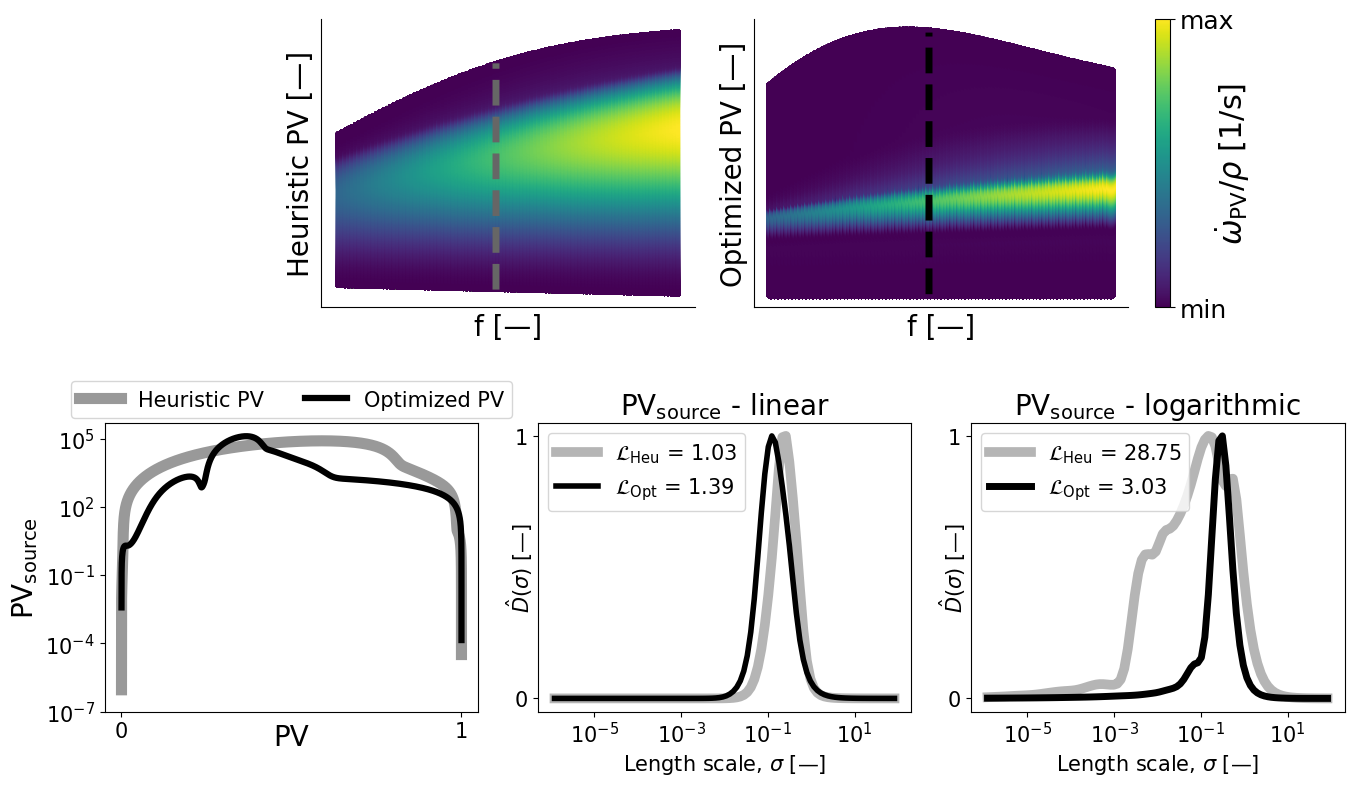

In [10]:
save = True
pathSave = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = "f-PV manifold autoignition - trajectory log(PVsource) - cost lin and log(PVsource).png"

fig = plt.figure(figsize=(16, 9))

# Use 6 columns so we can center things properly
gs = gridspec.GridSpec(2, 12, height_ratios=[1, 1], hspace=0.4, wspace=1.2)

# Top row (2 plots, centered: occupy columns [1,2] and [3,4])
ax00 = fig.add_subplot(gs[0, 2:6])   # top-left
ax01 = fig.add_subplot(gs[0, 6:10])   # top-right
ax02 = fig.add_subplot(gs[0, 10]) 

# Bottom row (3 plots, centered: occupy [0,1], [2,3], [4,5])
ax10 = fig.add_subplot(gs[1, 0:4])   # bottom-left
ax11 = fig.add_subplot(gs[1, 4:8])   # bottom-middle
ax12 = fig.add_subplot(gs[1, 8:12])   # bottom-right

pos = ax02.get_position()
ax02.set_position([pos.x0-0.02, pos.y0, pos.width*0.3, pos.height])

#################################
# Top left - Heuristic PV
#################################
ax00.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

# Test state space
idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

ax00.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]),
              PV_heuristic_test, color=str(0.4), linestyle="--", linewidth=5)

ax00.set_xlabel("f [\u2014]", fontsize=20)
ax00.set_ylabel("Heuristic PV [\u2014]", fontsize=20)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

#################################
# Top right - Optimized PV
#################################
ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

ax01.plot(np.full(PV_optimized_test.shape[0], mixture_fractions_test[idxTraj]),
                 PV_optimized_test, color="k", linestyle = "--", linewidth=5)

ax01.set_xlabel("f [\u2014]", fontsize=20)
ax01.set_ylabel("Optimized PV [\u2014]", fontsize=20)
ax01.set_xticks([])
ax01.set_yticks([])
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)

sc = ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

# Add colorbar in dedicated axis cax:
cbar = fig.colorbar(sc, cax=ax02, orientation='vertical')
cbar.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=22, labelpad=-15)
vmin = PV_optimized_source_train.min()
vmax = PV_optimized_source_train.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=18)


#################################
# Bottom left - logPVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax10.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx],
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax10.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx],
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax10.set_xlabel("PV", fontsize=20, labelpad=-13)
ax10.set_ylabel("PV$_{\mathrm{source}}$", fontsize=20)
ax10.set_xticks([0, 1])
ax10.tick_params(axis='x', labelsize=15)
ax10.tick_params(axis='y', labelsize=15)
ax10.set_ylim([1e-7, 5e5])
ax10.set_yscale("log")
ax10.legend(fontsize=15, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.18)) #, loc='upper center', bbox_to_anchor=(0.5, 1.15)

#################################
# Bottom right - Dhat curve
#################################

path_variance = "data-files/costs/"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

greys = cm.get_cmap('Greys')





name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)


costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax11.plot(bandwidth_values_heuristic_0D,
              derivative_heuristic_0D['PV1'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D[-1]:.2f}',
              linewidth=7, linestyle="-")

ax11.plot(bandwidth_values_optimized_0D,
              derivative_optimized_0D['PV1'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D[-1]:.2f}',
              linewidth=4, linestyle="-")


ax11.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=15)
ax11.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=15, labelpad = -15)
ax11.set_xscale("log")
ax11.set_yticks([0, 1])
ax11.tick_params(axis='x', labelsize=15)
ax11.tick_params(axis='y', labelsize=15)
ax11.set_title("PV$_{\mathrm{source}}$ - linear", fontsize=20)
ax11.legend(fontsize=15)



name_optimized_0D_logPVsource = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition_logPVsource.npy"
name_heuristic_0D_logPVsource = "variance_Xu-bw_-6_2_100-dataset_autoignition_logPVsource.npy"

variance_optimized_0D_logPVsource = np.load(f"{path_variance}{name_optimized_0D_logPVsource}", allow_pickle=True).item()
variance_heuristic_0D_logPVsource = np.load(f"{path_variance}{name_heuristic_0D_logPVsource}", allow_pickle=True).item()

(derivative_optimized_0D_logPVsource, bandwidth_values_optimized_0D_logPVsource, max_derivative_optimized_0D_logPVsource) = normalized_variance_derivative(variance_optimized_0D_logPVsource)
(derivative_heuristic_0D_logPVsource, bandwidth_values_heuristic_0D_logPVsource, max_derivative_heuristic_0D_logPVsource) = normalized_variance_derivative(variance_heuristic_0D_logPVsource)


costsOptimized_0D_logPVsource = cost_function_normalized_variance_derivative(variance_optimized_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D_logPVsource = cost_function_normalized_variance_derivative(variance_heuristic_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax12.plot(bandwidth_values_heuristic_0D_logPVsource,
              derivative_heuristic_0D_logPVsource['logPVsource'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D_logPVsource[0]:.2f}',
              linewidth=7, linestyle="-")

ax12.plot(bandwidth_values_optimized_0D_logPVsource,
              derivative_optimized_0D_logPVsource['logPVsource'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D_logPVsource[0]:.2f}',
              linewidth=5)


ax12.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=15)
ax12.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=15, labelpad = -15)
ax12.set_xscale("log")
ax12.set_yticks([0, 1])
ax12.tick_params(axis='x', labelsize=15)
ax12.tick_params(axis='y', labelsize=15)
ax12.set_title("PV$_{\mathrm{source}}$ - logarithmic", fontsize=20)
ax12.legend(fontsize=15)

if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches='tight')

plt.show()

C:\Windows\Temp\ipykernel_5336\2999979169.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


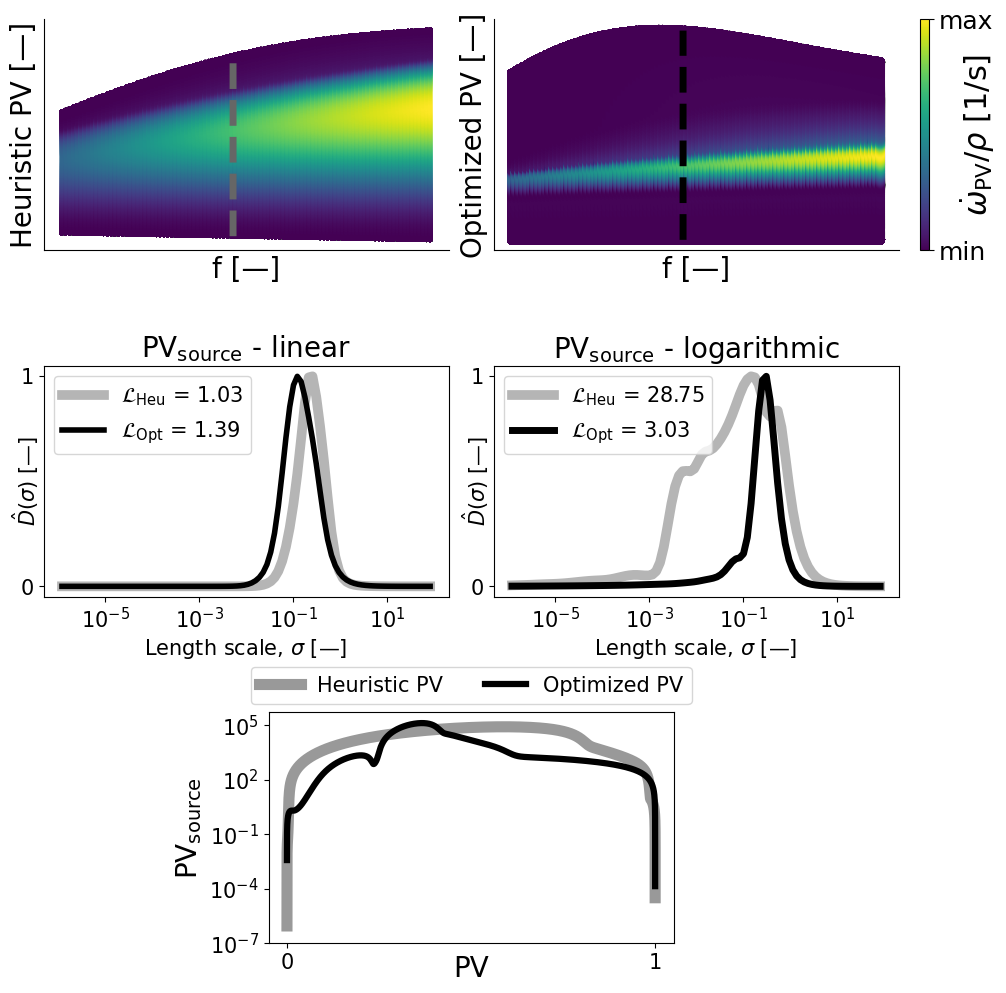

In [25]:
save = True
pathSave = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = "f-PV manifold autoignition - trajectory log(PVsource) - cost lin and log(PVsource) - column format.png"

fig = plt.figure(figsize=(12, 12))  # slightly taller figure

# GridSpec: 3 rows, 12 columns for fine control
gs = gridspec.GridSpec(3, 13, height_ratios=[1, 1, 1], hspace=0.5, wspace=1.5)

# -----------------------------
# Top row: 2 plots
# -----------------------------
ax00 = fig.add_subplot(gs[0, 0:6])   # top-left (Heuristic PV)
ax01 = fig.add_subplot(gs[0, 6:12])  # top-right (Optimized PV)
ax02 = fig.add_subplot(gs[0, 12])    # small colorbar axis (optional)

pos = ax02.get_position()
ax02.set_position([pos.x0-0.02, pos.y0, pos.width*0.3, pos.height])  # adjust colorbar

# -----------------------------
# Second row: 2 plots (Dhat)
# -----------------------------
ax10 = fig.add_subplot(gs[1, 0:6])   # bottom-left (Dhat linear)
ax11 = fig.add_subplot(gs[1, 6:12])  # bottom-right (Dhat logarithmic)

# -----------------------------
# Third row: 1 plot (PVsource vs PV)
# -----------------------------
ax20 = fig.add_subplot(gs[2, 3:9])   # centered (PVsource vs PV)

pos = ax02.get_position()
ax02.set_position([pos.x0, pos.y0, pos.width, pos.height])

#################################
# Top left - Heuristic PV
#################################
ax00.scatter(mixture_fractions_train, PV_Xu_train, s=5, c=PV_Xu_train_source)

# Test state space
idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

ax00.plot(np.full(PV_heuristic_test.shape[0], mixture_fractions_test[idxTraj]),
              PV_heuristic_test, color=str(0.4), linestyle="--", linewidth=5)

ax00.set_xlabel("f [\u2014]", fontsize=20)
ax00.set_ylabel("Heuristic PV [\u2014]", fontsize=20)
ax00.set_xticks([])
ax00.set_yticks([])
ax00.spines['top'].set_visible(False)
ax00.spines['right'].set_visible(False)

#################################
# Top right - Optimized PV
#################################
ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

ax01.plot(np.full(PV_optimized_test.shape[0], mixture_fractions_test[idxTraj]),
                 PV_optimized_test, color="k", linestyle = "--", linewidth=5)

ax01.set_xlabel("f [\u2014]", fontsize=20)
ax01.set_ylabel("Optimized PV [\u2014]", fontsize=20)
ax01.set_xticks([])
ax01.set_yticks([])
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)

sc = ax01.scatter(mixture_fractions_train, PV_optimized_train,
                 c=PV_optimized_source_train, cmap='viridis', marker='o')

# Add colorbar in dedicated axis cax:
cbar = fig.colorbar(sc, cax=ax02, orientation='vertical')
cbar.set_label(r'$\dot{\omega}_{\mathrm{PV}} / \rho$ [1/s]', fontsize=22, labelpad=-25)
vmin = PV_optimized_source_train.min()
vmax = PV_optimized_source_train.max()
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels(["min", "max"])
cbar.ax.tick_params(labelsize=18)


#################################
# Bottom left - logPVsource trajectory
#################################
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())

    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax20.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx],
              linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax20.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx],
              linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

ax20.set_xlabel("PV", fontsize=20, labelpad=-13)
ax20.set_ylabel("PV$_{\mathrm{source}}$", fontsize=20)
ax20.set_xticks([0, 1])
ax20.tick_params(axis='x', labelsize=15)
ax20.tick_params(axis='y', labelsize=15)
ax20.set_ylim([1e-7, 5e5])
ax20.set_yscale("log")
ax20.legend(fontsize=15, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.24)) #, loc='upper center', bbox_to_anchor=(0.5, 1.15)

#################################
# Bottom right - Dhat curve
#################################

path_variance = "data-files/costs/"

penalty_function = 'log-sigma-over-peak'
power = 4
vertical_shift = 1

greys = cm.get_cmap('Greys')





name_optimized_0D = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition.npy"
name_heuristic_0D = "variance_Xu-bw_-6_2_100-dataset_autoignition.npy"

variance_optimized_0D = np.load(f"{path_variance}{name_optimized_0D}", allow_pickle=True).item()
variance_heuristic_0D = np.load(f"{path_variance}{name_heuristic_0D}", allow_pickle=True).item()

(derivative_optimized_0D, bandwidth_values_optimized_0D, max_derivative_optimized_0D) = normalized_variance_derivative(variance_optimized_0D)
(derivative_heuristic_0D, bandwidth_values_heuristic_0D, max_derivative_heuristic_0D) = normalized_variance_derivative(variance_heuristic_0D)


costsOptimized_0D = cost_function_normalized_variance_derivative(variance_optimized_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D = cost_function_normalized_variance_derivative(variance_heuristic_0D,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax10.plot(bandwidth_values_heuristic_0D,
              derivative_heuristic_0D['PV1'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D[-1]:.2f}',
              linewidth=7, linestyle="-")

ax10.plot(bandwidth_values_optimized_0D,
              derivative_optimized_0D['PV1'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D[-1]:.2f}',
              linewidth=4, linestyle="-")


ax10.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=15)
ax10.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=15, labelpad = -15)
ax10.set_xscale("log")
ax10.set_yticks([0, 1])
ax10.tick_params(axis='x', labelsize=15)
ax10.tick_params(axis='y', labelsize=15)
ax10.set_title("PV$_{\mathrm{source}}$ - linear", fontsize=20)
ax10.legend(fontsize=15)



name_optimized_0D_logPVsource = "variance_Tr0D-2q_s0-bw_-6_2_100-dataset_autoignition_logPVsource.npy"
name_heuristic_0D_logPVsource = "variance_Xu-bw_-6_2_100-dataset_autoignition_logPVsource.npy"

variance_optimized_0D_logPVsource = np.load(f"{path_variance}{name_optimized_0D_logPVsource}", allow_pickle=True).item()
variance_heuristic_0D_logPVsource = np.load(f"{path_variance}{name_heuristic_0D_logPVsource}", allow_pickle=True).item()

(derivative_optimized_0D_logPVsource, bandwidth_values_optimized_0D_logPVsource, max_derivative_optimized_0D_logPVsource) = normalized_variance_derivative(variance_optimized_0D_logPVsource)
(derivative_heuristic_0D_logPVsource, bandwidth_values_heuristic_0D_logPVsource, max_derivative_heuristic_0D_logPVsource) = normalized_variance_derivative(variance_heuristic_0D_logPVsource)


costsOptimized_0D_logPVsource = cost_function_normalized_variance_derivative(variance_optimized_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)
costsHeuristic_0D_logPVsource = cost_function_normalized_variance_derivative(variance_heuristic_0D_logPVsource,
    penalty_function=penalty_function, power=power, vertical_shift=vertical_shift, norm=None)

ax11.plot(bandwidth_values_heuristic_0D_logPVsource,
              derivative_heuristic_0D_logPVsource['logPVsource'],
              color=greys(0.4), zorder=1,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Heu}}}}$ = {costsHeuristic_0D_logPVsource[0]:.2f}',
              linewidth=7, linestyle="-")

ax11.plot(bandwidth_values_optimized_0D_logPVsource,
              derivative_optimized_0D_logPVsource['logPVsource'],
              color=greys(1.0), zorder=2,
              label=f'$\mathcal{{L}}_{{\\mathrm{{Opt}}}}$ = {costsOptimized_0D_logPVsource[0]:.2f}',
              linewidth=5)


ax11.set_xlabel(r"Length scale, $\sigma$"+ " [\u2014]", fontsize=15)
ax11.set_ylabel(r"$\hat{D}(\sigma)$" + " [\u2014]", fontsize=15, labelpad = -15)
ax11.set_xscale("log")
ax11.set_yticks([0, 1])
ax11.tick_params(axis='x', labelsize=15)
ax11.tick_params(axis='y', labelsize=15)
ax11.set_title("PV$_{\mathrm{source}}$ - logarithmic", fontsize=20)
ax11.legend(fontsize=15)

if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches='tight')

plt.show()

## PV over time

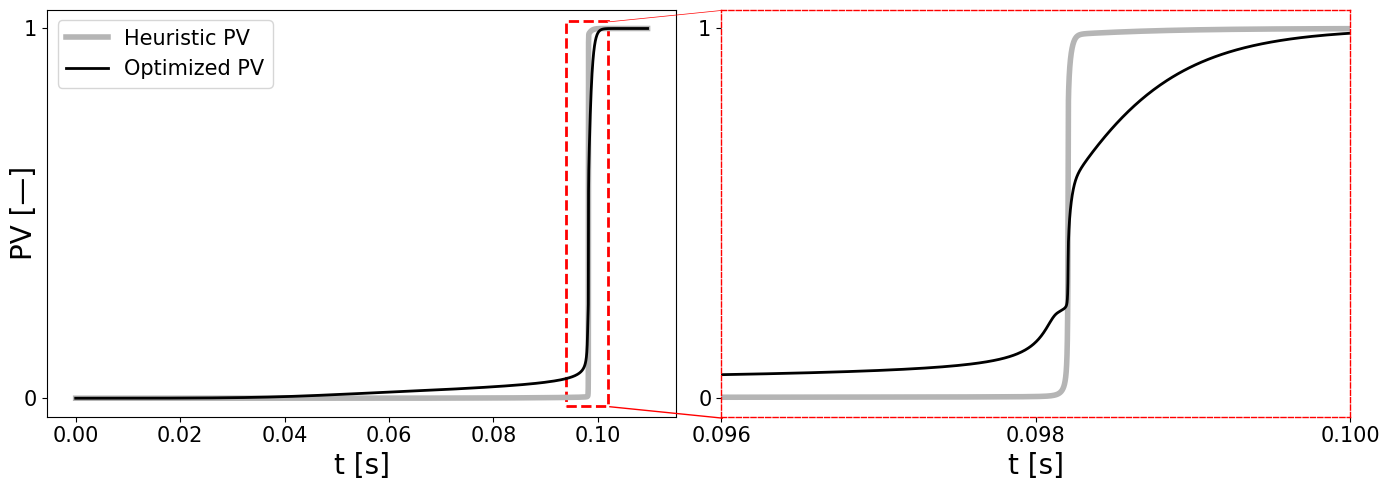

In [89]:
save = True
pathSave = "C:/Users/Admin/Documents/Parente/Figures/2024-PV-optimization/Paper/Results/Comparison Xu vs optimized/f-PV manifolds/"
name = "PV over time - heuristic vs optimized - autoignition.png"

idxTraj = 4
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:])
#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    PV_heuristic_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]

import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Full plot
axs[0].plot(test_trajectory_time, 
            (PV_heuristic_test-PV_heuristic_test.min())/(PV_heuristic_test.max() - PV_heuristic_test.min()), 
            label="Heuristic PV", linewidth=4, c=greys(0.4))
axs[0].plot(test_trajectory_time, 
            (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min()), 
            label="Optimized PV", linewidth=2, color="k")
axs[0].set_xlabel("t [s]", fontsize=20)
axs[0].set_ylabel("PV [\u2014]", fontsize=20, labelpad=-10)
axs[0].set_yticks([0, 1])
axs[0].tick_params(axis='both', labelsize=15)
axs[0].legend(fontsize=15)
#axs[0].set_title("Full trajectory", fontsize=18)

# Add rectangle to highlight zoomed-in region
x0, y0 = 0.094, -0.02
width, height = 0.008, 1.04
rect = patches.Rectangle((x0, y0), width, height, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
axs[0].add_patch(rect)

# Zoomed-in plot
axs[1].plot(test_trajectory_time, 
            (PV_heuristic_test-PV_heuristic_test.min())/(PV_heuristic_test.max() - PV_heuristic_test.min()), 
            label="Heuristic PV", linewidth=4, c=greys(0.4))
axs[1].plot(test_trajectory_time, 
            (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min()), 
            label="Optimized PV", linewidth=2, color="k")
axs[1].set_xlabel("t [s]", fontsize=20)
axs[1].set_xticks([0.096, 0.098, 0.1])
axs[1].set_yticks([0, 1])
axs[1].tick_params(axis='both', labelsize=15)
axs[1].set_xlim(0.096, 0.1)  # Zoom in
#axs[1].set_title("Zoomed-in view", fontsize=18)


for spine in axs[1].spines.values():
    spine.set_edgecolor('red')
    spine.set_linestyle('--')
    spine.set_linewidth(1)

fig_trans = fig.transFigure.inverted()
trans0 = axs[0].transData
trans1 = axs[1].transData

fig.canvas.draw()  # update the transforms
xy0 = fig_trans.transform(trans0.transform([x0 + width, 0.045]))            # bottom-left
xy1 = fig_trans.transform(trans0.transform([x0 + width, 0.105 + height]))  # top-right
xy_right = fig_trans.transform(trans1.transform([0.09568, 0.0125]))     # left-bottom of right axes
xy_right_top = fig_trans.transform(trans1.transform([0.09568, 1.1775])) # left-top of right axes

# Draw connecting lines
fig.add_artist(Line2D([xy1[0], xy_right_top[0]], [xy1[1], xy_right_top[1]], color='red', linestyle='-', linewidth = 0.5))
fig.add_artist(Line2D([xy0[0], xy_right[0]], [xy0[1], xy_right[1]], color='red', linestyle='-', linewidth = 1)) #xy_right[0]



plt.tight_layout()
if save:
    plt.savefig(pathSave + name, dpi=1000, bbox_inches = "tight")
plt.show()
